# Shenzhen, China ---- the case city

In [523]:
# Call libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely import geometry
import libpysal
import time
from rasterstats import zonal_stats

import warnings
warnings.filterwarnings("ignore")

In [526]:
print(ox.__version__)

1.2.2


# 1. Access and preprocess data

In [3]:
# Set city name, you can input one city name.
place_name = ['shenzhen, china']

In [140]:
# # Get the boundaries of multiple cities at the same time

# # Define a list of cities for which you want to get the boundaries
# cities = ['shenzhen, china','guangzhou, china','hongkong, china']

# # Create an empty GeoDataFrame to store all the city boundaries
# all_boundaries = gpd.GeoDataFrame()

# # Get the boundary for each city and merge into all_boundaries
# for city in cities:
#     boundary = ox.geocode_to_gdf(city)
#     all_boundaries = all_boundaries.append(boundary, ignore_index=True)

# # Print the merged GeoDataFrame
# all_boundaries.plot()


## 1.1 City administrative boudary data

### 1.1.1 Access data from OSM

<AxesSubplot:>

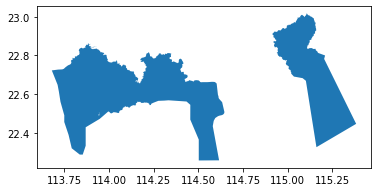

In [5]:
# According the city name, you can input one city name or several city names
boundary_raw = ox.geocode_to_gdf(place_name)
boundary_raw.plot()

### 1.1.2 Preprocessing data

- Remove unwanted data  
Here are two discontinuous boundaries, the smaller one is an **exclave** of Shenzhen called **'Shenshan Special Cooperation Zone'** , and does not suitable for this study, so it will be removed.  
Delete holes using QGIS.
- Set the coordinate system to 3857

In [6]:
# delete unneeded boundary 
boundary = boundary_raw.explode()
boundary['area'] = boundary.geometry.area
print(boundary)
print('----------------------------------------------------------------------')
print(boundary.index)

     bbox_north  bbox_south  bbox_east   bbox_west   place_id  osm_type  \
0 0   23.016517   22.257326  115.38391  113.679356  298157503  relation   
  1   23.016517   22.257326  115.38391  113.679356  298157503  relation   

      osm_id        lat         lon                         display_name  \
0 0  3464353  22.544574  114.054543  Shenzhen, Guangdong Province, China   
  1  3464353  22.544574  114.054543  Shenzhen, Guangdong Province, China   

        class            type  importance  \
0 0  boundary  administrative    0.802985   
  1  boundary  administrative    0.802985   

                                              geometry      area  
0 0  POLYGON ((113.67936 22.72275, 113.68215 22.716...  0.257503  
  1  POLYGON ((114.91332 22.91029, 114.91340 22.909...  0.125520  
----------------------------------------------------------------------
MultiIndex([(0, 0),
            (0, 1)],
           )


The index of smaller boundary is  (0, 1), so it can be removed by index.

<AxesSubplot:>

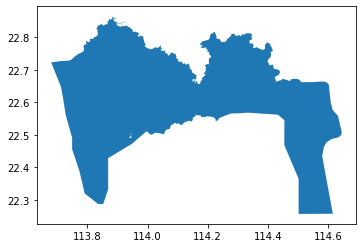

In [7]:
# Remove the unwanted boundary
boundary = boundary.drop(index= (0, 1))
boundary.plot()

In [8]:
# Set the coordinate system to 3857，which is projected coordinate system used for rendering maps in Google Maps, OpenStreetMap, etc. For details see [https://epsg.io/3857]
boundary =  boundary.to_crs(epsg = 3857)

In [153]:
# Save it to local disc
boundary.to_file('outputdata/boundary.geojson')

**Swithing to QGIS**, apply 'QGIS - Vecor geometry - Delete holes' to delete holes of this geodf

<AxesSubplot:>

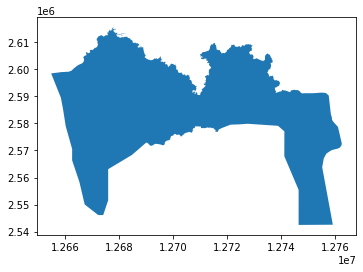

In [9]:
# Read boundary file form local disc
boundary = gpd.read_file('outputdata/boundary.geojson')
boundary.plot()

In [10]:
# Drop unwanted columns and calculate area again
boundary = boundary[['display_name','geometry']]
boundary['area'] = boundary.geometry.area

In [11]:
boundary

display_name  \
0  Shenzhen, Guangdong Province, China   

                                            geometry          area  
0  POLYGON ((12654728.079 2598524.559, 12655038.6...  3.456825e+09

## 1.2 Get roadnet of the city from OSM

In [10]:
# Run time around 4 mins
# Get WALK road net from OSM, set buffer distance of city boundary as 1500m
start_time = time.time()

G_walk = ox.graph_from_place(place_name, network_type='walk', buffer_dist=1500)
G_walk_proj = ox.project_graph(G_walk, to_crs='epsg:3857')
G_walk_nodes_proj, G_walk_edges_proj = ox.graph_to_gdfs(G_walk_proj, nodes=True, edges=True)

# union roads which prepared for intersection with park polygon
edges_walk = G_walk_edges_proj.unary_union 

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")


Run time:  5.784723913669586 mins


In [11]:
print(type(G_walk_edges_proj))
print(type(edges_walk))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'shapely.geometry.multilinestring.MultiLineString'>


In [164]:
G_walk_edges_proj[['geometry']].to_file('outputdata/G_walk_edges_proj.geojson')

In [167]:
G_bike_edges_proj[['geometry']].to_file('outputdata/G_bike_edges_proj.geojson')

In [159]:
# Run time around 2 mins
# Get DRIVE road net from OSM, set buffer distance of city boundary as 5000m
start_time = time.time()

G_drive = ox.graph_from_place(place_name, network_type='drive', buffer_dist=5000)
G_drive_proj = ox.project_graph(G_drive, to_crs='epsg:3857')
G_drive_nodes_proj, G_drive_edges_proj = ox.graph_to_gdfs(G_drive_proj, nodes=True, edges=True)

# union roads which prepared for intersection with park polygon
edges_drive = G_drive_edges_proj.unary_union 

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")


Run time:  1.935895315806071 mins


In [168]:
G_drive_edges_proj[['geometry']].to_file('outputdata/G_drive_edges_proj.geojson')

## 1.3 Get polygon data of the parks from OSM

Park boundaries data consists of community park, city park and nature park.

**Community park** -- applying tag{'leisure': 'park'}; 'community'('社区' in Chinese) in name or area <= 100000 square metre.  
**City park** -- applying tag{'leisure': 'park'}; minus what's left of the community park.  
**Nature park** -- applying tag{'boundary': 'national_park','landuse': 'forest','natural': 'wood'}; particularly, {'landuse': 'forest','natural': 'wood'} requires that the name contain 'garden' ('公园' in Chinese).

### 1.3.1 Community park

<AxesSubplot:>

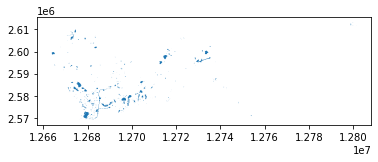

In [518]:
# Get park boundaries by OSM tag ['leisure': 'park']
tags = {'leisure': 'park'}

park_raw = ox.geometries_from_place(place_name, tags)
park= park_raw.loc[park_raw.geometry.type=='Polygon']
park = park.to_crs(epsg = 3857)

park.plot()

In [519]:
len(park)

439

In [531]:
selected_columns = [ 'geometry', 'name', 'name:en','name:zh'] 
park = park.loc[:, selected_columns]
park['area'] = park.geometry.area
park.head(3)

geometry  \
element_type osmid                                                         
way          31352156  POLYGON ((12703647.541 2578300.961, 12703681.4...   
             31355768  POLYGON ((12702848.612 2578630.350, 12702893.3...   
             97228990  POLYGON ((12705079.766 2577984.669, 12705096.4...   

                        name          name:en name:zh           area  
element_type osmid                                                    
way          31352156   儿童公园  Children's Park    儿童公园   66271.853123  
             31355768   人民公园    People's Park    人民公园  135493.847185  
             97228990  黄贝岭公园              NaN     NaN   67446.421539

In [532]:
# Filter out parks with 'community' ('社区公园' in Chinese ) in the name.
community_park_1 = park[park['name'].str.contains('社区公园', na=False)]
community_park_1.head(3)

geometry  \
element_type osmid                                                          
way          330635857  POLYGON ((12709458.774 2579092.201, 12709471.1...   
             665904268  POLYGON ((12705444.304 2579506.073, 12705407.2...   
             679777832  POLYGON ((12706701.658 2578311.629, 12706707.6...   

                            name name:en name:zh         area  
element_type osmid                                             
way          330635857  莲塘莲花社区公园     NaN     NaN  2412.938819  
             665904268   爱国路社区公园     NaN     NaN  1313.618837  
             679777832    新兴社区公园     NaN     NaN  2859.137686

In [533]:
print(community_park_1['name'].unique())

['莲塘莲花社区公园' '爱国路社区公园' '新兴社区公园' '桥东社区公园' '新园社区公园' '笋岗东社区公园' '汤坑社区公园'
 '怡锦社区公园' '虚拟大学园社区公园' '红花岭社区公园' '后海民心社区公园' '官龙村社区公园' '兴融社区公园' '朗山社区公园'
 '民乐社区公园' '白沙岭社区公园' '龙珠社区公园' '新天社区公园' '福南社区公园' '吉龙七街北社区公园' '绿谷社区公园'
 '平山社区公园' '留仙南社区公园' '马家龙社区公园' '海德苑社区公园' '东角头社区公园' '84区社区公园' '学府学区社区公园'
 '塘下涌牛黄山社区公园' '塘下涌对面山社区公园' '燕山社区公园']


In [534]:
park_union = gpd.GeoDataFrame(geometry=[park.unary_union]).explode(index_parts=False).reset_index(drop=True).set_crs(epsg = 3857)
park_union = gpd.sjoin(park_union, park, how='left')
park_union = park_union[['geometry']]

In [535]:
park_dif = gpd.overlay(park_union, community_park_1, how='difference')
park_dif['area'] = park_dif.geometry.area

In [536]:
# Filter out parks less than 10 hectares in size
community_park_2 = park_dif [park_dif["area"] <= 100000]

# Merge two community_parks into one geodf 
community_park = community_park_1.append(community_park_2).drop_duplicates()

# Clip to the boundary
community_park = community_park.clip(boundary,keep_geom_type=False)
community_park.head(3)

geometry name name:en name:zh  \
63  POLYGON ((12680330.594 2569488.633, 12680325.6...  NaN     NaN     NaN   
64  POLYGON ((12682170.560 2570118.564, 12682173.5...  NaN     NaN     NaN   
65  POLYGON ((12680925.541 2570312.069, 12680925.7...  NaN     NaN     NaN   

            area  
63   9114.694976  
64  23098.581179  
65   5570.113266

In [537]:
# Clip park data within the city administrative boundary
community_park = community_park.clip(boundary.buffer(5000), keep_geom_type=False)
    
# Merge the overlap green space into one polygon
tmp = gpd.GeoDataFrame(geometry=[community_park.unary_union]).explode(index_parts=False).reset_index(drop=True).set_crs(epsg = 3857)
tmp = gpd.sjoin(tmp, community_park, how='left').drop(columns=['index_right'])
community_park = tmp.dissolve(tmp.index, aggfunc='first')

# reset the index 
community_park = community_park.reset_index(drop=True)
community_park['area'] = community_park.geometry.area
community_park= community_park.drop_duplicates()

In [538]:
# Clip park data within the city administrative boundary
community_park = community_park.clip(boundary.buffer(5000), keep_geom_type=False)
    
# Merge the overlap green space into one polygon
tmp = gpd.GeoDataFrame(geometry=[community_park.unary_union]).explode(index_parts=False).reset_index(drop=True).set_crs(epsg = 3857)
tmp = gpd.sjoin(tmp, community_park, how='left').drop(columns=['index_right'])
community_park = tmp.dissolve(tmp.index, aggfunc='first')

# reset the index 
community_park = community_park.reset_index(drop=True)
community_park['area'] = community_park.geometry.area
community_park = community_park.drop_duplicates()
community_park = community_park[['geometry','area']]

In [539]:
# Check detalis
print(community_park.crs)
print('----------------------------------------------------------------------')
print(community_park.info())
print('----------------------------------------------------------------------')
print(community_park.head())
print('----------------------------------------------------------------------')
print(community_park.describe())

epsg:3857
----------------------------------------------------------------------
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 315 entries, 0 to 314
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  315 non-null    geometry
 1   area      315 non-null    float64 
dtypes: float64(1), geometry(1)
memory usage: 7.4 KB
None
----------------------------------------------------------------------
                                            geometry         area
0  POLYGON ((12676385.375 2569222.204, 12676406.3...  2270.184930
1  POLYGON ((12679027.243 2569266.514, 12679034.8...  4009.993341
2  POLYGON ((12677170.901 2569528.728, 12677157.0...  8847.137953
3  POLYGON ((12676638.349 2569987.567, 12676667.9...  5363.395527
4  POLYGON ((12677276.120 2570642.746, 12677265.6...  2370.816815
----------------------------------------------------------------------
                area
count     315.000000
mean    2

In [ ]:
community_park.plot()

In [304]:
community_park[['geometry','area']].to_file('outputdata/community_park.geojson')

### 1.3.2 City park

In [305]:
# Filter out the remaining city parks

city_park = park_dif [park_dif["area"] > 100000]

city_park = city_park.clip(boundary,keep_geom_type=False)
city_park['area'] = city_park.geometry.area
city_park.head(3)

geometry           area
60  POLYGON ((12681158.510 2569563.449, 12681168.4...  313146.650142
62  POLYGON ((12681158.510 2569563.449, 12681168.4...  313146.650142
61  POLYGON ((12681158.510 2569563.449, 12681168.4...  313146.650142

In [306]:
# Clip park data within the city administrative boundary
city_park = city_park.clip(boundary.buffer(5000), keep_geom_type=False)
    
# Merge the overlap green space into one polygon
tmp = gpd.GeoDataFrame(geometry=[city_park.unary_union]).explode(index_parts=False).reset_index(drop=True).set_crs(epsg = 3857)
tmp = gpd.sjoin(tmp, city_park, how='left').drop(columns=['index_right'])
city_park = tmp.dissolve(tmp.index, aggfunc='first')

# reset the index 
city_park = city_park.reset_index(drop=True)
city_park['area'] = city_park.geometry.area
city_park= city_park.drop_duplicates()

In [372]:
# Check detalis
print(city_park.crs)
print('----------------------------------------------------------------------')
print(city_park.info())
print('----------------------------------------------------------------------')
print(city_park.head())
print('----------------------------------------------------------------------')
print(city_park.describe())

epsg:3857
----------------------------------------------------------------------
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   84 non-null     geometry
 1   area       84 non-null     float64 
 2   park_type  84 non-null     object  
dtypes: float64(1), geometry(1), object(1)
memory usage: 2.6+ KB
None
----------------------------------------------------------------------
                                            geometry       area  park_type
0  POLYGON ((12680236.829 2572678.411, 12680343.9... 5042843.74  city_park
1  POLYGON ((12678447.547 2574916.209, 12678449.9...  504362.99  city_park
2  POLYGON ((12677639.267 2575459.765, 12677647.3...  102884.24  city_park
3  POLYGON ((12677993.385 2576049.016, 12677993.3...  135936.75  city_park
4  POLYGON ((12676815.069 2577196.170, 12676810.9...  231873.35  city_park
-------------

<AxesSubplot:>

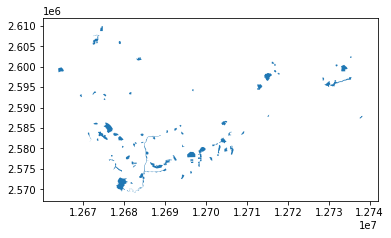

In [245]:
city_park.plot()

In [308]:
city_park[['geometry','area']].to_file('outputdata/city_park.geojson')

### 1.3.3 Nature park

<AxesSubplot:>

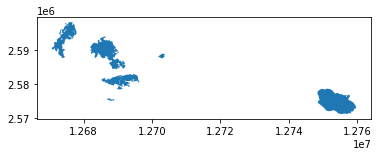

In [520]:
# Get park boundaries by OSM tag ['boundary': 'national_park']
tags = {'boundary': 'national_park'}

national_park_raw = ox.geometries_from_place(place_name, tags)
national_park = national_park_raw.loc[national_park_raw.geometry.type=='Polygon']
national_park = national_park.to_crs(epsg = 3857)

national_park.plot()

In [521]:
len(national_park)

7

<AxesSubplot:>

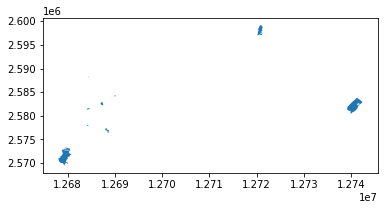

In [341]:
# Get park boundaries by OSM tag ['landuse': 'forest', 'natural': 'wood'], 
# Some parks are incorrectly classified under the tags ‘forest’ or ‘wood’, using the method of whether 'park'('公园' in Chinese) is included in the name to filter out the required data. 
tags = {'landuse': 'forest', 'natural': 'wood'}

forest_park_raw = ox.geometries_from_place(place_name, tags)
forest_park = forest_park_raw.loc[forest_park_raw.geometry.type=='Polygon']
forest_park = forest_park[forest_park['name'].str.contains('公园', na=False)]
forest_park = forest_park.to_crs(epsg = 3857)

forest_park.plot()

/tmp/ipykernel_88/2202308847.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nature_park = national_park.append(forest_park)


<AxesSubplot:>

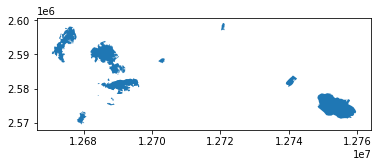

In [343]:
# Merge national_park and forest_park.
nature_park = national_park.append(forest_park)
nature_park = nature_park.clip(boundary,keep_geom_type=False)

nature_park_union = gpd.GeoDataFrame(geometry=[nature_park.unary_union]).explode(index_parts=False).reset_index(drop=True).set_crs(epsg = 3857)
nature_park_union = gpd.sjoin(nature_park_union, nature_park, how='left')
nature_park_union = nature_park_union[['geometry']]

nature_park = nature_park_union

nature_park.plot()


In [345]:
# Clip park data within the city administrative boundary
nature_park = nature_park.clip(boundary.buffer(5000), keep_geom_type=False)
    
# Merge the overlap green space into one polygon
tmp = gpd.GeoDataFrame(geometry=[nature_park.unary_union]).explode(index_parts=False).reset_index(drop=True).set_crs(epsg = 3857)
tmp = gpd.sjoin(tmp, nature_park, how='left').drop(columns=['index_right'])
nature_park = tmp.dissolve(tmp.index, aggfunc='first')

In [347]:
# Remove overlap polygons between naturk park and community_park, city_park
community_city_parkmerged = pd.concat([community_park, city_park], ignore_index=True)
difference_geo = nature_park.difference(community_city_parkmerged.unary_union)
nature_park = gpd.GeoDataFrame(geometry=difference_geo, crs=nature_park.crs)

In [357]:
# Remove null and NANs
nature_park= nature_park.drop_duplicates()
nature_park['area'] = nature_park.geometry.area
nature_park = nature_park[(~nature_park['area'].isnull()) & (nature_park['area'] != 0)]
nature_park = nature_park.reset_index(drop=True)

In [374]:
# Check detalis
print(nature_park.crs)
print('----------------------------------------------------------------------')
print(nature_park.info())
print('----------------------------------------------------------------------')
print(nature_park.head())
print('----------------------------------------------------------------------')
print(nature_park.describe())

epsg:3857
----------------------------------------------------------------------
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   9 non-null      geometry
 1   area       9 non-null      float64 
 2   park_type  9 non-null      object  
dtypes: float64(1), geometry(1), object(1)
memory usage: 344.0+ bytes
None
----------------------------------------------------------------------
                                            geometry        area    park_type
0  POLYGON ((12679881.408 2572833.541, 12679870.6...   467504.73  nature_park
1  POLYGON ((12688162.844 2592520.404, 12688158.8... 41179294.12  nature_park
2  POLYGON ((12673137.985 2593925.530, 12673166.2... 27593439.45  nature_park
3  POLYGON ((12752299.735 2578252.444, 12752354.9... 54929251.66  nature_park
4  POLYGON ((12688774.678 2576889.372, 12688685.0...   311679.02  natu

<AxesSubplot:>

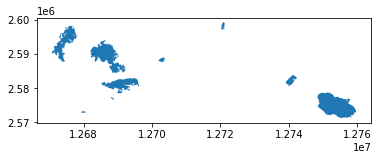

In [358]:
nature_park.plot()

In [361]:
nature_park[['geometry','area']].to_file('outputdata/nature_park.geojson')

### statistic

In [2242]:
# 使用overlay计算每个district中每种公园的面积
district_community = gpd.overlay(district, community_park, how='intersection')
district_city = gpd.overlay(district, city_park, how='intersection')
district_nature = gpd.overlay(district, nature_park, how='intersection')

# 计算每个交集区域的面积
district_community['community_area'] = district_community.geometry.area
district_city['city_area'] = district_city.geometry.area
district_nature['nature_area'] = district_nature.geometry.area

# 汇总每个district的公园面积
community_group = district_community.groupby('Name').community_area.sum()
city_group = district_city.groupby('Name').city_area.sum()
nature_group = district_nature.groupby('Name').nature_area.sum()

# 合并到一个DataFrame
result = pd.concat([community_group, city_group, nature_group], axis=1)
result.reset_index(inplace=True)

result

# # 将结果存储到本地CSV文件
# result.to_csv("tmp/district_park_areas.csv", index=False,encoding = 'utf-8')


In [2243]:
result

Name  community_area     city_area   nature_area
0      Baoan    1.207467e+06  1.166346e+07  3.527870e+07
1     Dapeng    2.824280e+05  1.891862e+05  5.995563e+07
2     Futian    8.567425e+05  8.537601e+06  9.590607e+06
3  Guangming    3.229913e+05  8.886162e+05  4.009310e+06
4   Longgang    5.546726e+05  5.284193e+06  3.117910e+06
5    Longhua    8.491081e+05  7.815536e+05  1.585858e+07
6      Luohu    4.445592e+05  4.014916e+06           NaN
7    Nanshan    1.571870e+06  1.423855e+07  2.771674e+07
8   Pingshan    1.702563e+05  4.952514e+06           NaN
9    Yantian    2.420314e+05           NaN           NaN

### 1.3.4 Recognize entrance

In [15]:
G_walk_edges_proj = gpd.read_file('outputdata/G_walk_edges_proj.geojson')
edges_walk = G_walk_edges_proj.unary_union 

#### Community_park entrance

In [17]:
# Read park polygons
community_park= gpd.read_file('outputdata/community_park.geojson').to_crs(epsg = 4326)

# Park geometry centroid as the Community park entrance 
community_park['Coparkid'] = community_park.index + 1
community_park['polygonStr'] =community_park['geometry'].astype('str')
community_park['geometry'] = community_park['geometry'].centroid
community_park['avg_area'] = community_park['area']
community_park['longitude'] = community_park['geometry'].x
community_park['latitude'] = community_park['geometry'].y

In [18]:
community_park

area                    geometry  Coparkid  \
0     2270.184930  POINT (113.87392 22.47933)         1   
1     4009.993341  POINT (113.89800 22.47997)         2   
2     8847.137953  POINT (113.88108 22.48272)         3   
3     5363.395527  POINT (113.87618 22.48575)         4   
4     2370.816815  POINT (113.88181 22.49187)         5   
..            ...                         ...       ...   
310   3666.556889  POINT (114.24624 22.74552)       311   
311   9558.022705  POINT (114.28705 22.78074)       312   
312   3382.601236  POINT (114.28596 22.78236)       313   
313  16331.412112  POINT (114.28367 22.78549)       314   
314  39924.270826  POINT (114.29739 22.78574)       315   

                                            polygonStr      avg_area  \
0    POLYGON ((113.873907 22.479741, 113.874095 22....   2270.184930   
1    POLYGON ((113.89764 22.480109, 113.897708 22.4...   4009.993341   
2    POLYGON ((113.880964 22.482285, 113.880839 22....   8847.137953   
3    POLYGON ((113.87618 22.486094, 113.876445 22.4...   5363.395527   
4    POLYGON ((113.881909 22.491532, 113.881815 22....   2370.816815   
..                                                 ...           ...   
310  POLYGON ((114.245785 22.745651, 114.246566 22....   3666.556889   
311  POLYGON ((114.286688 22.780403, 114.286419 22....   9558.022705   
312  POLYGON ((114.285964 22.78204, 114.285778 22.7...   3382.601236   
313  POLYGON ((114.283972 22.786225, 114.28454 22.7...  16331.412112   
314  POLYGON ((114.296392 22.785996, 114.295899 22....  39924.270826   

      longitude   latitude  
0    113.873920  22.479326  
1    113.897997  22.479975  
2    113.881082  22.482715  
3    113.876181  22.485750  
4    113.881807  22.491865  
..          ...        ...  
310  114.246244  22.745523  
311  114.287046  22.780740  
312  114.285964  22.782360  
313  114.283674  22.785494  
314  114.297386  22.785737  

[315 rows x 7 columns]

In [529]:
community_park.describe()

area    Coparkid       avg_area   longitude    latitude  index
count     315.000000  315.000000     315.000000  315.000000  315.000000  315.0
mean    20641.672492  158.000000   20641.672492  114.030282   22.593949    1.0
std     22902.597070   91.076891   22902.597070    0.145895    0.077570    0.0
min        65.872970    1.000000      65.872970  113.771861   22.479326    1.0
25%      4898.854364   79.500000    4898.854364  113.925127   22.542313    1.0
50%     11438.970569  158.000000   11438.970569  114.024417   22.564828    1.0
75%     27113.656599  236.500000   27113.656599  114.091022   22.635243    1.0
max    109055.778913  315.000000  109055.778913  114.570879   22.809535    1.0

In [31]:
community_park.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [204]:
community_park.to_csv('community_park_entrance.csv',index = False, encoding = 'utf-8')

In [30]:
community_park.to_file('community_park_entrance.geojson')

#### City_park entracne

In [19]:
# Read park polygons
city_park = gpd.read_file('outputdata/city_park.geojson').to_crs(epsg = 3857)

# Park geometry centroid as the Community park entrance 
city_park['Cityparkid'] = city_park.index + 1

In [20]:
start_time = time.time()

# add the buffer of 30m for each components
city_park['buffer'] = city_park.geometry.buffer(30)

# convert MultiLineString to list of LineString
edges_list = [line for line in edges_walk]

# create an empty list to store entrances
entrance = []

# create an empty list to store parks without entrances
no_entrance_parks = []

for idx, row in city_park.iterrows():
    has_entrance = False
    for edge in edges_list:
        # Check if the edge intersects with the buffer
        if row['buffer'].exterior.intersects(edge):
            has_entrance = True
            intersection = row['buffer'].exterior.intersection(edge)
            # if intersection is a MultiPoint, get each point
            if intersection.is_empty:
                continue
            if intersection.geom_type == 'MultiPoint':
                for point in intersection:
                    entrance.append({'geometry': point, 'area': row['geometry'].area, 'Cityparkid': row['Cityparkid']})
            else:
                entrance.append({'geometry': intersection, 'area': row['geometry'].area, 'Cityparkid': row['Cityparkid']})
    # If after checking all edges no entrance is found for the park, add the parkid to the no_entrance_parks list
    if not has_entrance:
        no_entrance_parks.append(row['Cityparkid'])

entrance_sub_buf = gpd.GeoDataFrame(entrance)

# Print parks without entrances or a message if all parks have entrances
if no_entrance_parks:
    print("Parks without entrances:", no_entrance_parks)
else:
    print("All parks have entrances.")


# Create a buffer 100m around each entrance, this is a vectorized operation, remove unwanted fake entrance
entrance_sub_buf['buffer'] = entrance_sub_buf.geometry.buffer(100)

# Generate weights matrix based on fuzzy contiguity
w_e = libpysal.weights.fuzzy_contiguity(entrance_sub_buf['buffer'])

# Add component labels as a new column
entrance_sub_buf['entrance_components'] = w_e.component_labels

# Sort values by 'entrance_components' to optimize drop_duplicates
entrance_sub_buf = entrance_sub_buf.sort_values('entrance_components')

# Delete duplicate rows based on 'entrance_components'
entrance_sub_buf = entrance_sub_buf.drop_duplicates(subset=["entrance_components"], keep='first')
entrance_sub_buf.drop(['buffer','entrance_components'], axis = 1, inplace=True)


# Reset index
entrance_sub_buf = entrance_sub_buf.sort_values('Cityparkid')
eentrance_sub_buf = entrance_sub_buf.reset_index(drop=True)

# Calculate average area of each entrance
entrance_sub_buf['count'] = entrance_sub_buf.groupby('Cityparkid')['Cityparkid'].transform('count')
entrance_sub_buf['avg_area'] = entrance_sub_buf['area'] / entrance_sub_buf['count']

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")

All parks have entrances.
Run time:  11.358934124310812 mins


In [21]:
# If there is park without entrance recognized, use the centroid as the entrance
if len(no_entrance_parks) > 0:
    no_ent = city_park[city_park['Cityparkid'].isin(no_entrance_parks)]
    no_ent['avg_area']=no_ent['area']
    no_ent['geometry']=no_ent['geometry'].centroid
    no_ent['count']=1
# no_ent_city_parks.drop(columns=['col1', 'col2'], inplace=True)
    entrance_sub_buf = pd.concat([entrance_sub_buf,no_ent])
else:
     print("All parks have entrances.")

All parks have entrances.


In [22]:
city_park=city_park.to_crs(epsg = 4326)
city_park['polygonStr'] = city_park['geometry'].astype('str')

In [23]:
entrance_sub_buf.crs = "EPSG:3857"

In [24]:
entrance_sub_buf=entrance_sub_buf.to_crs(epsg = 4326)

In [25]:
entrance_sub_buf['longitude'] = entrance_sub_buf['geometry'].x
entrance_sub_buf['latitude'] = entrance_sub_buf['geometry'].y

In [26]:
entrance_sub_buf = entrance_sub_buf.merge(city_park[['Cityparkid', 'polygonStr']], on='Cityparkid', how='left')

In [27]:
city_park = entrance_sub_buf

In [28]:
city_park

geometry          area  Cityparkid  count  \
0    POINT (113.90029 22.48147)  5.042844e+06           1     15   
1    POINT (113.89406 22.49911)  5.042844e+06           1     15   
2    POINT (113.89354 22.50722)  5.042844e+06           1     15   
3    POINT (113.88870 22.49495)  5.042844e+06           1     15   
4    POINT (113.91190 22.50835)  5.042844e+06           1     15   
..                          ...           ...         ...    ...   
408  POINT (114.40171 22.75384)  1.089056e+05          84      5   
409  POINT (114.40327 22.75622)  1.089056e+05          84      5   
410  POINT (114.40662 22.75457)  1.089056e+05          84      5   
411  POINT (114.40328 22.75240)  1.089056e+05          84      5   
412  POINT (114.40518 22.75573)  1.089056e+05          84      5   

          avg_area   longitude   latitude  \
0    336189.582370  113.900289  22.481475   
1    336189.582370  113.894065  22.499114   
2    336189.582370  113.893537  22.507221   
3    336189.582370  113.888704  22.494954   
4    336189.582370  113.911896  22.508349   
..             ...         ...        ...   
408   21781.119661  114.401712  22.753841   
409   21781.119661  114.403265  22.756221   
410   21781.119661  114.406617  22.754570   
411   21781.119661  114.403277  22.752399   
412   21781.119661  114.405185  22.755732   

                                            polygonStr  
0    POLYGON ((113.908505 22.508427, 113.909468 22....  
1    POLYGON ((113.908505 22.508427, 113.909468 22....  
2    POLYGON ((113.908505 22.508427, 113.909468 22....  
3    POLYGON ((113.908505 22.508427, 113.909468 22....  
4    POLYGON ((113.908505 22.508427, 113.909468 22....  
..                                                 ...  
408  POLYGON ((114.403345 22.755983, 114.40508 22.7...  
409  POLYGON ((114.403345 22.755983, 114.40508 22.7...  
410  POLYGON ((114.403345 22.755983, 114.40508 22.7...  
411  POLYGON ((114.403345 22.755983, 114.40508 22.7...  
412  POLYGON ((114.403345 22.755983, 114.40508 22.7...  

[413 rows x 8 columns]

In [32]:
city_park.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
city_park.to_csv('city_park_entrance.csv',index = False, encoding = 'utf-8')

In [34]:
city_park.to_file('city_park_entrance.geojson')

#### Nature_park entracne

In [35]:
# Read park polygons
nature_park = gpd.read_file('outputdata/nature_park.geojson').to_crs(epsg = 3857)

# Park geometry centroid as the Community park entrance 
nature_park['Natureparkid'] = nature_park.index + 1

In [36]:
# Read park polygons
nature_park = gpd.read_file('outputdata/nature_park.geojson').to_crs(epsg = 3857)

# Park geometry centroid as the Community park entrance 
nature_park['Natureparkid'] = nature_park.index + 1

In [37]:
nature_park

area                                           geometry  \
0  4.675047e+05  POLYGON ((12679881.408 2572833.541, 12679870.6...   
1  4.117929e+07  POLYGON ((12688162.844 2592520.404, 12688158.8...   
2  2.759344e+07  POLYGON ((12673137.985 2593925.530, 12673166.2...   
3  5.492925e+07  POLYGON ((12752299.735 2578252.444, 12752354.9...   
4  3.116790e+05  POLYGON ((12688774.678 2576889.372, 12688685.0...   
5  2.290202e+07  POLYGON ((12694354.868 2582665.410, 12694402.1...   
6  5.026383e+06  POLYGON ((12740253.597 2580768.333, 12740202.5...   
7  1.610089e+06  POLYGON ((12702472.964 2587659.998, 12702453.3...   
8  1.507821e+06  POLYGON ((12720963.622 2597654.660, 12721153.9...   

   Natureparkid  
0             1  
1             2  
2             3  
3             4  
4             5  
5             6  
6             7  
7             8  
8             9

In [38]:
start_time = time.time()

# add the buffer of 30m for each components
nature_park['buffer'] = nature_park.geometry.buffer(30)

# convert MultiLineString to list of LineString
edges_list = [line for line in edges_walk]

# create an empty list to store entrances
entrance = []

# create an empty list to store parks without entrances
no_entrance_parks = []

for idx, row in nature_park.iterrows():
    has_entrance = False
    for edge in edges_list:
        # Check if the edge intersects with the buffer
        if row['buffer'].exterior.intersects(edge):
            has_entrance = True
            intersection = row['buffer'].exterior.intersection(edge)
            # if intersection is a MultiPoint, get each point
            if intersection.is_empty:
                continue
            if intersection.geom_type == 'MultiPoint':
                for point in intersection:
                    entrance.append({'geometry': point, 'area': row['geometry'].area, 'Natureparkid': row['Natureparkid']})
            else:
                entrance.append({'geometry': intersection, 'area': row['geometry'].area, 'Natureparkid': row['Natureparkid']})
    # If after checking all edges no entrance is found for the park, add the parkid to the no_entrance_parks list
    if not has_entrance:
        no_entrance_parks.append(row['Natureparkid'])

entrance_sub_buf = gpd.GeoDataFrame(entrance)

# Print parks without entrances or a message if all parks have entrances
if no_entrance_parks:
    print("Parks without entrances:", no_entrance_parks)
else:
    print("All parks have entrances.")


# Create a buffer 200m around each entrance, this is a vectorized operation, remove unwanted fake entrance
entrance_sub_buf['buffer'] = entrance_sub_buf.geometry.buffer(200)

# Generate weights matrix based on fuzzy contiguity
w_e = libpysal.weights.fuzzy_contiguity(entrance_sub_buf['buffer'])

# Add component labels as a new column
entrance_sub_buf['entrance_components'] = w_e.component_labels

# Sort values by 'entrance_components' to optimize drop_duplicates
entrance_sub_buf = entrance_sub_buf.sort_values('entrance_components')

# Delete duplicate rows based on 'entrance_components'
entrance_sub_buf = entrance_sub_buf.drop_duplicates(subset=["entrance_components"], keep='first')
entrance_sub_buf.drop(['buffer','entrance_components'], axis = 1, inplace=True)


# Reset index
entrance_sub_buf = entrance_sub_buf.sort_values('Natureparkid')
eentrance_sub_buf = entrance_sub_buf.reset_index(drop=True)

# Calculate average area of each entrance
entrance_sub_buf['count'] = entrance_sub_buf.groupby('Natureparkid')['Natureparkid'].transform('count')
entrance_sub_buf['avg_area'] = entrance_sub_buf['area'] / entrance_sub_buf['count']

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")

All parks have entrances.
Run time:  1.5567407250404357 mins


In [39]:
entrance_sub_buf

geometry          area  Natureparkid  count  \
0    POINT (12679602.767 2573107.364)  4.675047e+05             1      1   
214  POINT (12687238.367 2592699.862)  4.117929e+07             2     20   
222  POINT (12686478.234 2593649.434)  4.117929e+07             2     20   
183  POINT (12689503.459 2588691.920)  4.117929e+07             2     20   
210  POINT (12688626.236 2592200.697)  4.117929e+07             2     20   
..                                ...           ...           ...    ...   
517  POINT (12702599.063 2587691.815)  1.610089e+06             8      3   
532  POINT (12721189.838 2597069.434)  1.507821e+06             9      4   
535  POINT (12720624.016 2599046.451)  1.507821e+06             9      4   
540  POINT (12720243.215 2597532.918)  1.507821e+06             9      4   
537  POINT (12720453.294 2598617.610)  1.507821e+06             9      4   

         avg_area  
0    4.675047e+05  
214  2.058965e+06  
222  2.058965e+06  
183  2.058965e+06  
210  2.058965e+06  
..            ...  
517  5.366962e+05  
532  3.769553e+05  
535  3.769553e+05  
540  3.769553e+05  
537  3.769553e+05  

[89 rows x 5 columns]

In [40]:
# If there is park without entrance recognized, use the centroid as the entrance
if len(no_entrance_parks) > 0:
    no_ent = nature_park[nature_park['natureparkid'].isin(no_entrance_parks)]
    no_ent['avg_area']=no_ent['area']
    no_ent['geometry']=no_ent['geometry'].centroid
    no_ent['count']=1
# no_ent_nature_parks.drop(columns=['col1', 'col2'], inplace=True)
    entrance_sub_buf = pd.concat([entrance_sub_buf,no_ent])
else:
     print("All parks have entrances.")

All parks have entrances.


In [41]:
nature_park=nature_park.to_crs(epsg = 4326)
nature_park['polygonStr'] = nature_park['geometry'].astype('str')

In [42]:
entrance_sub_buf.crs = "EPSG:3857"
entrance_sub_buf=entrance_sub_buf.to_crs(epsg = 4326)

In [43]:
entrance_sub_buf['longitude'] = entrance_sub_buf['geometry'].x
entrance_sub_buf['latitude'] = entrance_sub_buf['geometry'].y

In [44]:
entrance_sub_buf

geometry          area  Natureparkid  count  \
0    POINT (113.90281 22.51199)  4.675047e+05             1      1   
214  POINT (113.97140 22.67448)  4.117929e+07             2     20   
222  POINT (113.96457 22.68235)  4.117929e+07             2     20   
183  POINT (113.99175 22.64126)  4.117929e+07             2     20   
210  POINT (113.98387 22.67034)  4.117929e+07             2     20   
..                          ...           ...           ...    ...   
517  POINT (114.10939 22.63296)  1.610089e+06             8      3   
532  POINT (114.27639 22.71070)  1.507821e+06             9      4   
535  POINT (114.27131 22.72708)  1.507821e+06             9      4   
540  POINT (114.26789 22.71454)  1.507821e+06             9      4   
537  POINT (114.26978 22.72352)  1.507821e+06             9      4   

         avg_area   longitude   latitude  
0    4.675047e+05  113.902810  22.511986  
214  2.058965e+06  113.971401  22.674482  
222  2.058965e+06  113.964573  22.682352  
183  2.058965e+06  113.991749  22.641256  
210  2.058965e+06  113.983869  22.670344  
..            ...         ...        ...  
517  5.366962e+05  114.109389  22.632964  
532  3.769553e+05  114.276393  22.710695  
535  3.769553e+05  114.271310  22.727077  
540  3.769553e+05  114.267889  22.714536  
537  3.769553e+05  114.269776  22.723524  

[89 rows x 7 columns]

In [45]:
entrance_sub_buf = entrance_sub_buf.merge(nature_park[['Natureparkid', 'polygonStr']], on='Natureparkid', how='left')

In [46]:
nature_park = entrance_sub_buf

In [47]:
nature_park

geometry          area  Natureparkid  count  \
0   POINT (113.90281 22.51199)  4.675047e+05             1      1   
1   POINT (113.97140 22.67448)  4.117929e+07             2     20   
2   POINT (113.96457 22.68235)  4.117929e+07             2     20   
3   POINT (113.99175 22.64126)  4.117929e+07             2     20   
4   POINT (113.98387 22.67034)  4.117929e+07             2     20   
..                         ...           ...           ...    ...   
84  POINT (114.10939 22.63296)  1.610089e+06             8      3   
85  POINT (114.27639 22.71070)  1.507821e+06             9      4   
86  POINT (114.27131 22.72708)  1.507821e+06             9      4   
87  POINT (114.26789 22.71454)  1.507821e+06             9      4   
88  POINT (114.26978 22.72352)  1.507821e+06             9      4   

        avg_area   longitude   latitude  \
0   4.675047e+05  113.902810  22.511986   
1   2.058965e+06  113.971401  22.674482   
2   2.058965e+06  113.964573  22.682352   
3   2.058965e+06  113.991749  22.641256   
4   2.058965e+06  113.983869  22.670344   
..           ...         ...        ...   
84  5.366962e+05  114.109389  22.632964   
85  3.769553e+05  114.276393  22.710695   
86  3.769553e+05  114.271310  22.727077   
87  3.769553e+05  114.267889  22.714536   
88  3.769553e+05  114.269776  22.723524   

                                           polygonStr  
0   POLYGON ((113.905313 22.509714, 113.905216 22....  
1   POLYGON ((113.979706 22.672994, 113.97967 22.6...  
2   POLYGON ((113.979706 22.672994, 113.97967 22.6...  
3   POLYGON ((113.979706 22.672994, 113.97967 22.6...  
4   POLYGON ((113.979706 22.672994, 113.97967 22.6...  
..                                                ...  
84  POLYGON ((114.108256 22.6327, 114.10808 22.632...  
85  POLYGON ((114.27436 22.715545, 114.276071 22.7...  
86  POLYGON ((114.27436 22.715545, 114.276071 22.7...  
87  POLYGON ((114.27436 22.715545, 114.276071 22.7...  
88  POLYGON ((114.27436 22.715545, 114.276071 22.7...  

[89 rows x 8 columns]

In [48]:
nature_park.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
nature_park.to_csv('nature_park_entrance.csv',index = False, encoding = 'utf-8')

In [50]:
nature_park.to_file('nature_park_entrance.geojson')

### 1.3.4 Merge three types of park geodf X

In [375]:
# Add the "park_type" column with specific values to each DataFrame
community_park["park_type"] = "community_park"
city_park["park_type"] = "city_park"
nature_park["park_type"] = "nature_park"

# Concatenate the DataFrames
park_merged = pd.concat([community_park, city_park, nature_park], ignore_index=True)

# Check detalis
print(park_merged.crs)
print('----------------------------------------------------------------------')
print(park_merged.info())
print('----------------------------------------------------------------------')
print(park_merged)
print('----------------------------------------------------------------------')
print(park_merged.describe())

epsg:3857
----------------------------------------------------------------------
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   408 non-null    geometry
 1   area       408 non-null    float64 
 2   park_type  408 non-null    object  
dtypes: float64(1), geometry(1), object(1)
memory usage: 9.7+ KB
None
----------------------------------------------------------------------
                                              geometry        area  \
0    POLYGON ((12676385.375 2569222.204, 12676406.3...     2270.18   
1    POLYGON ((12679027.243 2569266.514, 12679034.8...     4009.99   
2    POLYGON ((12677170.901 2569528.728, 12677157.0...     8847.14   
3    POLYGON ((12676638.349 2569987.567, 12676667.9...     5363.40   
4    POLYGON ((12677276.120 2570642.746, 12677265.6...     2370.82   
..                                       

<AxesSubplot:>

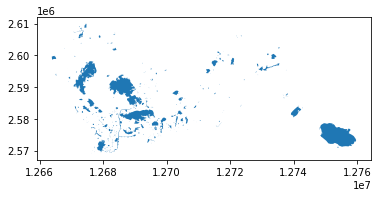

In [376]:
park_merged.plot()

In [368]:
# Save it to local disc
park_merged.to_file('outputdata/Shenzhen_park_polygon.geojson')

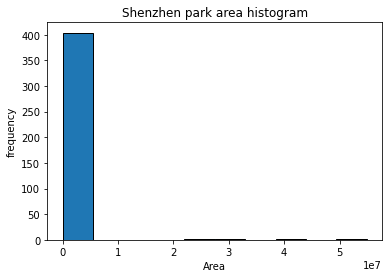

In [371]:
# Plot histogram of park area frequency
plt.figure(figsize=(6, 4)) 
park_merged['area'].plot.hist(bins=10, edgecolor='black')
plt.title('Shenzhen park area histogram')
plt.xlabel('Area')
plt.ylabel('frequency')
plt.show()

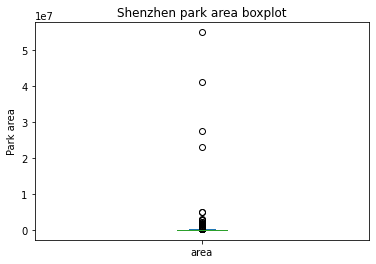

In [370]:
# Plot boxplot of park area frequency
plt.figure(figsize=(6, 4))
park_merged['area'].plot.box()
plt.title('Shenzhen park area boxplot')
plt.ylabel('Park area')
plt.show()

### 1.3.5 Preprocess park polygon data X

In [12]:
park_merged = gpd.read_file('outputdata/Shenzhen_park_polygon.geojson')

In [13]:
# Make a copy of the GeoDataFrame to keep the original intact
green = park_merged.copy()

In [14]:
green['parkid'] = range(1, len(green) + 1)
green

area       park_type  \
0    2.270185e+03  community_park   
1    4.009993e+03  community_park   
2    8.847138e+03  community_park   
3    5.363396e+03  community_park   
4    2.370817e+03  community_park   
..            ...             ...   
403  3.116790e+05     nature_park   
404  2.290202e+07     nature_park   
405  5.026383e+06     nature_park   
406  1.610089e+06     nature_park   
407  1.507821e+06     nature_park   

                                              geometry  parkid  
0    POLYGON ((12676385.375 2569222.204, 12676406.3...       1  
1    POLYGON ((12679027.243 2569266.514, 12679034.8...       2  
2    POLYGON ((12677170.901 2569528.728, 12677157.0...       3  
3    POLYGON ((12676638.349 2569987.567, 12676667.9...       4  
4    POLYGON ((12677276.120 2570642.746, 12677265.6...       5  
..                                                 ...     ...  
403  POLYGON ((12688774.678 2576889.372, 12688685.0...     404  
404  POLYGON ((12694354.868 2582665.410, 12694402.1...     405  
405  POLYGON ((12740253.597 2580768.333, 12740202.5...     406  
406  POLYGON ((12702472.964 2587659.998, 12702453.3...     407  
407  POLYGON ((12720963.622 2597654.660, 12721153.9...     408  

[408 rows x 4 columns]

In [15]:
# 10000：划分公园面积阈值为10000m²，>10000m²的计算fake entrance，<=10000的计算质心centroids为 fake entrance
# 30：计算fake entrance时，buffer公园边界取值30m
# 100：清理fake entrance时，只保留二者大于等于100m的点


start_time = time.time()

green_sub_buf = green[green['area'] > 10000]
green_sub_cen = green[green['area'] <= 10000]

green_sub_cen['geometry'] = green_sub_cen['geometry'].centroid
entrance_sub_cen = green_sub_cen[['geometry','area','parkid']]

# add the buffer of 30m for each components
green_sub_buf['buffer'] = green_sub_buf.geometry.buffer(30)

# convert MultiLineString to list of LineString
edges_list = [line for line in edges_walk]

# # create an empty list to store entrances
# entrance = []

# for idx, row in green_sub_buf.iterrows():
#     for edge in edges_list:
#         # Check if the edge intersects with the buffer
#         if row['buffer'].exterior.intersects(edge):
#             intersection = row['buffer'].exterior.intersection(edge)
#             # if intersection is a MultiPoint, get each point
#             if intersection.is_empty:
#                 continue
#             if intersection.geom_type == 'MultiPoint':
#                 for point in intersection:
#                     entrance.append({'geometry': point, 'area': row['geometry'].area, 'parkid': row['parkid']})
#             else:
#                 entrance.append({'geometry': intersection, 'area': row['geometry'].area, 'parkid': row['parkid']})

# entrance_sub_buf = gpd.GeoDataFrame(entrance)



######

# create an empty list to store entrances
entrance = []

# create an empty list to store parks without entrances
no_entrance_parks = []

for idx, row in green_sub_buf.iterrows():
    has_entrance = False
    for edge in edges_list:
        # Check if the edge intersects with the buffer
        if row['buffer'].exterior.intersects(edge):
            has_entrance = True
            intersection = row['buffer'].exterior.intersection(edge)
            # if intersection is a MultiPoint, get each point
            if intersection.is_empty:
                continue
            if intersection.geom_type == 'MultiPoint':
                for point in intersection:
                    entrance.append({'geometry': point, 'area': row['geometry'].area, 'parkid': row['parkid']})
            else:
                entrance.append({'geometry': intersection, 'area': row['geometry'].area, 'parkid': row['parkid']})
    # If after checking all edges no entrance is found for the park, add the parkid to the no_entrance_parks list
    if not has_entrance:
        no_entrance_parks.append(row['parkid'])

entrance_sub_buf = gpd.GeoDataFrame(entrance)

# Print parks without entrances or a message if all parks have entrances
if no_entrance_parks:
    print("Parks without entrances:", no_entrance_parks)
else:
    print("All parks have entrances.")


######


# Create a buffer around each entrance, this is a vectorized operation, remove unwanted fake entrance
entrance_sub_buf['buffer'] = entrance_sub_buf.geometry.buffer(50)

# Generate weights matrix based on fuzzy contiguity
w_e = libpysal.weights.fuzzy_contiguity(entrance_sub_buf['buffer'])

# Add component labels as a new column
entrance_sub_buf['entrance_components'] = w_e.component_labels

# Sort values by 'entrance_components' to optimize drop_duplicates
entrance_sub_buf = entrance_sub_buf.sort_values('entrance_components')

# Delete duplicate rows based on 'entrance_components'
entrance_sub_buf = entrance_sub_buf.drop_duplicates(subset=["entrance_components"], keep='first')
entrance_sub_buf.drop(['buffer','entrance_components'], axis = 1, inplace=True)

# Merge two gdf
entrance_merged = pd.concat([entrance_sub_cen, entrance_sub_buf])
entrance_merged


# Reset index
entrance_merged = entrance_merged.sort_values('parkid')
entrance_merged = entrance_merged.reset_index(drop=True)

# Calculate average area of each entrance
entrance_merged['count'] = entrance_merged.groupby('parkid')['parkid'].transform('count')
entrance_merged['avg_area'] = entrance_merged['area'] / entrance_merged['count']

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")

Parks without entrances: [59, 96, 112, 151]
Run time:  49.52001818418503 mins


In [16]:
entrance_merged

geometry          area  parkid  count  \
0     POINT (12676386.772 2569172.220)  2.270185e+03       1      1   
1     POINT (12679067.048 2569250.366)  4.009993e+03       2      1   
2     POINT (12677184.066 2569580.510)  8.847138e+03       3      1   
3     POINT (12676638.442 2569946.079)  5.363396e+03       4      1   
4     POINT (12677264.711 2570682.931)  2.370817e+03       5      1   
...                                ...           ...     ...    ...   
1687  POINT (12720535.365 2597150.130)  1.507821e+06     408      8   
1688  POINT (12720624.016 2599046.451)  1.507821e+06     408      8   
1689  POINT (12720453.294 2598617.610)  1.507821e+06     408      8   
1690  POINT (12720394.009 2598520.878)  1.507821e+06     408      8   
1691  POINT (12720243.215 2597532.918)  1.507821e+06     408      8   

           avg_area  
0       2270.184930  
1       4009.993341  
2       8847.137953  
3       5363.395527  
4       2370.816815  
...             ...  
1687  188477.658723  
1688  188477.658723  
1689  188477.658723  
1690  188477.658723  
1691  188477.658723  

[1692 rows x 5 columns]

In [ ]:
entrance_merged.to_file('entrancemerge.geojson')

In [34]:
list_processed_id = entrance_merged['parkid'].unique()
list_processed_id

array([  1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  13,  14,  15,
        16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

In [32]:
list_origin_id = (green['parkid'].unique())
list_origin_id

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [36]:
# Assuming list_origin_id and list_processed_id are your two lists
set_origin_id = set(list_origin_id)
set_processed_id = set(list_processed_id)

# Find elements that are in list_origin_id but not in list_processed_id
difference = set_origin_id - set_processed_id

# Print the difference
print(difference)


{96, 224, 8, 12, 79, 112, 239, 21, 151, 59}


In [19]:
no_entrance_parks

[59, 96, 112, 151]

In [37]:
green_noentrance = green[green['parkid'].isin(difference)]
green_noentrance

area       park_type  \
7    27333.848169  community_park   
11   11099.478043  community_park   
20   10647.622505  community_park   
58   11884.859844  community_park   
78   21160.577177  community_park   
95   12360.454803  community_park   
111  88016.946521  community_park   
150  15778.214036  community_park   
223  10584.069581  community_park   
238  21097.033076  community_park   

                                              geometry  parkid  
7    POLYGON ((12678949.586 2574430.084, 12678963.3...       8  
11   POLYGON ((12678871.585 2576275.613, 12678837.8...      12  
20   POLYGON ((12679517.082 2578895.906, 12679566.2...      21  
58   POLYGON ((12682167.644 2570956.151, 12682187.9...      59  
78   POLYGON ((12682648.165 2576084.666, 12682647.3...      79  
95   POLYGON ((12683131.938 2582140.524, 12683121.5...      96  
111  POLYGON ((12691071.656 2575662.225, 12691416.8...     112  
150  POLYGON ((12691716.574 2590264.369, 12691730.2...     151  
223  POLYGON ((12698474.457 2576812.113, 12698693.1...     224  
238  POLYGON ((12700562.154 2578185.304, 12700642.0...     239

In [40]:
green_noentrance.to_file('noentre.geojson')

In [45]:
green_noentrance['geometry'] = green_noentrance['geometry'].centroid
green_noentrance['avg_area'] = green_noentrance['area']
green_noentrance['count'] = 1
green_noentrance.drop('park_type', axis=1, inplace=True)

KeyError: "['park_type'] not found in axis"

In [46]:
green_noentrance

area                          geometry  parkid      avg_area  \
7    27333.848169  POINT (12679057.269 2574422.262)       8  27333.848169   
11   11099.478043  POINT (12678858.312 2576406.062)      12  11099.478043   
20   10647.622505  POINT (12679595.634 2578860.871)      21  10647.622505   
58   11884.859844  POINT (12682197.885 2570927.240)      59  11884.859844   
78   21160.577177  POINT (12682697.700 2576141.298)      79  21160.577177   
95   12360.454803  POINT (12683051.104 2582157.889)      96  12360.454803   
111  88016.946521  POINT (12691246.235 2575537.469)     112  88016.946521   
150  15778.214036  POINT (12691730.261 2590140.033)     151  15778.214036   
223  10584.069581  POINT (12698580.471 2576791.837)     224  10584.069581   
238  21097.033076  POINT (12700604.476 2578052.198)     239  21097.033076   

     count  
7        1  
11       1  
20       1  
58       1  
78       1  
95       1  
111      1  
150      1  
223      1  
238      1

In [49]:
entrance_merged2 = pd.concat([green_noentrance,entrance_merged])

In [50]:
entrance_merged2

area                          geometry  parkid       avg_area  \
7     2.733385e+04  POINT (12679057.269 2574422.262)       8   27333.848169   
11    1.109948e+04  POINT (12678858.312 2576406.062)      12   11099.478043   
20    1.064762e+04  POINT (12679595.634 2578860.871)      21   10647.622505   
58    1.188486e+04  POINT (12682197.885 2570927.240)      59   11884.859844   
78    2.116058e+04  POINT (12682697.700 2576141.298)      79   21160.577177   
...            ...                               ...     ...            ...   
1687  1.507821e+06  POINT (12720535.365 2597150.130)     408  188477.658723   
1688  1.507821e+06  POINT (12720624.016 2599046.451)     408  188477.658723   
1689  1.507821e+06  POINT (12720453.294 2598617.610)     408  188477.658723   
1690  1.507821e+06  POINT (12720394.009 2598520.878)     408  188477.658723   
1691  1.507821e+06  POINT (12720243.215 2597532.918)     408  188477.658723   

      count  
7         1  
11        1  
20        1  
58        1  
78        1  
...     ...  
1687      8  
1688      8  
1689      8  
1690      8  
1691      8  

[1702 rows x 5 columns]

In [51]:
len((entrance_merged2['parkid'].unique()))

408

In [52]:
entrance_merged2.to_file('entrance_merged2.geojson')

<AxesSubplot:>

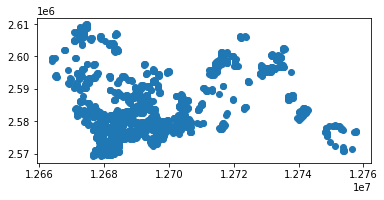

In [17]:
entrance_merged.plot()

In [436]:
# 对绿地的多边形应用一个30米的缓冲区
green_buffer30m = green_space[['geometry']].copy()
green_buffer30m['geometry'] = green_space.geometry.buffer(30)

# 使用overlay方法裁剪路网
clipped_walk_roadnet = gpd.overlay(G_walk_edges_proj, green_buffer30m, how='intersection')

In [437]:
clipped_walk_roadnet

osmid      highway  oneway reversed  length name tunnel bridge  \
0      440355795      service   False    False  312.05  NaN    NaN    NaN   
1      690888797    secondary   False    False  580.50  叠杨线    NaN    NaN   
2      690888797    secondary   False     True  275.13  叠杨线    NaN    NaN   
3      440355795      service   False     True  312.05  NaN    NaN    NaN   
4      440355805      service   False     True  120.25  NaN    NaN    NaN   
...          ...          ...     ...      ...     ...  ...    ...    ...   
28109  966984191  residential   False    False  144.43  NaN    NaN    NaN   
28110  966984191  residential   False     True   89.69  NaN    NaN    NaN   
28111  966984162  residential   False    False  268.30  NaN    NaN    NaN   
28112  966984191  residential   False     True  144.43  NaN    NaN    NaN   
28113  966984191  residential   False    False   89.69  NaN    NaN    NaN   

      service lanes   ref access maxspeed junction width landuse  \
0         NaN   NaN   NaN    NaN       40      NaN   NaN     NaN   
1         NaN   NaN  X260    NaN      NaN      NaN   NaN     NaN   
2         NaN   NaN  X260    NaN      NaN      NaN   NaN     NaN   
3         NaN   NaN   NaN    NaN       40      NaN   NaN     NaN   
4         NaN   NaN   NaN    NaN      NaN      NaN   NaN     NaN   
...       ...   ...   ...    ...      ...      ...   ...     ...   
28109     NaN   NaN   NaN    NaN      NaN      NaN   NaN     NaN   
28110     NaN   NaN   NaN    NaN      NaN      NaN   NaN     NaN   
28111     NaN   NaN   NaN    NaN      NaN      NaN   NaN     NaN   
28112     NaN   NaN   NaN    NaN      NaN      NaN   NaN     NaN   
28113     NaN   NaN   NaN    NaN      NaN      NaN   NaN     NaN   

                                                geometry  
0      LINESTRING (12751716.566 2578599.769, 12751717...  
1      LINESTRING (12751716.566 2578599.769, 12752167...  
2      LINESTRING (12751716.566 2578599.769, 12751693...  
3      LINESTRING (12751718.429 2578624.157, 12751717...  
4      LINESTRING (12752339.198 2578510.641, 12752321...  
...                                                  ...  
28109  LINESTRING (12672478.807 2607951.162, 12672500...  
28110  LINESTRING (12672478.807 2607951.162, 12672393...  
28111  LINESTRING (12672478.807 2607951.162, 12672488...  
28112  LINESTRING (12672500.453 2607962.884, 12672478...  
28113  LINESTRING (12672393.158 2607904.780, 12672478...  

[28114 rows x 17 columns]

In [434]:
clipped_walk_roadnet[['geometry']].to_file('outputdata/clipwalk.geojson')

In [385]:
start_time = time.time()

# Calculate the fake entrance of each park, usting the intersection of buffered park and roadnet

entrance = []
             
# # use the intersection points: the road network and buffered park polygon
# add the buffer of 20m for each components
green_space['buffer_20m'] = green_space['geometry'].buffer(20)

for i in range(len(green_space)):
    green_area = green_space.loc[i,'geometry'].area
    intersection = green_space['buffer_20m'][i].boundary.intersection(edges_walk)
    try:
        for point in intersection:
            dic = {'geometry': point, 'area': park_area, 'park_id': i}
            entrance.append(dic)
    except: continue
fake_entrance_walk = gpd.GeoDataFrame(entrance)

# # if the distance of two fake entrances is less than 50m, then keep the first entrance
# fake_entrance_walk['buffer_25m'] = fake_entrance_walk['geometry'].buffer(25)
# w_e = libpysal.weights.fuzzy_contiguity(fake_entrance_walk['buffer_25m'])
# fake_entrance_walk['entrance_components']= w_e.component_labels
# # Delete duplicate rows based on specific columns 
# fake_entrance_walk = fake_entrance_walk.drop_duplicates(subset=["entrance_components"], keep='first')
# fake_entrance_walk = fake_entrance_walk.reset_index(drop=True)
# fake_entrance_walk.drop(columns="buffer_25m", inplace=True)

# fake_entrance_walk['count'] = fake_entrance_walk.groupby('park_id')['park_id'].transform('count')
# fake_entrance_walk['avg_area'] = fake_entrance_walk['area'] / fake_entrance_walk['count']
    
end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, " mins")

/tmp/ipykernel_88/4036184697.py:15: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for point in intersection:


Run time:  18.35292143424352  mins


In [392]:
fake_entrance_walk

Empty GeoDataFrame
Columns: []
Index: []

In [ ]:
# if the distance of two fake entrances is less than 50m, then keep the first entrance
fake_entrance_walk['buffer_25m'] = fake_entrance_walk['geometry'].buffer(25)
w_e = libpysal.weights.fuzzy_contiguity(fake_entrance_walk['buffer_25m'])
fake_entrance_walk['entrance_components']= w_e.component_labels
# Delete duplicate rows based on specific columns 
fake_entrance_walk = fake_entrance_walk.drop_duplicates(subset=["entrance_components"], keep='first')
fake_entrance_walk = fake_entrance_walk.reset_index(drop=True)
fake_entrance_walk.drop(columns="buffer_25m", inplace=True)


In [ ]:
fake_entrance_walk['count'] = fake_entrance_walk.groupby('park_id')['park_id'].transform('count')
fake_entrance_walk['avg_area'] = fake_entrance_walk['area'] / fake_entrance_walk['count']

In [398]:
green_space

geometry        area  \
0    POLYGON ((12676385.375 2569222.204, 12676406.3...     2270.18   
1    POLYGON ((12679027.243 2569266.514, 12679034.8...     4009.99   
2    POLYGON ((12677170.901 2569528.728, 12677157.0...     8847.14   
3    POLYGON ((12676638.349 2569987.567, 12676667.9...     5363.40   
4    POLYGON ((12677276.120 2570642.746, 12677265.6...     2370.82   
..                                                 ...         ...   
403  POLYGON ((12688774.678 2576889.372, 12688685.0...   311679.02   
404  POLYGON ((12694354.868 2582665.410, 12694402.1... 22902022.38   
405  POLYGON ((12740253.597 2580768.333, 12740202.5...  5026383.36   
406  POLYGON ((12702472.964 2587659.998, 12702453.3...  1610088.65   
407  POLYGON ((12720963.622 2597654.660, 12721153.9...  1507821.27   

          park_type                                         buffer_20m  
0    community_park  POLYGON ((12676361.455 2569105.336, 12676361.3...  
1    community_park  POLYGON ((12679029.307 2569286.407, 12679035.6...  
2    community_park  POLYGON ((12677163.444 2569510.125, 12677150.8...  
3    community_park  POLYGON ((12676628.795 2570005.137, 12676630.4...  
4    community_park  POLYGON ((12677290.616 2570628.966, 12677289.1...  
..              ...                                                ...  
403     nature_park  POLYGON ((12688603.151 2576983.333, 12688642.8...  
404     nature_park  POLYGON ((12689015.044 2579975.952, 12689023.7...  
405     nature_park  POLYGON ((12740268.552 2580748.708, 12740221.6...  
406     nature_park  POLYGON ((12702482.237 2587642.278, 12702480.0...  
407     nature_park  POLYGON ((12720981.689 2597678.495, 12721150.2...  

[408 rows x 4 columns]

In [399]:
# Create a new column 'parkindex' with a sequential index starting from 1
green_space['parkid'] = range(1, len(green_space) + 1)
green_space

geometry        area  \
0    POLYGON ((12676385.375 2569222.204, 12676406.3...     2270.18   
1    POLYGON ((12679027.243 2569266.514, 12679034.8...     4009.99   
2    POLYGON ((12677170.901 2569528.728, 12677157.0...     8847.14   
3    POLYGON ((12676638.349 2569987.567, 12676667.9...     5363.40   
4    POLYGON ((12677276.120 2570642.746, 12677265.6...     2370.82   
..                                                 ...         ...   
403  POLYGON ((12688774.678 2576889.372, 12688685.0...   311679.02   
404  POLYGON ((12694354.868 2582665.410, 12694402.1... 22902022.38   
405  POLYGON ((12740253.597 2580768.333, 12740202.5...  5026383.36   
406  POLYGON ((12702472.964 2587659.998, 12702453.3...  1610088.65   
407  POLYGON ((12720963.622 2597654.660, 12721153.9...  1507821.27   

          park_type                                         buffer_20m  parkid  
0    community_park  POLYGON ((12676361.455 2569105.336, 12676361.3...       1  
1    community_park  POLYGON ((12679029.307 2569286.407, 12679035.6...       2  
2    community_park  POLYGON ((12677163.444 2569510.125, 12677150.8...       3  
3    community_park  POLYGON ((12676628.795 2570005.137, 12676630.4...       4  
4    community_park  POLYGON ((12677290.616 2570628.966, 12677289.1...       5  
..              ...                                                ...     ...  
403     nature_park  POLYGON ((12688603.151 2576983.333, 12688642.8...     404  
404     nature_park  POLYGON ((12689015.044 2579975.952, 12689023.7...     405  
405     nature_park  POLYGON ((12740268.552 2580748.708, 12740221.6...     406  
406     nature_park  POLYGON ((12702482.237 2587642.278, 12702480.0...     407  
407     nature_park  POLYGON ((12720981.689 2597678.495, 12721150.2...     408  

[408 rows x 5 columns]

In [402]:
import geopandas as gpd
from shapely.ops import unary_union

# 假设 green_space 是面数据 GeoDataFrame，有 'geometry'、'park_area' 和 'parkid' 列
# 假设 edges_walk 是 MultiLineString 数据集

# 添加缓冲区列
# green_space['buffer_20m'] = green_space['geometry'].buffer(20)

# 合并 edges_walk 中的 MultiLineString 成为一个单一的几何图形，加速交叉点计算
edges_merged = unary_union(edges_walk)

# 存储交叉点的列表
entrance = []

# 计算每个缓冲后的几何图形与 edges_walk 的交叉点
for idx, row in green_space.iterrows():
    park_area = row['area']
    parkid = row['parkid']
    intersection = row['buffer_20m'].intersection(edges_merged)
    
    # 如果有交叉点，添加到结果列表中
    if not intersection.is_empty:
        if intersection.type == 'MultiPoint':
            for point in intersection:
                entrance.append({'park_area': park_area, 'parkid': parkid, 'geometry': point})
        else:
            entrance.append({'park_area': park_area, 'parkid': parkid, 'geometry': intersection})

# 生成包含交叉点的新 GeoDataFrame
fake_entrance_walk = gpd.GeoDataFrame(entrance, geometry='geometry', crs=green_space.crs)
fake_entrance_walk

park_area  parkid                                           geometry
0       2270.18       1  MULTILINESTRING ((12676416.273 2569234.883, 12...
1       4009.99       2  MULTILINESTRING ((12679139.249 2569297.925, 12...
2       8847.14       3  MULTILINESTRING ((12677246.775 2569609.310, 12...
3       5363.40       4  MULTILINESTRING ((12676687.311 2569996.701, 12...
4       2370.82       5  MULTILINESTRING ((12677223.377 2570683.823, 12...
..          ...     ...                                                ...
387   311679.02     404  MULTILINESTRING ((12688347.621 2577339.812, 12...
388 22902022.38     405  MULTILINESTRING ((12689042.111 2579982.416, 12...
389  5026383.36     406  MULTILINESTRING ((12740009.846 2580443.402, 12...
390  1610088.65     407  MULTILINESTRING ((12702594.517 2587700.726, 12...
391  1507821.27     408  MULTILINESTRING ((12720146.508 2597160.495, 12...

[392 rows x 3 columns]

In [403]:
fake_entrance_walk.to_file('outputdata/fake_entrance_walk.geojson')

In [405]:
# edges_walk = G_walk_edges_proj.unary_union 
overlapping = gpd.overlay(G_walk_edges_proj, green_space, how='intersection')

# overlap = green_space.geometry.unary_union.intersection(G_walk_edges_proj.geometry.unary_union)

/tmp/ipykernel_88/3132117753.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 268 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlapping = gpd.overlay(G_walk_edges_proj, green_space, how='intersection')


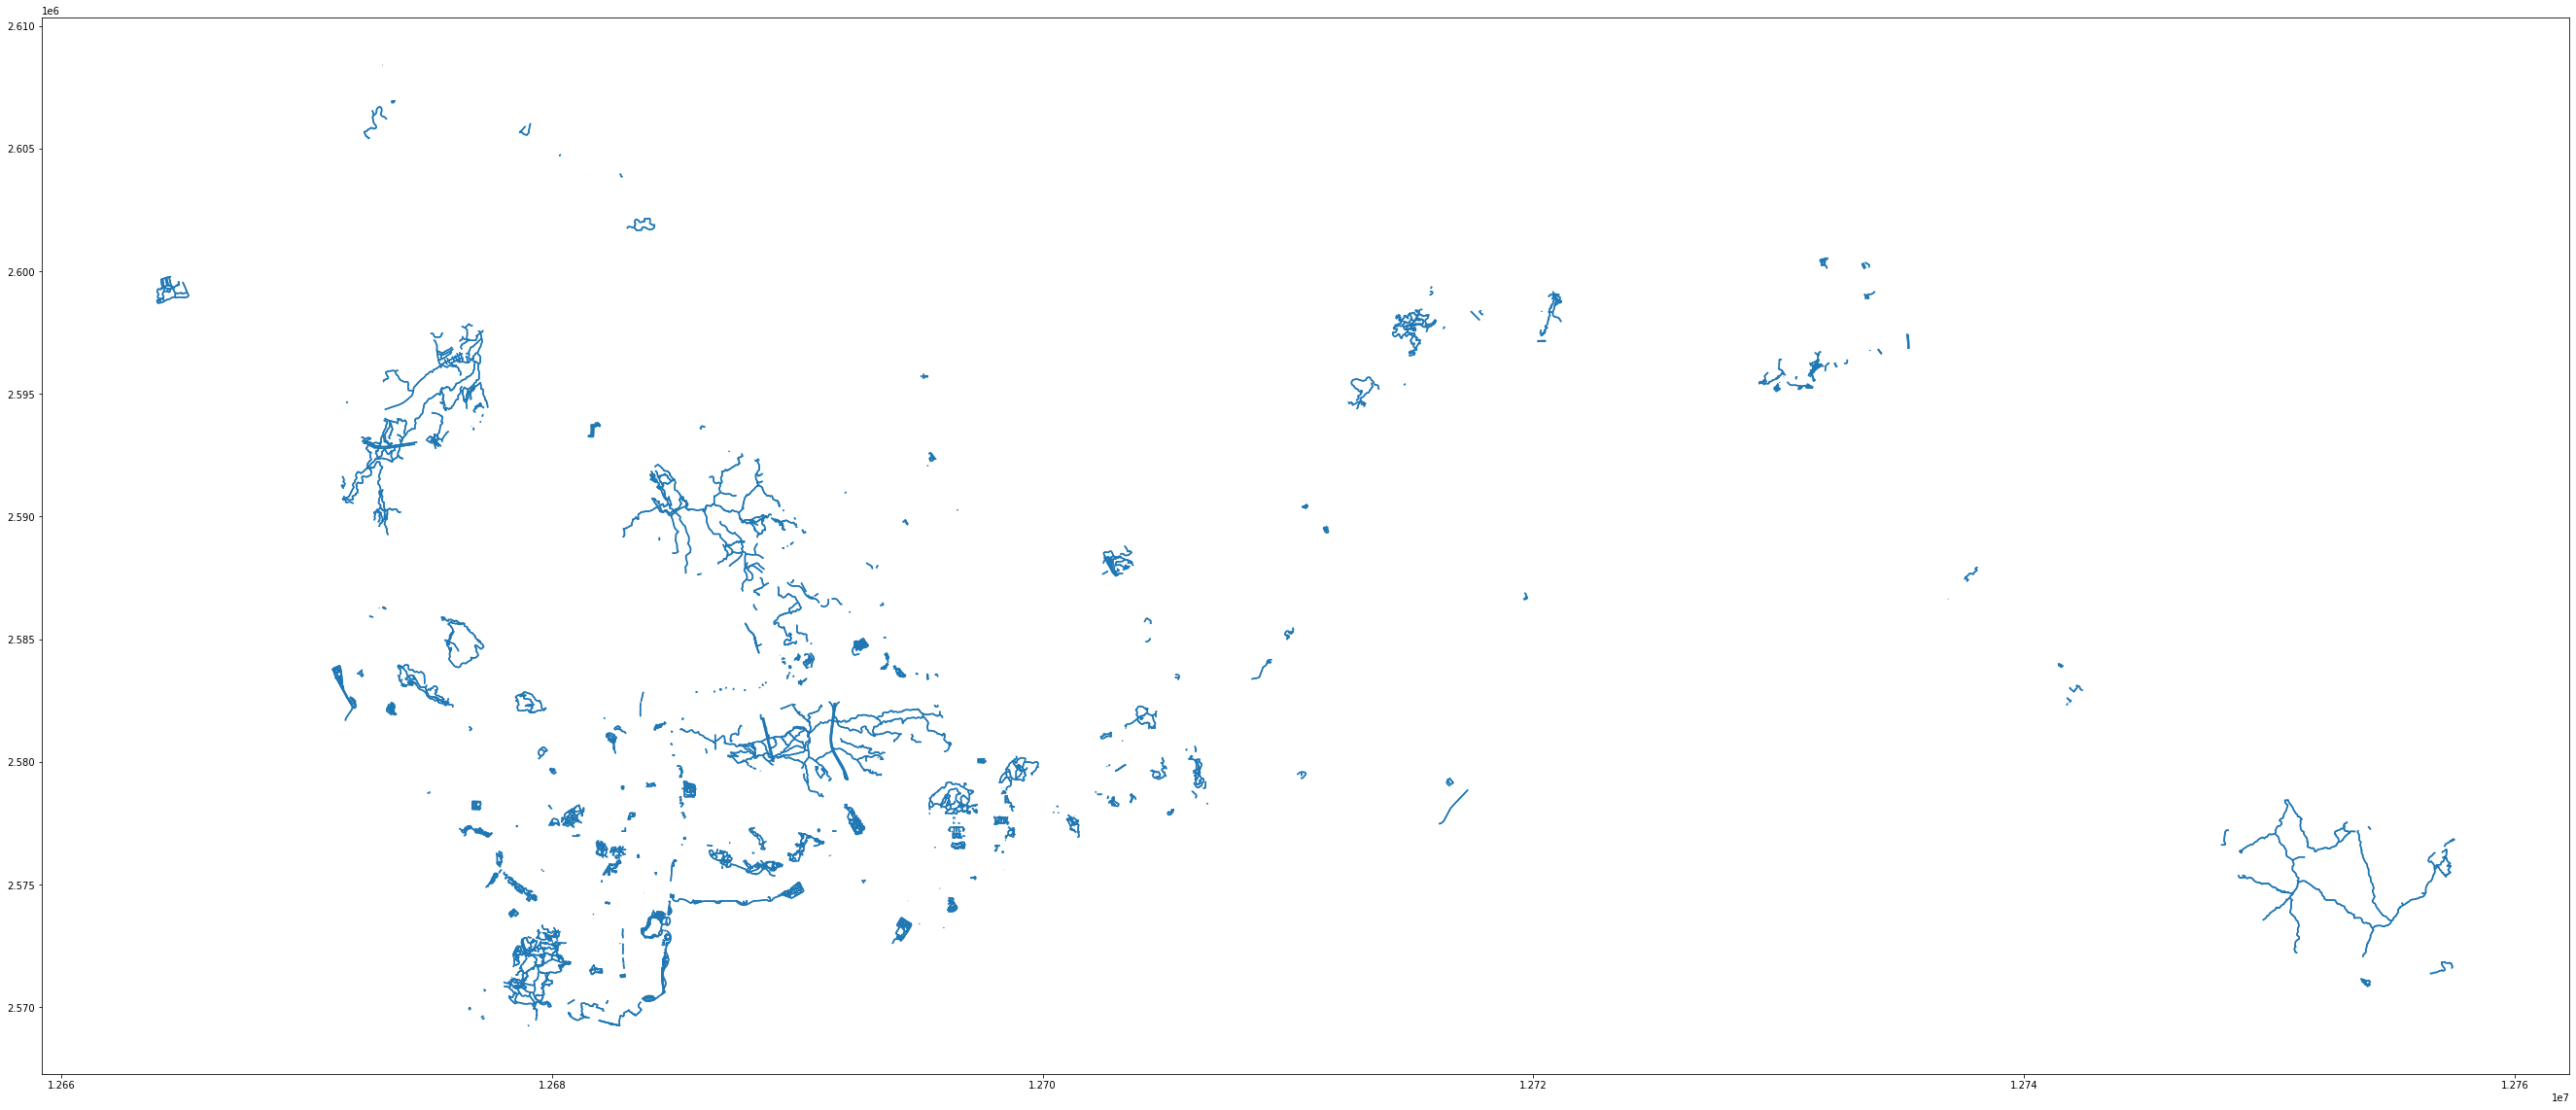

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))
overlapping.plot(ax=ax)
plt.show()

In [404]:
print(type(G_walk_edges_proj))
print(type(green_space))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [ ]:
# Check detalis
print(fake_entrance_walk.crs)
print('----------------------------------------------------------------------')
print(fake_entrance_walk.info())
print('----------------------------------------------------------------------')
print(fake_entrance_walk)
print('----------------------------------------------------------------------')
print(fake_entrance_walk.describe())

In [ ]:
fake_entrance_walk.plot()

In [ ]:
# if the distance of two fake entrances is less than 50m, then keep the first entrance
fake_entrance_walk['buffer_25m'] = fake_entrance_walk['geometry'].buffer(25)
w_e = libpysal.weights.fuzzy_contiguity(fake_entrance_walk['buffer_25m'])
fake_entrance_walk['entrance_components']= w_e.component_labels
# Delete duplicate rows based on specific columns 
fake_entrance_walk = fake_entrance_walk.drop_duplicates(subset=["entrance_components"], keep='first')
fake_entrance_walk = fake_entrance_walk.reset_index(drop=True)
fake_entrance_walk.drop(columns="buffer_25m", inplace=True)

fake_entrance_walk['count'] = fake_entrance_walk.groupby('park_id')['park_id'].transform('count')
fake_entrance_walk['avg_area'] = fake_entrance_walk['area'] / fake_entrance_walk['count']

## 1.4 Read population grid data

Raw population dataset  is from [Worldpop]( https://hub.worldpop.org/geodata/summary?id=6524),   
dataset name is 'The spatial distribution of population in 2020, China',   
file name before QGIS preprocessing is 'chn_ppp_2020.tif'. 
  
Resolution = 100m,  
Region : China,   
Date of production : 2018-11-01,   
DOI : 10.5258/SOTON/WP00645.  
  
Processing into 500m^500m grid data using QGIS, QGIS version is 3.26.3-Buenos Aires.  

### pop

In [51]:
# Read population data
pop_raw = gpd.read_file('shenzhen_pop_500mcell.gpkg')
pop_raw = pop_raw.to_crs(epsg = 4326)

In [52]:
pop_raw.head(3)

id          left           top         right        bottom  _count  \
0  423  1.266469e+07  2.601575e+06  1.266519e+07  2.601075e+06    10.0   
1  424  1.266469e+07  2.601075e+06  1.266519e+07  2.600575e+06    24.0   
2  425  1.266469e+07  2.600575e+06  1.266519e+07  2.600075e+06    16.0   

         _sum                                           geometry  
0  295.485788  POLYGON ((113.76885 22.74802, 113.77334 22.748...  
1  798.601546  POLYGON ((113.76885 22.74388, 113.77334 22.743...  
2  879.025357  POLYGON ((113.76885 22.73974, 113.77334 22.739...

In [53]:
pop = pop_raw[(pop_raw['_sum'] >= 10)]
pop['polygonStr'] = pop['geometry'].astype('str')
pop['geometry'] = pop['geometry'].centroid
pop['Popid'] = pop.index + 1

In [54]:
pop.columns

Index(['id', 'left', 'top', 'right', 'bottom', '_count', '_sum', 'geometry',
       'polygonStr', 'Popid'],
      dtype='object')

In [55]:
pop = pop[['_sum', 'geometry','polygonStr', 'Popid']]

In [56]:
pop.rename(columns={'_sum': 'popsum'}, inplace=True)

In [57]:
pop['longitude'] = pop['geometry'].x
pop['latitude'] = pop['geometry'].y

In [58]:
pop

popsum                    geometry  \
0     295.485788  POINT (113.77109 22.74595)   
1     798.601546  POINT (113.77109 22.74181)   
2     879.025357  POINT (113.77109 22.73767)   
3     197.557260  POINT (113.77109 22.73352)   
4      43.000634  POINT (113.77109 22.71695)   
...          ...                         ...   
9068   40.433002  POINT (114.61551 22.50964)   
9069   26.631323  POINT (114.61551 22.50549)   
9070   28.871598  POINT (114.62000 22.51794)   
9071   45.986063  POINT (114.62000 22.51379)   
9072   29.344752  POINT (114.62000 22.50964)   

                                             polygonStr  Popid   longitude  \
0     POLYGON ((113.768849 22.748023, 113.77334 22.7...      1  113.771095   
1     POLYGON ((113.768849 22.743881, 113.77334 22.7...      2  113.771095   
2     POLYGON ((113.768849 22.739739, 113.77334 22.7...      3  113.771095   
3     POLYGON ((113.768849 22.735596, 113.77334 22.7...      4  113.771095   
4     POLYGON ((113.768849 22.719025, 113.77334 22.7...      5  113.771095   
...                                                 ...    ...         ...   
9068  POLYGON ((114.613265 22.511715, 114.617757 22....   9069  114.615511   
9069  POLYGON ((114.613265 22.507565, 114.617757 22....   9070  114.615511   
9070  POLYGON ((114.617757 22.520013, 114.622248 22....   9071  114.620003   
9071  POLYGON ((114.617757 22.515864, 114.622248 22....   9072  114.620003   
9072  POLYGON ((114.617757 22.511715, 114.622248 22....   9073  114.620003   

       latitude  
0     22.745952  
1     22.741810  
2     22.737667  
3     22.733525  
4     22.716953  
...         ...  
9068  22.509640  
9069  22.505490  
9070  22.517938  
9071  22.513789  
9072  22.509640  

[9073 rows x 6 columns]

In [59]:
pop.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [60]:
pop.to_csv('popgrid.csv',index = False, encoding = 'utf-8')

In [61]:
pop.to_file('pop.geojson')

### pop_resid

In [1305]:
pop_resid = gpd.read_file('residential_pop.shp') 
pop_resid = pop_resid.to_crs(epsg = 4326)

pop_resid = pop_resid[(pop_resid['sum_pop'] >= 1)]
pop_resid['cen'] = pop_resid['geometry'].centroid
pop_resid['Popid'] = pop_resid.index + 1

pop_resid['longitude'] = pop_resid['cen'].x
pop_resid['latitude'] = pop_resid['cen'].y

In [1306]:
pop_resid = pop_resid.to_crs(epsg = 3857)
pop_resid['area'] = pop_resid.geometry.area

In [1307]:
pop_resid

name       sum_pop                                           geometry  \
0       None   7276.136558  POLYGON ((12742557.833 2583965.856, 12742480.9...   
1       None   1217.979429  POLYGON ((12745413.133 2576195.874, 12745295.9...   
3      ?????   2048.236732  POLYGON ((12709691.109 2588710.751, 12709781.1...   
4       None  11243.644833  POLYGON ((12702176.654 2585733.443, 12702091.5...   
5       None    875.631427  POLYGON ((12711043.062 2583066.362, 12711070.5...   
...      ...           ...                                                ...   
2076    ????    325.056286  POLYGON ((12690104.222 2594879.791, 12690110.1...   
2077     ???   6592.324279  POLYGON ((12668653.302 2594538.785, 12668256.1...   
2078    ????   1589.763618  POLYGON ((12685408.176 2594097.317, 12685432.6...   
2079    ????    149.804736  POLYGON ((12688879.018 2592578.554, 12688876.6...   
2080  ??????    305.918748  POLYGON ((12692823.479 2595708.323, 12692891.1...   

                             cen  Popid   longitude   latitude          area  
0     POINT (114.47232 22.59552)      1  114.472319  22.595523  2.228591e+06  
1     POINT (114.48832 22.53681)      2  114.488317  22.536814  6.199168e+05  
3     POINT (114.17423 22.63940)      4  114.174231  22.639398  2.236799e+05  
4     POINT (114.10326 22.61540)      5  114.103263  22.615398  4.572930e+05  
5     POINT (114.18960 22.59443)      6  114.189601  22.594434  3.634558e+05  
...                          ...    ...         ...        ...           ...  
2076  POINT (113.99786 22.69175)   2077  113.997858  22.691749  1.643225e+04  
2077  POINT (113.80420 22.69361)   2078  113.804203  22.693606  3.842189e+05  
2078  POINT (113.95554 22.68481)   2079  113.955540  22.684806  8.869985e+04  
2079  POINT (113.98661 22.67397)   2080  113.986614  22.673974  5.573208e+03  
2080  POINT (114.02230 22.69804)   2081  114.022299  22.698042  4.549872e+04  

[1828 rows x 8 columns]

## Plot

### fig: adminstraive boundary

In [ ]:
subdistrict = gpd.read_file('Subdistrict_Shenzhen.geojson').to_crs(epsg=3857)
district = gpd.read_file('District_Shenzhen.geojson').to_crs(epsg=3857)

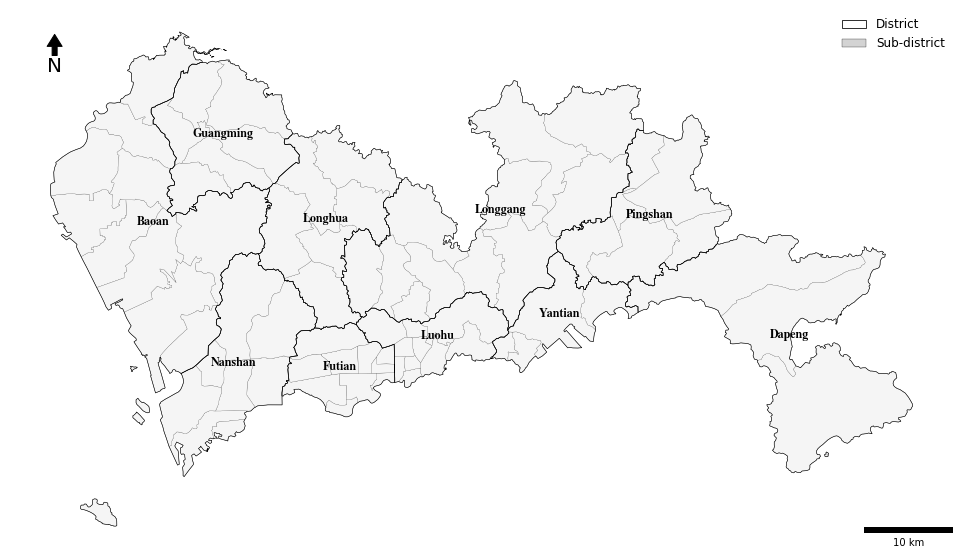

In [1324]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(20, 10))

# 绘制 subdistrict 作为底图，填充颜色和边界颜色
subdistrict.plot(ax=ax, facecolor='#f5f5f5', edgecolor='black', linewidth=0.15)
district.boundary.plot(ax=ax, color='black', linewidth=0.6)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 自定义图例元素
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='lightgray', edgecolor='black', linewidth=0.3, label='Sub-district')]

# 添加自定义图例并获取图例对象
custom_legend = ax.legend(handles=legend_elements, loc='upper right', prop={'size': 12})

# 删除自定义图例的边框
frame = custom_legend.get_frame()
frame.set_visible(False)

plt.savefig("tmp/adminstraive boundary.png", dpi=300, bbox_inches='tight')

plt.show()


### fig: park

In [1331]:
community_park = gpd.read_file('outputdata/community_park.geojson').to_crs(epsg=3857)
city_park = gpd.read_file('outputdata/city_park.geojson').to_crs(epsg=3857)
nature_park = gpd.read_file('outputdata/nature_park.geojson').to_crs(epsg=3857)

In [2156]:
community_park_entrance = gpd.read_file('community_park_entrance.geojson').to_crs(epsg=3857)
city_park_entrance = gpd.read_file('city_park_entrance.geojson').to_crs(epsg=3857)
nature_park_entrance = gpd.read_file('nature_park_entrance.geojson').to_crs(epsg=3857)

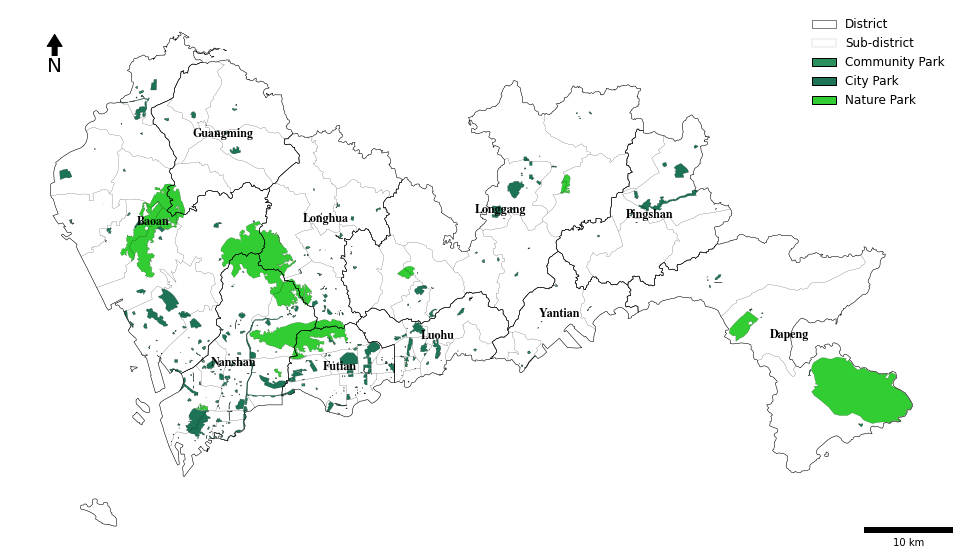

In [1348]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(20, 10))

# 绘制subdistrict，只绘制边界
subdistrict.boundary.plot(ax=ax, color='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.5)

# 绘制三个公园，为每个公园设置不同的绿色
community_park.plot(ax=ax, color='#2a915e', edgecolor='black', linewidth=0.3)  # 浅绿色
city_park.plot(ax=ax, color='#1d7356', edgecolor='black', linewidth=0.15)  # 深绿色
nature_park.plot(ax=ax, color='#32CD32', edgecolor='black', linewidth=0.15)  # 亮绿色

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 自定义图例元素
legend_elements = [
    Patch(facecolor='none', edgecolor='black', linewidth=0.5, label='District'),
    Patch(facecolor='none', edgecolor='black', linewidth=0.1, label='Sub-district'),
    Patch(facecolor='#2a915e', edgecolor='black', label='Community Park'),
    Patch(facecolor='#1d7356', edgecolor='black', label='City Park'),
    Patch(facecolor='#32CD32', edgecolor='black', label='Nature Park')
]

# 添加自定义图例并获取图例对象
custom_legend = ax.legend(handles=legend_elements, loc='upper right', prop={'size': 12})

# 删除自定义图例的边框
frame = custom_legend.get_frame()
frame.set_visible(False)

plt.savefig("tmp/shenzhen_park.png", dpi=300, bbox_inches='tight')

plt.show()


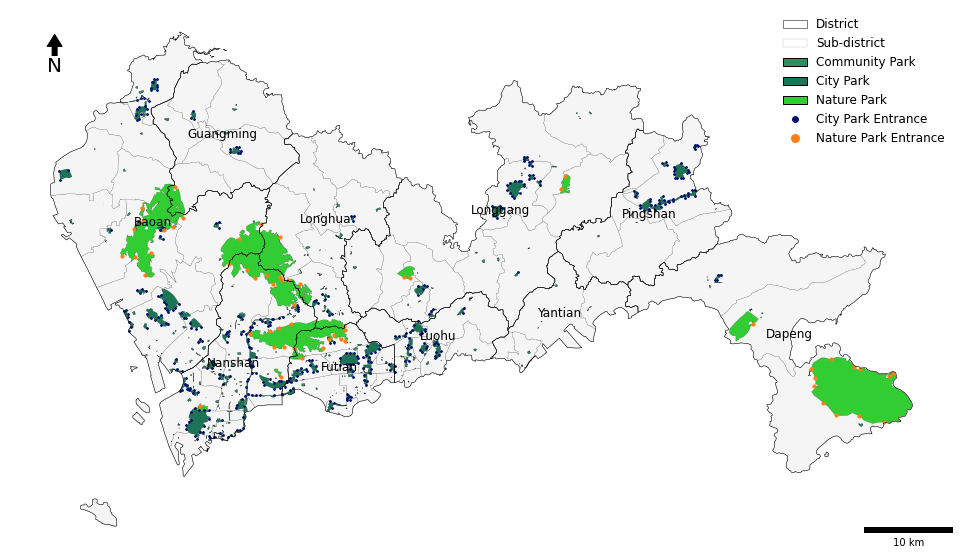

In [2185]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 10))

# 绘制subdistrict，只绘制边界
subdistrict.plot(ax=ax, facecolor='#f5f5f5', edgecolor='black', linewidth=0.15)
district.boundary.plot(ax=ax, color='black', linewidth=0.5)

# 绘制三个公园
community_park.plot(ax=ax, color='#2a915e', edgecolor='black', linewidth=0.3)
city_park.plot(ax=ax, color='#1d7356', edgecolor='black', linewidth=0.15)
nature_park.plot(ax=ax, color='#32CD32', edgecolor='black', linewidth=0.15)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center')

# 绘制 city_park_entrance 和 nature_park_entrance 的点
city_marker = ax.scatter(city_park_entrance.geometry.x, city_park_entrance.geometry.y, color='#000e69', s=3, label='City Park Entrance')
nature_marker = ax.scatter(nature_park_entrance.geometry.x, nature_park_entrance.geometry.y, color='#ff7f0e', s=10, label='Nature Park Entrance')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 自定义图例元素
legend_elements = [
    Patch(facecolor='none', edgecolor='black', linewidth=0.5, label='District'),
    Patch(facecolor='none', edgecolor='black', linewidth=0.1, label='Sub-district'),
    Patch(facecolor='#2a915e', edgecolor='black', label='Community Park'),
    Patch(facecolor='#1d7356', edgecolor='black', label='City Park'),
    Patch(facecolor='#32CD32', edgecolor='black', label='Nature Park'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#000e69', markersize=8, label='City Park Entrance'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=10, label='Nature Park Entrance')
]

# 添加自定义图例并获取图例对象
custom_legend = ax.legend(handles=legend_elements, loc='upper right', prop={'size': 12})

# 删除自定义图例的边框
frame = custom_legend.get_frame()
frame.set_visible(False)

plt.savefig("tmp/shenzhen_park.png", dpi=300, bbox_inches='tight')

plt.show()


### fig: pop

In [1342]:
pop = gpd.read_file('pop.geojson').to_crs(epsg=3857)

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

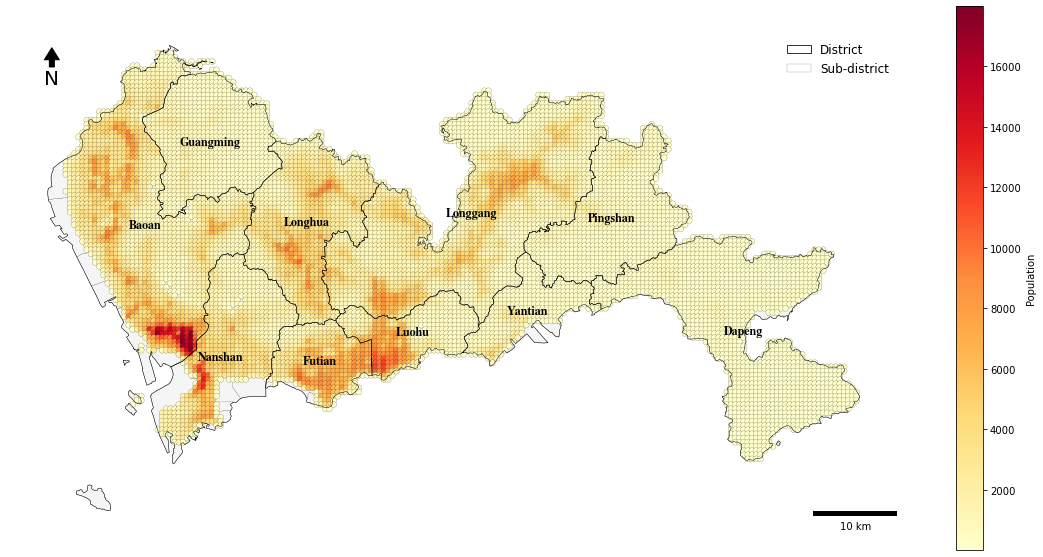

In [2052]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 10))

# 绘制subdistrict，只绘制边界
subdistrict.plot(ax=ax, facecolor='#f5f5f5', edgecolor='black', linewidth=0.15)

# popsum
pop.plot(ax=ax, column='popsum', cmap='YlOrRd', 
         legend=True, 
         edgecolor='black', 
         linewidth=0.15,
         legend_kwds={'label': "Population"})

# 绘制district，只绘制边界
district.boundary.plot(ax=ax, color='black', linewidth=0.5)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 自定义图例元素
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

ax.legend(handles=legend_elements, 
          loc='upper right', prop={'size': 12}, 
          frameon=False, bbox_to_anchor=(1, 0.98))


# Add the legend manually to the current Axes.
ax.add_artist(legend1)

# plt.savefig("tmp/popgrid.png", dpi=300, bbox_inches='tight')

plt.show()


### fig: pop_resid

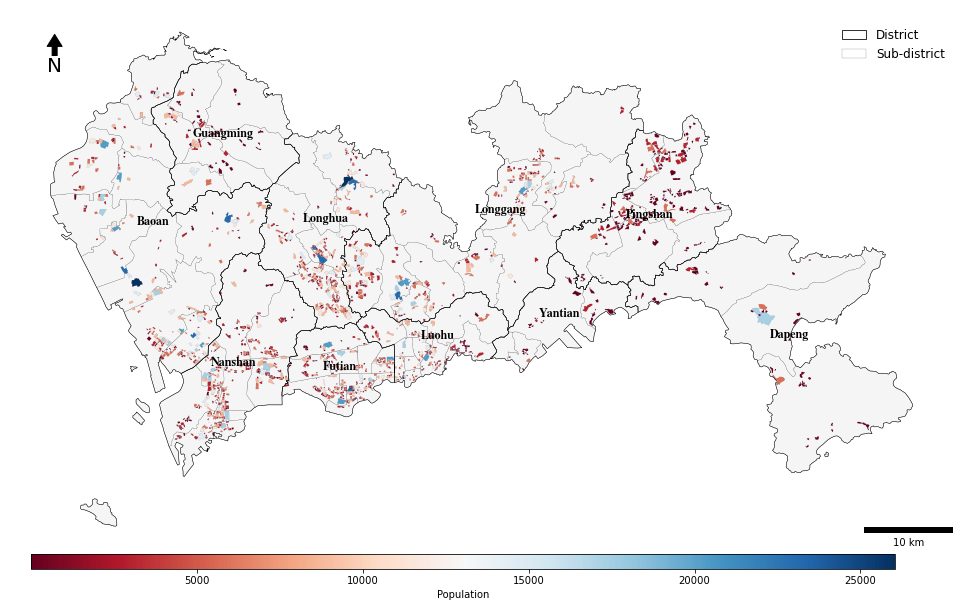

In [2053]:
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 绘制subdistrict，只绘制边界
subdistrict.plot(ax=ax, facecolor='#f5f5f5', edgecolor='black', linewidth=0.15)

# 使用自然界限分段
classifier = mapclassify.NaturalBreaks(pop_resid['sum_pop'], k=10)
pop_resid['classification'] = classifier(pop_resid['sum_pop'])

# 使用分段结果绘图
pop_resid.plot(ax=ax, column='classification', cmap='RdBu',
               legend=False,
               edgecolor='black',
               linewidth=0.05)

district.boundary.plot(ax=ax, color='black', linewidth=0.5)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 自定义图例元素
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

ax.legend(handles=legend_elements, 
          loc='upper right', prop={'size': 12}, 
          frameon=False, bbox_to_anchor=(1, 0.98))


# 创建色带图例
norm = Normalize(vmin=pop_resid['sum_pop'].min(), vmax=pop_resid['sum_pop'].max())
cax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # 调整这些数字以改变色带的位置和大小
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdBu'), cax=cax, orientation='horizontal')
cb.set_label('Population')

plt.savefig("tmp/pop_resid.png", dpi=300, bbox_inches='tight')

plt.show()


In [2279]:
pop

popsum                                         polygonStr  Popid  \
0     295.485788  POLYGON ((113.768849 22.748023, 113.77334 22.7...      1   
1     798.601546  POLYGON ((113.768849 22.743881, 113.77334 22.7...      2   
2     879.025357  POLYGON ((113.768849 22.739739, 113.77334 22.7...      3   
3     197.557260  POLYGON ((113.768849 22.735596, 113.77334 22.7...      4   
4      43.000634  POLYGON ((113.768849 22.719025, 113.77334 22.7...      5   
...          ...                                                ...    ...   
9068   40.433002  POLYGON ((114.613265 22.511715, 114.617757 22....   9069   
9069   26.631323  POLYGON ((114.613265 22.507565, 114.617757 22....   9070   
9070   28.871598  POLYGON ((114.617757 22.520013, 114.622248 22....   9071   
9071   45.986063  POLYGON ((114.617757 22.515864, 114.622248 22....   9072   
9072   29.344752  POLYGON ((114.617757 22.511715, 114.622248 22....   9073   

       longitude   latitude                          geometry  
0     113.771095  22.745952  POINT (12664940.318 2601324.609)  
1     113.771095  22.741810  POINT (12664940.318 2600824.609)  
2     113.771095  22.737667  POINT (12664940.318 2600324.609)  
3     113.771095  22.733525  POINT (12664940.318 2599824.609)  
4     113.771095  22.716953  POINT (12664940.318 2597824.609)  
...          ...        ...                               ...  
9068  114.615511  22.509640  POINT (12758940.318 2572824.609)  
9069  114.615511  22.505490  POINT (12758940.318 2572324.609)  
9070  114.620003  22.517938  POINT (12759440.318 2573824.609)  
9071  114.620003  22.513789  POINT (12759440.318 2573324.609)  
9072  114.620003  22.509640  POINT (12759440.318 2572824.609)  

[9073 rows x 6 columns]

### fig.pop density

In [2287]:
merged

OBJECTID  Name    Shape_Area  \
0          1  沙河街道  2.191777e+07   
0          1  沙河街道  2.191777e+07   
0          1  沙河街道  2.191777e+07   
0          1  沙河街道  2.191777e+07   
0          1  沙河街道  2.191777e+07   
..       ...   ...           ...   
73        30  坑梓街道  6.300140e+07   
73        30  坑梓街道  6.300140e+07   
73        30  坑梓街道  6.300140e+07   
73        30  坑梓街道  6.300140e+07   
73        30  坑梓街道  6.300140e+07   

                                             geometry  index_right   name  \
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...         1571  ?????   
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...          704   None   
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...         1113   ????   
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...          707   None   
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...          678    ???   
..                                                ...          ...    ...   
73  MULTIPOLYGON (((12738814.537 2595221.214, 1273...          372   None   
73  MULTIPOLYGON (((12738814.537 2595221.214, 1273...          373   None   
73  MULTIPOLYGON (((12738814.537 2595221.214, 1273...          374   None   
73  MULTIPOLYGON (((12738814.537 2595221.214, 1273...          375   None   
73  MULTIPOLYGON (((12738814.537 2595221.214, 1273...          376   None   

        sum_pop                         cen  Popid   longitude   latitude  \
0   1290.973551  POINT (113.96068 22.53103)   1819  113.960681  22.531032   
0    860.703619  POINT (113.96462 22.53417)    764  113.964621  22.534174   
0   1921.136970  POINT (113.97461 22.53522)   1270  113.974614  22.535219   
0   1791.310913  POINT (113.96058 22.53656)    768  113.960584  22.536560   
0   3516.947496  POINT (113.96348 22.53660)    732  113.963483  22.536598   
..          ...                         ...    ...         ...        ...   
73   150.242035  POINT (114.39561 22.76173)    419  114.395611  22.761733   
73   110.279711  POINT (114.39265 22.76521)    420  114.392650  22.765206   
73   189.251878  POINT (114.39511 22.76609)    421  114.395114  22.766092   
73   108.754158  POINT (114.39824 22.77257)    422  114.398243  22.772570   
73    65.142551  POINT (114.40235 22.77570)    423  114.402352  22.775696   

             area     avg_cost      avg_area  classification  pop_density  
0   187904.705332  1228.865323  1.350981e+06               2     0.000059  
0    53905.878562  1669.466129  1.131496e+06               1     0.000039  
0   191942.599374  1753.010484  1.131496e+06               3     0.000088  
0   122575.426574  1499.379032  1.350981e+06               3     0.000082  
0   181610.378114  1470.904032  1.350981e+06               4     0.000160  
..            ...          ...           ...             ...          ...  
73   39801.752453  1897.050000  4.486132e+05               0     0.000002  
73   37411.491541     0.000000  0.000000e+00               0     0.000002  
73   71349.595104     0.000000  0.000000e+00               0     0.000003  
73   53245.441105     0.000000  0.000000e+00               0     0.000002  
73   50655.807381     0.000000  0.000000e+00               0     0.000001  

[1897 rows x 16 columns]

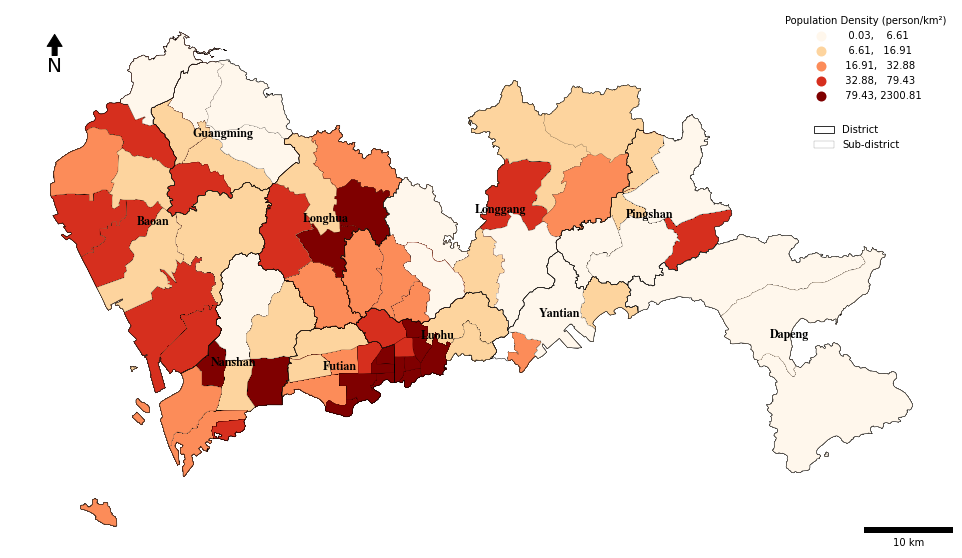

In [2298]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
import mapclassify

# 计算每个 subdistrict 的面积
subdistrict['Shape_Area'] = subdistrict.geometry.area

# 使用 spatial join 合并两个 GeoDataFrame
merged = gpd.sjoin(subdistrict, pop_resid, how="inner", op="intersects")

# 计算人口密度
merged['pop_density'] = merged['sum_pop']*1000000 / merged['Shape_Area']  # assuming your area is in square meters

# 绘图
fig, ax = plt.subplots(figsize=(20, 10))
merged.plot(column='pop_density', scheme='quantiles', k=5, cmap='OrRd', legend=True, ax=ax, 
            edgecolor='black', linewidth=0.1, legend_kwds={'title': 'Population Density (person/km²)'})

# 获取主要的色块图例的引用
legend = ax.get_legend()

ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')
    
district.boundary.plot(ax=ax, color='black', linewidth=0.5)

# 删除图例的边框
if legend:
    frame = legend.get_frame()
    frame.set_visible(False)
    
# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.8), frameon=False)

# 将主要的色块图例添加回来（如果存在）
if legend:
    ax.add_artist(legend)

plt.savefig("tmp/pop_density.png", dpi=300, bbox_inches='tight')

plt.show()


### fig: roadnet

In [ ]:
G_walk_edges_proj = gpd.read_file('outputdata/G_walk_edges_proj.geojson').to_crs(epsg=3857)

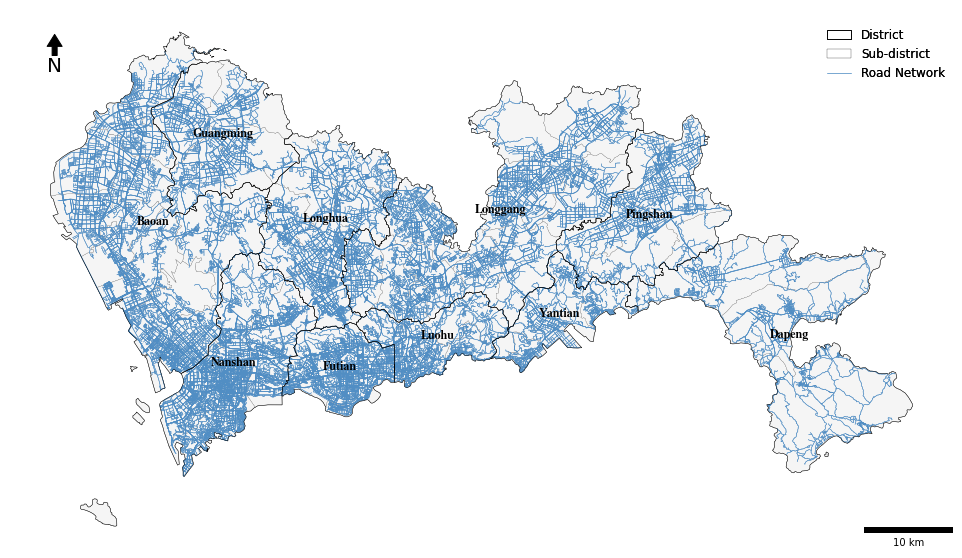

In [2054]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 10))

# 绘制subdistrict，只绘制边界
subdistrict.plot(ax=ax, facecolor='#f5f5f5', edgecolor='black', linewidth=0.15)

# 计算路网与district的交集
clipped_roads = gpd.overlay(G_walk_edges_proj, district, how='intersection')
clipped_roads.plot(ax=ax, color='#518ec4', linewidth=0.5)

# 绘制district
district.boundary.plot(ax=ax, color='black', linewidth=0.5)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 自定义图例元素
legend_elements = [
    Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
    Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district'),
    Line2D([0], [0], color='#518ec4', linewidth=0.5, label='Road Network'),
    Patch(facecolor='none', edgecolor='none')
]

# 添加自定义图例
legend1 = ax.legend(handles=legend_elements, 
                    loc='upper right', prop={'size': 12}, 
                    frameon=False, bbox_to_anchor=(1, 0.98))


# Add the legend manually to the current Axes.
ax.add_artist(legend1)

plt.savefig("tmp/Road networks.png", dpi=300, bbox_inches='tight')

plt.show()

### fig: GINI

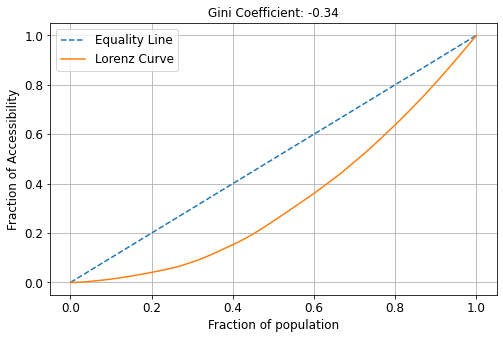

In [2204]:
import numpy as np
import matplotlib.pyplot as plt

def gini_lorenz(y):
    """
    Calculate Gini coefficient and Lorenz curve.
    Args:
    - y (1-D array): Income or wealth data
    
    Returns:
    - (gini, Lx, Ly): Gini coefficient, X & Y points of Lorenz curve
    """
    y = np.sort(y) # sort incomes in increasing order
    n = y.size
    range_n = np.arange(1, n + 1)
    
    # Lorenz curve
    Lx = np.insert(np.cumsum(y) / y.sum(), 0, 0)
    Ly = np.linspace(0.0, 1.0, n + 1)
    
    # Gini coefficient
    gini = 1 - np.sum((Ly[:-1] + Ly[1:]) * np.diff(Lx))
    
    return gini, Ly, Lx

# Sample income data
incomes = np.random.rand(100) * 1000

gini, Ly, Lx = gini_lorenz(incomes)

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], '--', label="Equality Line")
plt.plot(Ly, Lx, label="Lorenz Curve")
plt.title(f"Gini Coefficient: {gini:.2f}", fontsize=12)
plt.xlabel("Fraction of population", fontsize=12)
plt.ylabel("Fraction of Accessibility", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("tmp/GINI&Lorenz intro.png", dpi=300, bbox_inches='tight')

plt.show()


### fig: Gaussian

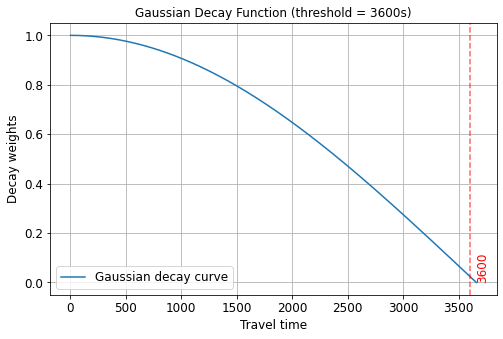

In [2203]:
import math
import numpy as np
import matplotlib.pyplot as plt

# 你给出的高斯函数
def Ga_3600s(dij):
    e = math.exp(1)
    g = (e**(-0.5*(dij/3660)**2) - e**(-0.5)) / (1 - e**(-0.5))
    return g

# 生成距离值
d_values = np.linspace(0, 3660, 400)
g_values = [Ga_3600s(d) for d in d_values]

# 绘制曲线
plt.figure(figsize=(8, 5))
plt.plot(d_values, g_values, label='Gaussian decay curve', linewidth=1.5)

# 绘制3600的垂直线并添加标签
plt.axvline(3600, color='red', linestyle='--', alpha=0.6)
plt.text(3660, min(g_values), '3600', rotation=90, verticalalignment='bottom', fontsize=12, color='red')

plt.title('Gaussian Decay Function (threshold = 3600s)', fontsize=12)
plt.xlabel('Travel time', fontsize=12)
plt.ylabel('Decay weights', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.savefig("tmp/Gaussian.png", dpi=300, bbox_inches='tight')

plt.show()


# 2. Accessibility

Community park 315, entrance 315    
City park 84, entrance 400   
Nature park 9, entrance 89  
Pop residential polygongs, 2081

a) Walking——Community park——Travel time thresholds =10min   
b) Walking——City park——Travel time thresholds =20min   
c) Walking——Natural park——Travel time thresholds =30min   
d) Public transport——City park——Travel time thresholds =30min   
e) Public transport——Natural park——Travel time thresholds =60min   
f) Driving——City park——Travel time thresholds =30min   
g) Driving——Natural park——Travel time thresholds =60min   
d+f) Public transport(45%)/Driving(55%)——City park——Travel time thresholds =30min 

高德api选择路径规划(而不是路径规划2.0)，时间点time = 10:00。（路径规划api计算配额300rmb/10万次/年，免费额度5000次/日.202308）

In [62]:
# 按照经纬度计算距离的函数
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000

In [63]:
# WGS84和GJC坐标系转换函数
# -*- coding: utf-8 -*-
import json
import urllib
import math
# import numpy as np

x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626  # π
a = 6378245.0  # 长半轴
ee = 0.00669342162296594323  # 偏心率平方


'''
输入（经度，维度）
'''
def bd09_to_gcj02(bd_lon, bd_lat):
    """
    百度坐标系(BD-09)转火星坐标系(GCJ-02)
    百度——>谷歌、高德
    :param bd_lat:百度坐标纬度
    :param bd_lon:百度坐标经度
    :return:转换后的坐标列表形式
    """
    x = bd_lon - 0.0065
    y = bd_lat - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    gg_lng = z * math.cos(theta)
    gg_lat = z * math.sin(theta)
    return [gg_lng, gg_lat]
def gcj02_to_wgs84(lng, lat):
    """
    GCJ02(火星坐标系)转GPS84
    :param lng:火星坐标系的经度
    :param lat:火星坐标系纬度
    :return:
    """
    if out_of_china(lng, lat):
        return [lng, lat]
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]
def bd09_to_wgs84(bd_lon, bd_lat):
    lon, lat = bd09_to_gcj02(bd_lon, bd_lat)
    return gcj02_to_wgs84(lon, lat)
def bd09_to_wgs84(bd_lon, bd_lat):
    lon, lat = bd09_to_gcj02(bd_lon, bd_lat)
    return gcj02_to_wgs84(lon, lat)
def gcj02_to_bd09(lng, lat):
    """
    火星坐标系(GCJ-02)转百度坐标系(BD-09)
    谷歌、高德——>百度
    :param lng:火星坐标经度
    :param lat:火星坐标纬度
    :return:
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]
def wgs84_to_gcj02(lng, lat):
    """
    WGS84转GCJ02(火星坐标系)
    :param lng:WGS84坐标系的经度
    :param lat:WGS84坐标系的纬度
    :return:
    """
    if out_of_china(lng, lat):  # 判断是否在国内
        return [lng, lat]
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [mglng, mglat]
def wgs84_to_bd09(lon, lat):
    lon, lat = wgs84_to_gcj02(lon, lat)
    return gcj02_to_bd09(lon, lat)

def out_of_china(lng, lat):
    """
    判断是否在国内，不在国内不做偏移
    :param lng:
    :param lat:
    :return:
    """
    return not (lng > 73.66 and lng < 135.05 and lat > 3.86 and lat < 53.55)

def _transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
          0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *
            math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *
            math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret
def _transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
          0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
            math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
            math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret


In [64]:
print(community_park.crs)
print(city_park.crs)
print(nature_park.crs)
print(pop.crs)

epsg:4326
epsg:4326
epsg:4326
epsg:4326


## Walking 详见apiwalking.ipy

## Public transport 详见api_publictrans.ipy

## Driving

In [292]:
# 调用高德路径规划api-驾车，计算路径距离distance（米），耗时cost（秒）
# 路径规划1.0
import json
from urllib import request

def fetch_GaodeMap_driving(df):
    urlbase = 'https://restapi.amap.com/v3/direction/driving?&key=225cfe7d506a6037debd6a9f4d5aa583&origin={0},{1}&destination={2},{3}&time=10:00'
    distances = []
    costs = []
    exceptions = []  # 用来收集引发异常的行索引

    for i, row in df.iterrows():
        x1 = row['lng_x_gcj02']
        y1 = row['lat_x_gcj02']
        x2 = row['lng_y_gcj02']
        y2 = row['lat_y_gcj02']
        url = urlbase.format(x1, y1, x2, y2)

        try:
            html = request.urlopen(url, timeout=15).read()
            js = json.loads(html)
            distance = js['route']['paths'][0]['distance']
            cost = js['route']['paths'][0]['duration']
        except Exception as e:
            print(f"Error processing row {i}: {e}")
            distance = None
            cost = None
            exceptions.append(i)  # 将引发异常的行索引添加到列表中

        distances.append(distance)
        costs.append(cost)

    df['distance'] = distances
    df['cost'] = costs

    return df, exceptions

### f) Driving——City park——Travel time thresholds =30min 

In [365]:
pop_resid = gpd.read_file('residential_pop.shp') 
pop_resid = pop_resid.to_crs(epsg = 4326)

pop_resid = pop_resid[(pop_resid['sum_pop'] >= 1)]
# pop['polygonStr'] = pop['geometry'].astype('str')
pop_resid['cen'] = pop_resid['geometry'].centroid
pop_resid['Popid'] = pop_resid.index + 1

pop_resid['longitude'] = pop_resid['cen'].x
pop_resid['latitude'] = pop_resid['cen'].y

In [367]:
# 连接pop和park
pop_resid['index'] = 1
city_park['index'] = 1
OD_f = pd.merge(pop_resid, city_park, on='index').drop('index', axis=1)

In [368]:
len(OD_f)

754964

In [369]:
# 根据OD左边计算直线距离，得到新列length
OD_f['length'] = OD_f[['longitude_x', 'latitude_x','longitude_y', 'latitude_y',]].\
apply(lambda x:haversine(x[0],x[1],x[2],x[3]),axis=1)

In [370]:
# 筛选lenth<=20km的OD对
f_OD_f = OD_f[(OD_f['length'] <= 20000)]

In [371]:
# 只保留同一个公园直线距离最近的入口
idx = f_OD_f.groupby(['Popid', 'Cityparkid'])['length'].idxmin()
f_OD_f = f_OD_f.loc[idx]

In [372]:
len(f_OD_f)

78980

In [491]:
f_OD_f.head()

name      sum_pop                                         geometry_x  \
327  None  7276.136558  POLYGON ((114.46834 22.60207, 114.46765 22.601...   
349  None  7276.136558  POLYGON ((114.46834 22.60207, 114.46765 22.601...   
364  None  7276.136558  POLYGON ((114.46834 22.60207, 114.46765 22.601...   
389  None  7276.136558  POLYGON ((114.46834 22.60207, 114.46765 22.601...   
399  None  7276.136558  POLYGON ((114.46834 22.60207, 114.46765 22.601...   

                            cen  Popid  longitude_x  latitude_x  \
327  POINT (114.47232 22.59552)      1   114.472319   22.595523   
349  POINT (114.47232 22.59552)      1   114.472319   22.595523   
364  POINT (114.47232 22.59552)      1   114.472319   22.595523   
389  POINT (114.47232 22.59552)      1   114.472319   22.595523   
399  POINT (114.47232 22.59552)      1   114.472319   22.595523   

                     geometry_y          area  Cityparkid  count  \
327  POINT (114.42570 22.63010)  1.891862e+05          72      4   
349  POINT (114.40294 22.70847)  2.798312e+06          75     28   
364  POINT (114.34502 22.71128)  2.173240e+05          76      3   
389  POINT (114.39142 22.72539)  1.657654e+06          80     13   
399  POINT (114.37512 22.73695)  1.782770e+05          81      3   

          avg_area  longitude_y  latitude_y  \
327   47296.556213   114.425703   22.630104   
349   99939.730315   114.402936   22.708471   
364   72441.333898   114.345018   22.711282   
389  127511.831612   114.391420   22.725388   
399   59425.653678   114.375120   22.736953   

                                            polygonStr        length  
327  POLYGON ((114.42576 22.631069, 114.425851 22.6...   6138.538878  
349  POLYGON ((114.353931 22.703484, 114.354818 22....  14437.075459  
364  POLYGON ((114.34223 22.713086, 114.342304 22.7...  18339.285866  
389  POLYGON ((114.383864 22.731806, 114.383866 22....  16656.324347  
399  POLYGON ((114.37485 22.73695, 114.374815 22.73...  18622.096606

In [373]:
# 转换WGS84坐标为GCJ02，便于下一步高德api计算
new_columns = f_OD_f.apply(transform_coordinates, axis=1)
# 合并原始 DataFrame 和新列
f_OD_f_GCJ02 = pd.concat([f_OD_f, new_columns], axis=1)

In [434]:
print(len(pop_resid['Popid'].unique()))

1828


In [432]:
print(len(f_OD_f_GCJ02['Popid'].unique()))

1827


In [431]:
f_OD_f_GCJ02

name      sum_pop  \
327       None  7276.136558   
349       None  7276.136558   
364       None  7276.136558   
389       None  7276.136558   
399       None  7276.136558   
...        ...          ...   
754867  ??????   305.918748   
754870  ??????   305.918748   
754874  ??????   305.918748   
754884  ??????   305.918748   
754925  ??????   305.918748   

                                               geometry_x  \
327     POLYGON ((114.46834 22.60207, 114.46765 22.601...   
349     POLYGON ((114.46834 22.60207, 114.46765 22.601...   
364     POLYGON ((114.46834 22.60207, 114.46765 22.601...   
389     POLYGON ((114.46834 22.60207, 114.46765 22.601...   
399     POLYGON ((114.46834 22.60207, 114.46765 22.601...   
...                                                   ...   
754867  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
754870  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
754874  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
754884  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
754925  POLYGON ((114.02157 22.69942, 114.02218 22.699...   

                               cen  Popid  longitude_x  latitude_x  \
327     POINT (114.47232 22.59552)      1   114.472319   22.595523   
349     POINT (114.47232 22.59552)      1   114.472319   22.595523   
364     POINT (114.47232 22.59552)      1   114.472319   22.595523   
389     POINT (114.47232 22.59552)      1   114.472319   22.595523   
399     POINT (114.47232 22.59552)      1   114.472319   22.595523   
...                            ...    ...          ...         ...   
754867  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
754870  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
754874  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
754884  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
754925  POINT (114.02230 22.69804)   2081   114.022299   22.698042   

                        geometry_y          area  Cityparkid  count  \
327     POINT (114.42570 22.63010)  1.891862e+05          72      4   
349     POINT (114.40294 22.70847)  2.798312e+06          75     28   
364     POINT (114.34502 22.71128)  2.173240e+05          76      3   
389     POINT (114.39142 22.72539)  1.657654e+06          80     13   
399     POINT (114.37512 22.73695)  1.782770e+05          81      3   
...                            ...           ...         ...    ...   
754867  POINT (114.13654 22.60117)  3.171605e+05          69      3   
754870  POINT (114.17010 22.60409)  2.814534e+05          70      2   
754874  POINT (114.12358 22.62431)  8.759833e+05          71      5   
754884  POINT (114.19840 22.69950)  1.142080e+06          74      5   
754925  POINT (114.21364 22.71386)  2.142145e+06          77     12   

             avg_area  longitude_y  latitude_y  \
327      47296.556213   114.425703   22.630104   
349      99939.730315   114.402936   22.708471   
364      72441.333898   114.345018   22.711282   
389     127511.831612   114.391420   22.725388   
399      59425.653678   114.375120   22.736953   
...               ...          ...         ...   
754867  105720.181734   114.136540   22.601166   
754870  140726.679475   114.170098   22.604087   
754874  175196.657286   114.123584   22.624308   
754884  228415.975376   114.198398   22.699498   
754925  178512.061620   114.213641   22.713861   

                                               polygonStr        length  \
327     POLYGON ((114.42576 22.631069, 114.425851 22.6...   6138.538878   
349     POLYGON ((114.353931 22.703484, 114.354818 22....  14437.075459   
364     POLYGON ((114.34223 22.713086, 114.342304 22.7...  18339.285866   
389     POLYGON ((114.383864 22.731806, 114.383866 22....  16656.324347   
399     POLYGON ((114.37485 22.73695, 114.374815 22.73...  18622.096606   
...                                                   ...           ...   
754867  POLYGON ((114.140493 22.596965, 114.141001 22....  15920.862537   
754870  P

In [377]:
import math

# 计算每个分割的大小
split_size = math.ceil(len(f_OD_f_GCJ02) / 3)

# 分割df
f_OD_f_GCJ02_1 = f_OD_f_GCJ02.iloc[:split_size]
f_OD_f_GCJ02_2 = f_OD_f_GCJ02.iloc[split_size: 2*split_size]
f_OD_f_GCJ02_3 = f_OD_f_GCJ02.iloc[2*split_size:]


In [381]:
# 使用函数
start_time = time.time()

ODf_Gaode_1, exception_rows_1 = fetch_GaodeMap_driving(f_OD_f_GCJ02_1)
print("Exception rows:", exception_rows)

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")


Error processing row 1523: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 16815: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19255: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19259: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19262: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19265: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19270: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19294: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19327: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19330: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 19604: <urlopen error EOF occu

In [384]:
# 检查问题行
exception_df_1 = f_OD_f_GCJ02_1.loc[exception_rows_1]

In [386]:
# Calculate Gaode map for exception_df travel time and travel distance again
exception_df_1_re,exception = fetch_GaodeMap_driving(exception_df_1)

In [388]:
ODf_Gaode_1['distance'] = ODf_Gaode_1['distance'].combine_first(exception_df_1_re['distance'])
ODf_Gaode_1['cost'] = ODf_Gaode_1['cost'].combine_first(exception_df_1_re['cost'])

In [390]:
print(ODf_Gaode_1.isnull().sum())

name           8995
sum_pop           0
geometry_x        0
cen               0
Popid             0
longitude_x       0
latitude_x        0
geometry_y        0
area              0
Cityparkid        0
count             0
avg_area          0
longitude_y       0
latitude_y        0
polygonStr        0
length            0
lng_x_gcj02       0
lat_x_gcj02       0
lng_y_gcj02       0
lat_y_gcj02       0
distance          0
cost              0
dtype: int64


In [391]:
ODf_Gaode_1['cost'] = ODf_Gaode_1['cost'].astype(float)
ODf_Gaode_1['distance'] = ODf_Gaode_1['distance'].astype(float)

In [392]:
ODf_Gaode_1.to_csv('tmp/ODf_Gaode_1.csv',index=False,encoding='utf-8')

In [393]:
# 使用函数
start_time = time.time()

ODf_Gaode_2, exception_rows_2 = fetch_GaodeMap_driving(f_OD_f_GCJ02_2)
print("Exception rows:", exception_rows)

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")


Error processing row 357474: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357479: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357488: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357497: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357500: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357510: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357512: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357516: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357521: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357527: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 357548: <urlopen er

In [394]:
# 检查问题行
exception_df_2 = f_OD_f_GCJ02_2.loc[exception_rows_2]

In [396]:
# Calculate Gaode map for exception_df travel time and travel distance again
exception_df_2_re,exception = fetch_GaodeMap_driving(exception_df_2)

In [400]:
ODf_Gaode_2['distance'] = ODf_Gaode_2['distance'].combine_first(exception_df_2_re['distance'])
ODf_Gaode_2['cost'] = ODf_Gaode_2['cost'].combine_first(exception_df_2_re['cost'])

In [401]:
print(ODf_Gaode_2.isnull().sum())

name           4022
sum_pop           0
geometry_x        0
cen               0
Popid             0
longitude_x       0
latitude_x        0
geometry_y        0
area              0
Cityparkid        0
count             0
avg_area          0
longitude_y       0
latitude_y        0
polygonStr        0
length            0
lng_x_gcj02       0
lat_x_gcj02       0
lng_y_gcj02       0
lat_y_gcj02       0
distance          0
cost              0
dtype: int64


In [402]:
ODf_Gaode_2['cost'] = ODf_Gaode_2['cost'].astype(float)
ODf_Gaode_2['distance'] = ODf_Gaode_2['distance'].astype(float)

In [403]:
ODf_Gaode_2.to_csv('tmp/ODf_Gaode_2.csv',index=False,encoding='utf-8')

In [406]:
# 使用函数
start_time = time.time()

ODf_Gaode_3, exception_rows_3 = fetch_GaodeMap_driving(f_OD_f_GCJ02_3)
print("Exception rows:", exception_rows)

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")


Error processing row 529765: The read operation timed out
Error processing row 533008: The read operation timed out
Error processing row 534460: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 536250: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 536925: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 538762: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 538789: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 539408: The read operation timed out
Error processing row 549070: The read operation timed out
Error processing row 563561: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 587964: The read operation timed out
Error processing row 588782: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 601223: <urlopen 

In [407]:
# 检查问题行
exception_df_3 = f_OD_f_GCJ02_3.loc[exception_rows_3]

In [410]:
# Calculate Gaode map for exception_df travel time and travel distance again
exception_df_3_re,exception = fetch_GaodeMap_driving(exception_df_3)

In [412]:
ODf_Gaode_3['distance'] = ODf_Gaode_3['distance'].combine_first(exception_df_3_re['distance'])
ODf_Gaode_3['cost'] = ODf_Gaode_3['cost'].combine_first(exception_df_3_re['cost'])

In [413]:
print(ODf_Gaode_3.isnull().sum())

name           8674
sum_pop           0
geometry_x        0
cen               0
Popid             0
longitude_x       0
latitude_x        0
geometry_y        0
area              0
Cityparkid        0
count             0
avg_area          0
longitude_y       0
latitude_y        0
polygonStr        0
length            0
lng_x_gcj02       0
lat_x_gcj02       0
lng_y_gcj02       0
lat_y_gcj02       0
distance          0
cost              0
dtype: int64


In [414]:
ODf_Gaode_3['cost'] = ODf_Gaode_3['cost'].astype(float)
ODf_Gaode_3['distance'] = ODf_Gaode_3['distance'].astype(float)

In [415]:
ODf_Gaode_3.to_csv('tmp/ODf_Gaode_3.csv',index=False,encoding='utf-8')

In [416]:
import pandas as pd

ODf_Gaode = pd.concat([ODf_Gaode_1, ODf_Gaode_2, ODf_Gaode_3], axis=0, ignore_index=True)


In [436]:
print(len(ODf_Gaode['Popid'].unique()))

1827


In [417]:
ODf_Gaode.to_csv('tmp/ODf_Gaode.csv',index=False,encoding='utf-8')

In [418]:
ODf_Gaode.describe()

sum_pop         Popid   longitude_x    latitude_x          area  \
count  78980.000000  78980.000000  78980.000000  78980.000000  7.898000e+04   
mean    1123.355348   1137.636781    114.023603     22.590771  5.956912e+05   
std     1722.580739    558.636988      0.114423      0.066534  8.043172e+05   
min        3.078762      1.000000    113.773104     22.474726  1.028842e+05   
25%      298.994386    741.000000    113.929621     22.541052  1.511023e+05   
50%      610.271375   1182.000000    114.025473     22.569502  2.814534e+05   
75%     1236.355063   1605.000000    114.068998     22.632973  6.150774e+05   
max    26058.146784   2081.000000    114.585661     22.808439  5.042844e+06   

         Cityparkid         count       avg_area   longitude_y    latitude_y  \
count  78980.000000  78980.000000   78980.000000  78980.000000  78980.000000   
mean      41.764687      4.751494  120818.998047    114.013212     22.584837   
std       22.111451      5.235470   72403.664411      0.118194      0.061715   
min        1.000000      1.000000   21781.119661    113.761668     22.481475   
25%       26.000000      2.000000   63481.755449    113.923541     22.544537   
50%       44.000000      3.000000  103239.982605    114.011177     22.572212   
75%       59.000000      5.000000  163295.789174    114.074785     22.602012   
max       84.000000     36.000000  371885.971015    114.429691     22.809518   

             length   lng_x_gcj02   lat_x_gcj02   lng_y_gcj02   lat_y_gcj02  \
count  78980.000000  78980.000000  78980.000000  78980.000000  78980.000000   
mean   10952.790963    114.028596     22.587923    114.018197     22.581973   
std     5307.521844      0.114451      0.066570      0.118233      0.061730   
min       17.820213    113.778255     22.471811    113.766833     22.478420   
25%     6628.288111    113.934483     22.538209    113.928398     22.541721   
50%    11153.499971    114.030537     22.566451    114.016200     22.569179   
75%    15437.811809    114.074124     22.630148    114.079912     22.599055   
max    19999.883168    114.590156     22.805480    114.434608     22.806560   

           distance          cost  
count  78980.000000  78980.000000  
mean   15601.519182   1641.266473  
std     7447.303452    658.304953  
min        7.000000      1.000000  
25%     9759.000000   1188.000000  
50%    15561.500000   1619.000000  
75%    21334.000000   2026.000000  
max    46844.000000   5403.000000

In [540]:
# 8 以60min，即1800s为阈值，计算Ga2SFCA,得到每个popcell的可达性
f_ODf_Gaode = ODf_Gaode[ODf_Gaode['cost'] <= 1800]

f_ODf_Gaode.reset_index(drop = True, inplace = True)

print(len(f_ODf_Gaode))
print(len(f_ODf_Gaode['Popid'].unique()))

48764
1817


In [541]:
print(len(f_ODf_Gaode['Popid'].unique()))

1817


In [542]:
# 9 定义函数
def Ga_1800s(dij):
    e=math.exp(1)
    g=(e**(-0.5*(dij/1800)**2)-e**(-0.5))/(1-e**(-0.5)) # dij是供给和需求之间的长度（时间cost or 距离distance），1800s是阈值（时长or距离）
    return g

def Get_Rj(x):
    x=x.reset_index()
    Sj=x['area'][0]
    
    dt=0
    for i in range(len(x)):
        vl=x['sum_pop'][i]*Ga_1800s(x['cost'][i])
        dt=dt+vl
    return Sj/dt

def Get_Ai(x):
    x=x.reset_index()
    
    dt=0
    for i in range(len(x)):
        vl=x['Rj'][i]*Ga_1800s(x['cost'][i])
        dt=dt+vl
    return dt

In [543]:
# 10 step1 计算每个公园的Rj
# 公园面积 ➗ 该公园搜索阈以内的人口数

park_s6 = f_ODf_Gaode.groupby(by='Cityparkid').apply(Get_Rj).reset_index()
park_s6 = park_s6.rename(columns={0: 'Rj'})

f_ODf_Gaode = pd.merge(f_ODf_Gaode,park_s6 [['Cityparkid', 'Rj']], on='Cityparkid', how='left')

In [544]:
# 11 step2 计算每个pop cell的Ai
# 每个供给点popcell,搜索阈以内的Rj,即park_v1
pop_s6 = f_ODf_Gaode.groupby(by='Popid').apply(Get_Ai).reset_index()
pop_s6 = pop_s6.rename(columns={0: 'Ai'})

f_ODf_Gaode = pd.merge(f_ODf_Gaode,pop_s6[['Popid', 'Ai']], on='Popid', how='left')

In [545]:
f_ODf_Gaode

name      sum_pop                                         geometry_x  \
0       ?????  2048.236732  POLYGON ((114.17310 22.64141, 114.17391 22.641...   
1       ?????  2048.236732  POLYGON ((114.17310 22.64141, 114.17391 22.641...   
2       ?????  2048.236732  POLYGON ((114.17310 22.64141, 114.17391 22.641...   
3       ?????  2048.236732  POLYGON ((114.17310 22.64141, 114.17391 22.641...   
4       ?????  2048.236732  POLYGON ((114.17310 22.64141, 114.17391 22.641...   
...       ...          ...                                                ...   
48759  ??????   305.918748  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
48760  ??????   305.918748  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
48761  ??????   305.918748  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
48762  ??????   305.918748  POLYGON ((114.02157 22.69942, 114.02218 22.699...   
48763  ??????   305.918748  POLYGON ((114.02157 22.69942, 114.02218 22.699...   

                              cen  Popid  longitude_x  latitude_x  \
0      POINT (114.17423 22.63940)      4   114.174231   22.639398   
1      POINT (114.17423 22.63940)      4   114.174231   22.639398   
2      POINT (114.17423 22.63940)      4   114.174231   22.639398   
3      POINT (114.17423 22.63940)      4   114.174231   22.639398   
4      POINT (114.17423 22.63940)      4   114.174231   22.639398   
...                           ...    ...          ...         ...   
48759  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
48760  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
48761  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
48762  POINT (114.02230 22.69804)   2081   114.022299   22.698042   
48763  POINT (114.02230 22.69804)   2081   114.022299   22.698042   

                       geometry_y          area  Cityparkid  ...  \
0      POINT (114.06811 22.54770)  3.148277e+05          49  ...   
1      POINT (114.01968 22.54933)  5.448618e+05          50  ...   
2      POINT (114.07600 22.55391)  3.400115e+05          51  ...   
3      POINT (114.03843 22.57265)  1.424945e+05          53  ...   
4      POINT (114.07591 22.54711)  1.637672e+05          59  ...   
...                           ...           ...         ...  ...   
48759  POINT (114.11073 22.58059)  1.170828e+05          67  ...   
48760  POINT (114.13654 22.60117)  3.171605e+05          69  ...   
48761  POINT (114.12358 22.62431)  8.759833e+05          71  ...   
48762  POINT (114.19840 22.69950)  1.142080e+06          74  ...   
48763  POINT (114.21364 22.71386)  2.142145e+06          77  ...   

                                              polygonStr        length  \
0      POLYGON ((114.070155 22.548182, 114.068325 22....  14921.722621   
1      POLYGON ((114.019658 22.548913, 114.020651 22....  18762.293019   
2      POLYGON ((114.075236 22.557283, 114.075404 22....  13858.655632   
3      POLYGON ((114.035918 22.573419, 114.035983 22....  15793.535426   
4      POLYGON ((114.072038 22.543241, 114.071977 22....  14394.227088   
...                                                  ...           ...   
48759  POLYGON ((114.110952 22.579964, 114.111352 22....  15904.204163   
48760  POLYGON ((114.140493 22.596965, 114.141001 22....  15920.862537   
48761  POLYGON ((114.123718 22.624089, 114.124408 22....  13237.577841   
48762  POLYGON ((114.198451 22.68853, 114.198351 22.6...  18065.367067   
48763  POLYGON ((114.228474 22.721066, 114.228414 22....  19705.943263   

       lng_x_gcj02  lat_x_gcj02 lng_y_gcj02  lat_y_gcj02  distance    cost  \
0       114.179205    22.636635  114.073232    22.545000   18632.0  1654.0   
1       114.179205    22.636635  114.024726    22.546526   24991.0  1798.0   
2       114.179205    22.636635  114.081129    22.551214   17197.0  1403.0   
3       114.179205    22.636635  114.043511    22.569890   21413.0  1751.0   
4       114.179205    22.636635  114.081037    22.544418   18208.0  1685.0   
...            ...          ...  

In [546]:
print(f_ODf_Gaode.isnull().sum())

name           13366
sum_pop            0
geometry_x         0
cen                0
Popid              0
longitude_x        0
latitude_x         0
geometry_y         0
area               0
Cityparkid         0
count              0
avg_area           0
longitude_y        0
latitude_y         0
polygonStr         0
length             0
lng_x_gcj02        0
lat_x_gcj02        0
lng_y_gcj02        0
lat_y_gcj02        0
distance           0
cost               0
Rj                 0
Ai                 0
dtype: int64


In [547]:
pop_s6.describe()

Popid           Ai
count  1817.00000  1817.000000
mean   1042.75344    32.094414
std     610.36580    24.093804
min       4.00000     0.351375
25%     510.00000    18.076744
50%    1026.00000    26.286757
75%    1590.00000    35.927878
max    2081.00000   115.777847

In [548]:
# 12 简化
access_socre_f = f_ODf_Gaode[['Popid', 'sum_pop', 'geometry_x', 'Ai']]
access_socre_f = access_socre_f.rename(columns={'geometry_x':'geometry'})
access_socre_f.drop_duplicates(inplace=True)
len(access_socre_f)

1817

In [549]:
result_f = pop_resid.merge(access_socre_f[['Popid', 'Ai']], on='Popid', how='left')

In [550]:
result_f = result_f[['sum_pop', 'geometry', 'Popid', 'Ai']]

In [551]:
result_f.to_file('tmp/result_f.geojson')

In [552]:
print(len(result_f['Popid'].unique()))

1828


### g) Driving——Natural park——Travel time thresholds =60min 

In [456]:
# 1 连接pop和park
pop_resid['index'] = 1
nature_park['index'] = 1
OD_g = pd.merge(pop_resid, nature_park, on='index').drop('index', axis=1)
len(OD_g)

162692

In [457]:
# 2 根据OD左边计算直线距离，得到新列length
OD_g['length'] = OD_g[['longitude_x', 'latitude_x','longitude_y', 'latitude_y',]].\
apply(lambda x:haversine(x[0],x[1],x[2],x[3]),axis=1)

In [458]:
# 3 筛选lenth<=20km的OD对
f_OD_g = OD_g[(OD_g['length'] <= 20000)]
# 只保留同一个公园直线距离最近的入口
idx = f_OD_g.groupby(['Popid', 'Natureparkid'])['length'].idxmin()
f_OD_g = f_OD_g.loc[idx]
len(f_OD_g)

7781

In [459]:
# 4 转换WGS84坐标为GCJ02，便于下一步高德api计算
new_columns = f_OD_g.apply(transform_coordinates, axis=1)
# 合并原始 DataFrame 和新列
f_OD_g_GCJ02 = pd.concat([f_OD_g, new_columns], axis=1)
len(f_OD_g_GCJ02)

7781

In [460]:
print(len(f_OD_g_GCJ02['Popid'].unique()))

1828


In [461]:
# 使用函数
start_time = time.time()

ODg_Gaode, exception_rows = fetch_GaodeMap_driving(f_OD_g_GCJ02)
print("Exception rows:", exception_rows)

end_time = time.time()
execution_time = (end_time - start_time)/60
print("Run time: ", execution_time, "mins")


Error processing row 96380: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 100319: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 103026: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 103169: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Error processing row 109018: The read operation timed out
Error processing row 118833: The read operation timed out
Error processing row 139225: The read operation timed out
Error processing row 145537: <urlopen error EOF occurred in violation of protocol (_ssl.c:997)>
Exception rows: [96380, 100319, 103026, 103169, 109018, 118833, 139225, 145537]
Run time:  144.52232972780862 mins


In [479]:
# 6 检查问题行
exception_df = f_OD_g_GCJ02.loc[exception_rows]

# Calculate Gaode map for exception_df travel time and travel distance again
exception_df_re,exception = fetch_GaodeMap_driving(exception_df)

ODg_Gaode['distance'] = ODg_Gaode['distance'].combine_first(exception_df_re['distance'])
ODg_Gaode['cost'] = ODg_Gaode['cost'].combine_first(exception_df_re['cost'])

In [480]:
print(ODg_Gaode.isnull().sum())

name            2260
sum_pop            0
geometry_x         0
cen                0
Popid              0
longitude_x        0
latitude_x         0
geometry_y         0
area               0
Natureparkid       0
count              0
avg_area           0
longitude_y        0
latitude_y         0
polygonStr         0
length             0
lng_x_gcj02        0
lat_x_gcj02        0
lng_y_gcj02        0
lat_y_gcj02        0
distance           0
cost               0
dtype: int64


In [481]:
# 7 转换为数
ODg_Gaode['cost'] = ODg_Gaode['cost'].astype(float)
ODg_Gaode['distance'] = ODg_Gaode['distance'].astype(float)

In [482]:
# 存储
ODg_Gaode.to_csv('tmp/ODg_Gaode.csv',index=False,encoding='utf-8')

In [506]:
ODg_Gaode.describe()

sum_pop        Popid  longitude_x   latitude_x          area  \
count   7781.000000  7781.000000  7781.000000  7781.000000  7.781000e+03   
mean    1092.565481  1104.015422   114.035824    22.595295  1.592986e+07   
std     1726.692927   576.139081     0.133384     0.070130  1.632933e+07   
min        3.078762     1.000000   113.773104    22.474726  3.116790e+05   
25%      277.833012   694.000000   113.929621    22.542631  4.675047e+05   
50%      583.049473  1140.000000   114.028463    22.573280  5.026383e+06   
75%     1185.937864  1595.000000   114.085944    22.638909  2.759344e+07   
max    26058.146784  2081.000000   114.585661    22.808439  5.492925e+07   

       Natureparkid        count      avg_area  longitude_y   latitude_y  \
count   7781.000000  7781.000000  7.781000e+03  7781.000000  7781.000000   
mean       4.625112    10.831513  1.016719e+06   114.018945    22.599409   
std        2.542023     9.005683  6.855979e+05     0.135091     0.058227   
min        1.000000     1.000000  3.116790e+05   113.823613    22.503005   
25%        2.000000     1.000000  4.675047e+05   113.932237    22.539463   
50%        5.000000     6.000000  8.377306e+05   113.984552    22.606356   
75%        6.000000    20.000000  1.623143e+06   114.049861    22.634391   
max        9.000000    22.000000  3.661950e+06   114.569193    22.727077   

             length  lng_x_gcj02  lat_x_gcj02  lng_y_gcj02  lat_y_gcj02  \
count   7781.000000  7781.000000  7781.000000  7781.000000  7781.000000   
mean   10168.511694   114.040812    22.592448   114.023913    22.596533   
std     5129.182731     0.133395     0.070169     0.135091     0.058266   
min       76.327740   113.778255    22.471811   113.828646    22.499974   
25%     6218.206064   113.934483    22.539684   113.937110    22.536549   
50%     9859.536795   114.033534    22.570302   113.989508    22.603488   
75%    14385.860499   114.091073    22.636123   114.054967    22.631721   
max    19998.594946   114.590156    22.805480   114.573699    22.724254   

           distance         cost  
count   7781.000000  7781.000000  
mean   14817.860815  2013.947950  
std     7346.673996   810.953974  
min       99.000000    26.000000  
25%     9398.000000  1428.000000  
50%    14219.000000  1936.000000  
75%    20008.000000  2523.000000  
max    44930.000000  4837.000000

In [507]:
# 8 以60min，即3600s为阈值，计算Ga2SFCA,得到每个popcell的可达性
f_ODg_Gaode = ODg_Gaode[ODg_Gaode['cost'] <= 3600]

f_ODg_Gaode.reset_index(drop = True, inplace = True)

print(len(f_ODg_Gaode))
print(len(f_ODg_Gaode['Popid'].unique()))

7500
1828


In [508]:
# 9 定义函数
def Ga_3600s(dij):
    e=math.exp(1)
    g=(e**(-0.5*(dij/3600)**2)-e**(-0.5))/(1-e**(-0.5)) # dij是供给和需求之间的长度（时间cost or 距离distance），600s是阈值（时长or距离）
    return g

def Get_Rj(x):
    x=x.reset_index()
    Sj=x['area'][0]
    
    dt=0
    for i in range(len(x)):
        vl=x['sum_pop'][i]*Ga_3600s(x['cost'][i])
        dt=dt+vl
    return Sj/dt

def Get_Ai(x):
    x=x.reset_index()
    
    dt=0
    for i in range(len(x)):
        vl=x['Rj'][i]*Ga_3600s(x['cost'][i])
        dt=dt+vl
    return dt

In [509]:
# 10 step1 计算每个公园的Rj
# 公园面积 ➗ 该公园搜索阈以内的人口数

park_s7 = f_ODg_Gaode.groupby(by='Natureparkid').apply(Get_Rj).reset_index()
park_s7 = park_s7.rename(columns={0: 'Rj'})

f_ODg_Gaode = pd.merge(f_ODg_Gaode,park_s7[['Natureparkid', 'Rj']], on='Natureparkid', how='left')


In [510]:
# 11 step2 计算每个pop cell的Ai
# 每个供给点popcell,搜索阈以内的Rj,即park_v1
pop_s7 = f_ODg_Gaode.groupby(by='Popid').apply(Get_Ai).reset_index()
pop_s7 = pop_s7.rename(columns={0: 'Ai'})

f_ODg_Gaode = pd.merge(f_ODg_Gaode,pop_s7[['Popid', 'Ai']], on='Popid', how='left')


In [511]:
# 12 简化
access_socre_g = f_ODg_Gaode[['Popid', 'sum_pop', 'geometry_x', 'Ai']]
access_socre_g = access_socre_g.rename(columns={'geometry_x':'geometry'})
access_socre_g.drop_duplicates(inplace=True)
len(access_socre_g)

1828

In [513]:
result_g = pop_resid.merge(access_socre_g[['Popid', 'Ai']], on='Popid', how='left')

In [514]:
result_g = result_g[['sum_pop', 'geometry', 'Popid', 'Ai']]

## The combined accessibility: Driving to city park & Public transit to city park

In [553]:
# Read OD csv
ODd_Gaode = pd.read_csv('tmp/ODd_Gaode.csv')
ODf_Gaode = pd.read_csv('tmp/ODf_Gaode.csv')

In [554]:
f_ODd_Gaode = ODd_Gaode[ODd_Gaode['cost'] <= 1800]
f_ODd_Gaode.reset_index(drop = True, inplace = True)

f_ODf_Gaode = ODf_Gaode[ODf_Gaode['cost'] <= 1800]
f_ODf_Gaode.reset_index(drop = True, inplace = True)

In [555]:
print(len(f_ODd_Gaode))
print(len(f_ODf_Gaode))

2519
48764


In [559]:
f_ODf_Gaode.columns

Index(['name', 'sum_pop', 'geometry_x', 'cen', 'Popid', 'longitude_x',
       'latitude_x', 'geometry_y', 'area', 'Cityparkid', 'count', 'avg_area',
       'longitude_y', 'latitude_y', 'polygonStr', 'length', 'lng_x_gcj02',
       'lat_x_gcj02', 'lng_y_gcj02', 'lat_y_gcj02', 'distance', 'cost'],
      dtype='object')

In [598]:
subpop_OD_d = f_ODd_Gaode[['sum_pop', 'Popid', 'area', 'Cityparkid', 'cost']]
subpop_OD_f = f_ODf_Gaode[['sum_pop', 'Popid', 'area', 'Cityparkid', 'cost']]

sub pop group was deividing into 2 groups: **Driving sub-group : Public transit sub-group = 55:45**   
The ratios of car mode and public transit mode are set as 0.55 and 0.45 respectively.  
There are 54 private cars per hundred households in Shenzhen (he number of private cars and total population from the Shenzhen Statistical Yearbook 2021, he average household size from the 2020 Population Census of Shenzhen City )

In [599]:
subpop_OD_d['public_pop'] = subpop_OD_d['sum_pop']*0.45 #Driving sub pop counts 45%
subpop_OD_f['drive_pop'] = subpop_OD_f['sum_pop']*0.55 #Driving sub pop counts 55%

In [600]:
subpop_OD_f.head(2)

sum_pop  Popid           area  Cityparkid    cost    drive_pop
0  2048.236732      4  314827.668891          49  1654.0  1126.530202
1  2048.236732      4  544861.810716          50  1798.0  1126.530202

In [585]:
subpop_OD_d.head(2)

sum_pop  Popid           area  Cityparkid    cost  public_pop
0   244.115629      7  281453.358949          70  1682.0  109.852033
1  1987.896567      8  317160.545201          69  1549.0  894.553455

In [601]:
OD_d_f = pd.concat([subpop_OD_d, subpop_OD_f], ignore_index=True)

In [586]:
# 9 定义函数
def Ga_1800s(dij):
    e=math.exp(1)
    g=(e**(-0.5*(dij/1800)**2)-e**(-0.5))/(1-e**(-0.5))
    return g

def Get_Rj(x):
    x=x.reset_index()
    Sj=x['area'][0]
    
    dt=0
    for i in range(len(x)):
        vl=x['sum_pop'][i]*Ga_1800s(x['cost'][i])
        dt=dt+vl
    return Sj/dt

def Get_Ai(x):
    x=x.reset_index()
    
    dt=0
    for i in range(len(x)):
        vl=x['Rj'][i]*Ga_1800s(x['cost'][i])
        dt=dt+vl
    return dt

In [602]:
# 10 step1 计算每个公园的Rj
# 公园面积 ➗ 该公园搜索阈以内的人口数

park_s = OD_d_f.groupby(by='Cityparkid').apply(Get_Rj).reset_index()
park_s = park_s.rename(columns={0: 'Rj'})

subpop_OD_d = pd.merge(subpop_OD_d,park_s [['Cityparkid', 'Rj']], on='Cityparkid', how='left')
subpop_OD_f = pd.merge(subpop_OD_f,park_s [['Cityparkid', 'Rj']], on='Cityparkid', how='left')

In [603]:
# 11 step2 计算每个pop cell的Ai
# 每个供给点popcell,搜索阈以内的Rj,即park_v1
pop_s_d = subpop_OD_d.groupby(by='Popid').apply(Get_Ai).reset_index()
pop_s_d = pop_s_d.rename(columns={0: 'Ai_d'})

pop_s_f = subpop_OD_f.groupby(by='Popid').apply(Get_Ai).reset_index()
pop_s_f = pop_s_f.rename(columns={0: 'Ai_f'})

In [604]:
pop_s_d

Popid      Ai_d
0         7  0.242344
1         8  1.120137
2         9  1.058764
3        11  0.782993
4        16  0.651798
...     ...       ...
1046   2054  0.614411
1047   2055  1.523632
1048   2057  0.370388
1049   2062  1.782410
1050   2070  0.039708

[1051 rows x 2 columns]

In [605]:
pop_s_f

Popid       Ai_f
0         4  20.420004
1         5   9.416162
2         6  10.506119
3         7  12.264644
4         8  24.360486
...     ...        ...
1812   2077  10.508830
1813   2078  19.308877
1814   2079  22.780174
1815   2080  16.843315
1816   2081  12.725615

[1817 rows x 2 columns]

In [607]:
pop_id = pop_resid[['sum_pop','Popid']]
pop_id

sum_pop  Popid
0      7276.136558      1
1      1217.979429      2
3      2048.236732      4
4     11243.644833      5
5       875.631427      6
...            ...    ...
2076    325.056286   2077
2077   6592.324279   2078
2078   1589.763618   2079
2079    149.804736   2080
2080    305.918748   2081

[1828 rows x 2 columns]

In [608]:
pop_id_tmp = pop_id.merge(pop_s_d, on='Popid', how='left')

merged_d_f = pop_id_tmp.merge(pop_s_f, on='Popid', how='left')

In [613]:
merged_d_f = merged_d_f.fillna(0)

merged_d_f


sum_pop  Popid  Ai_d       Ai_f   Ai
0      7276.136558      1   0.0   0.000000  0.0
1      1217.979429      2   0.0   0.000000  0.0
2      2048.236732      4   0.0  20.420004  0.0
3     11243.644833      5   0.0   9.416162  0.0
4       875.631427      6   0.0  10.506119  0.0
...            ...    ...   ...        ...  ...
1823    325.056286   2077   0.0  10.508830  0.0
1824   6592.324279   2078   0.0  19.308877  0.0
1825   1589.763618   2079   0.0  22.780174  0.0
1826    149.804736   2080   0.0  16.843315  0.0
1827    305.918748   2081   0.0  12.725615  0.0

[1828 rows x 5 columns]

In [614]:
merged_d_f['Ai'] = (merged_d_f['sum_pop'] * 0.45 * merged_d_f['Ai_d'] + 
                    merged_d_f['sum_pop'] * 0.55 * merged_d_f['Ai_f']) / merged_d_f['sum_pop']

In [615]:
merged_d_f

sum_pop  Popid  Ai_d       Ai_f         Ai
0      7276.136558      1   0.0   0.000000   0.000000
1      1217.979429      2   0.0   0.000000   0.000000
2      2048.236732      4   0.0  20.420004  11.231002
3     11243.644833      5   0.0   9.416162   5.178889
4       875.631427      6   0.0  10.506119   5.778365
...            ...    ...   ...        ...        ...
1823    325.056286   2077   0.0  10.508830   5.779856
1824   6592.324279   2078   0.0  19.308877  10.619882
1825   1589.763618   2079   0.0  22.780174  12.529096
1826    149.804736   2080   0.0  16.843315   9.263823
1827    305.918748   2081   0.0  12.725615   6.999088

[1828 rows x 5 columns]

In [618]:
result_d_f = pop_resid.merge(merged_d_f[['Popid', 'Ai']], on='Popid', how='left')

result_d_f = result_d_f[['sum_pop', 'geometry', 'Popid', 'Ai']]

result_d_f.to_file('tmp/result_d_f.geojson')

## 3.Plot

In [1204]:
result_d_f = gpd.read_file('tmp/result_d_f.geojson').to_crs(epsg=3857)
result_a = gpd.read_file('tmp/result_a.geojson').to_crs(epsg=3857)
result_b = gpd.read_file('tmp/result_b.geojson').to_crs(epsg=3857)
result_c = gpd.read_file('tmp/result_c.geojson').to_crs(epsg=3857)
result_d = gpd.read_file('tmp/result_d.geojson').to_crs(epsg=3857)
result_e = gpd.read_file('tmp/result_e.geojson').to_crs(epsg=3857)
result_f = gpd.read_file('tmp/result_f.geojson').to_crs(epsg=3857)
result_g = gpd.read_file('tmp/result_g.geojson').to_crs(epsg=3857)

subdistrict = gpd.read_file('Subdistrict_Shenzhen.geojson').to_crs(epsg=3857)
district = gpd.read_file('District_Shenzhen.geojson').to_crs(epsg=3857)

In [1205]:
result_a['Ai'] = result_a['Ai'].fillna(0)
result_b['Ai'] = result_b['Ai'].fillna(0)
result_c['Ai'] = result_c['Ai'].fillna(0)
result_d['Ai'] = result_d['Ai'].fillna(0)
result_e['Ai'] = result_e['Ai'].fillna(0)
result_f['Ai'] = result_f['Ai'].fillna(0)
result_g['Ai'] = result_g['Ai'].fillna(0)
result_d_f['Ai'] = result_d_f['Ai'].fillna(0)

In [1193]:
print((result_a['Ai'] == 0).sum())
print((result_b['Ai'] == 0).sum())
print((result_c['Ai'] == 0).sum())
print((result_d['Ai'] == 0).sum())
print((result_e['Ai'] == 0).sum())
print((result_f['Ai'] == 0).sum())
print((result_g['Ai'] == 0).sum())
print((result_d_f['Ai'] == 0).sum())

1222
921
1540
778
415
11
0
11


In [1194]:
subdistrict.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    74 non-null     int64   
 1   Name        74 non-null     object  
 2   Shape_Area  74 non-null     float64 
 3   geometry    74 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 2.4+ KB


In [1195]:
len(subdistrict)

74

### 3.1 Residential neighbourhood plot

In [2208]:
def compute_population_weighted_Ai(df):
    # 计算单个数据帧的人口加权Ai值
    df['weighted_Ai'] = df['sum_pop'] * df['Ai']
    total_weighted_Ai = df['weighted_Ai'].sum()
    total_population = df['sum_pop'].sum()
    return total_weighted_Ai / total_population

# 将所有数据帧放入一个字典
dfs = {
    'result_a': result_a,
    'result_b': result_b,
    'result_c': result_c,
    'result_d': result_d,
    'result_e': result_e,
    'result_f': result_f,
    'result_g': result_g,
    'result_d_f': result_d_f
}

# 为每个数据帧计算人口加权Ai值
weighted_Ai_values = {name: compute_population_weighted_Ai(df) for name, df in dfs.items()}

# 输出结果
for name, value in weighted_Ai_values.items():
    print(f"The population weighted Ai for {name} is: {value:.2f}")


The population weighted Ai for result_a is: 2.12
The population weighted Ai for result_b is: 26.68
The population weighted Ai for result_c is: 82.68
The population weighted Ai for result_d is: 26.00
The population weighted Ai for result_e is: 82.68
The population weighted Ai for result_f is: 26.93
The population weighted Ai for result_g is: 82.68
The population weighted Ai for result_d_f is: 14.68


In [2216]:
result_a.describe()

sum_pop        Popid           Ai    weighted_Ai
count   1828.000000  1828.000000  1828.000000    1828.000000
mean    1029.052911  1038.438184     4.949312    2179.524218
std     1684.320138   611.388241    34.000982    8242.802529
min        3.078762     1.000000     0.000000       0.000000
25%      249.581774   505.750000     0.000000       0.000000
50%      540.680846  1020.500000     0.000000       0.000000
75%     1112.315046  1587.250000     0.699259     381.101739
max    26058.146784  2081.000000   852.830338  117275.694358

In [2223]:
len(pop_resid)

1828

In [2232]:
total_pop_sum = pop_resid['sum_pop'].sum()
print(f"Total of pop_sum in pop_resid: {total_pop_sum:.2f}")

Total of pop_sum in pop_resid: 1881108.72


In [2299]:
# 创建一个数据帧的列表
dfs = [result_a, result_b, result_c, result_d, result_e, result_f, result_g, result_d_f]

# 循环遍历每个数据帧，计算并打印非0值的数量
for idx, df in enumerate(dfs, start=1):
    non_zero_count = (df['Ai'] != 0).sum()
    print(f"There are {non_zero_count} non-zero values in the Ai column of result_{chr(96+idx)}.")


There are 606 non-zero values in the Ai column of result_a.
There are 907 non-zero values in the Ai column of result_b.
There are 288 non-zero values in the Ai column of result_c.
There are 1050 non-zero values in the Ai column of result_d.
There are 1413 non-zero values in the Ai column of result_e.
There are 1817 non-zero values in the Ai column of result_f.
There are 1828 non-zero values in the Ai column of result_g.
There are 1817 non-zero values in the Ai column of result_h.


In [2233]:
# 定义结果 DataFrame 列表
results = [result_a, result_b, result_c, result_d, result_e, result_f, result_g, result_d_f]

# 循环计算每个 result 的服务百分比
for idx, df in enumerate(results, start=1):
    non_zero_sum = df[df['Ai'] != 0]['sum_pop'].sum()
    service_percentage = non_zero_sum / 1881108.72 * 100
    print(f"Service percentage for result_{chr(96+idx)}: {service_percentage:.2f}%")


Service percentage for result_a: 32.07%
Service percentage for result_b: 47.83%
Service percentage for result_c: 16.92%
Service percentage for result_d: 56.24%
Service percentage for result_e: 86.19%
Service percentage for result_f: 99.54%
Service percentage for result_g: 100.00%
Service percentage for result_h: 99.54%


In [2245]:
# 创建一个数据帧的列表
dfs = [result_a, result_b, result_c, result_d, result_e, result_f, result_g, result_d_f]

# 创建一个函数来计算所需的统计数据
def calculate_stats(df):
    filtered = df['Ai']
    return {
        'max': filtered.max(),
        'min': filtered.min(),
        'mean': filtered.mean(),
        'std': filtered.std()
    }

# 循环遍历每个数据帧，计算并打印所需的统计数据
for idx, df in enumerate(dfs, start=1):
    stats = calculate_stats(df)
    print(f"For result_{chr(96+idx)}:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")
    print('-' * 40)


For result_a:
max: 852.83
min: 0.00
mean: 4.95
std: 34.00
----------------------------------------
For result_b:
max: 2741.94
min: 0.00
mean: 49.73
std: 146.91
----------------------------------------
For result_c:
max: 150714.88
min: 0.00
mean: 579.43
std: 7635.88
----------------------------------------
For result_d:
max: 2337.27
min: 0.00
mean: 44.71
std: 134.99
----------------------------------------
For result_e:
max: 48509.63
min: 0.00
mean: 260.17
std: 2766.64
----------------------------------------
For result_f:
max: 115.78
min: 0.00
mean: 31.90
std: 24.15
----------------------------------------
For result_g:
max: 4442.42
min: 1.71
mean: 162.99
std: 623.63
----------------------------------------
For result_h:
max: 81.46
min: 0.00
mean: 17.66
std: 13.99
----------------------------------------


In [2226]:
result_a.describe()

sum_pop        Popid           Ai    weighted_Ai
count   1828.000000  1828.000000  1828.000000    1828.000000
mean    1029.052911  1038.438184     4.949312    2179.524218
std     1684.320138   611.388241    34.000982    8242.802529
min        3.078762     1.000000     0.000000       0.000000
25%      249.581774   505.750000     0.000000       0.000000
50%      540.680846  1020.500000     0.000000       0.000000
75%     1112.315046  1587.250000     0.699259     381.101739
max    26058.146784  2081.000000   852.830338  117275.694358

In [2217]:
result_b.describe()

sum_pop        Popid           Ai   weighted_Ai
count   1828.000000  1828.000000  1828.000000  1.828000e+03
mean    1029.052911  1038.438184    49.733100  2.745494e+04
std     1684.320138   611.388241   146.910881  8.509106e+04
min        3.078762     1.000000     0.000000  0.000000e+00
25%      249.581774   505.750000     0.000000  0.000000e+00
50%      540.680846  1020.500000     0.000000  0.000000e+00
75%     1112.315046  1587.250000    33.740053  1.767991e+04
max    26058.146784  2081.000000  2741.937193  1.133657e+06

In [2210]:
result_c.describe()

sum_pop        Popid             Ai   weighted_Ai
count   1828.000000  1828.000000    1828.000000  1.828000e+03
mean    1029.052911  1038.438184     579.425136  8.508068e+04
std     1684.320138   611.388241    7635.879088  7.026214e+05
min        3.078762     1.000000       0.000000  0.000000e+00
25%      249.581774   505.750000       0.000000  0.000000e+00
50%      540.680846  1020.500000       0.000000  0.000000e+00
75%     1112.315046  1587.250000       0.000000  0.000000e+00
max    26058.146784  2081.000000  150714.881557  1.651539e+07

In [2218]:
result_d.describe()

sum_pop        Popid           Ai   weighted_Ai
count   1828.000000  1828.000000  1828.000000  1.828000e+03
mean    1029.052911  1038.438184    44.711140  2.675141e+04
std     1684.320138   611.388241   134.993939  8.502020e+04
min        3.078762     1.000000     0.000000  0.000000e+00
25%      249.581774   505.750000     0.000000  0.000000e+00
50%      540.680846  1020.500000     3.560380  1.849485e+03
75%     1112.315046  1587.250000    33.237228  2.060623e+04
max    26058.146784  2081.000000  2337.268511  1.747552e+06

In [2211]:
result_e.describe()

sum_pop        Popid            Ai   weighted_Ai
count   1828.000000  1828.000000   1828.000000  1.828000e+03
mean    1029.052911  1038.438184    260.166048  8.508068e+04
std     1684.320138   611.388241   2766.643493  8.355045e+05
min        3.078762     1.000000      0.000000  0.000000e+00
25%      249.581774   505.750000      1.112051  2.769488e+02
50%      540.680846  1020.500000     20.539369  9.657178e+03
75%     1112.315046  1587.250000     44.777829  4.135702e+04
max    26058.146784  2081.000000  48509.625159  3.361443e+07

In [2220]:
result_f.describe()

sum_pop        Popid           Ai    weighted_Ai
count   1828.000000  1828.000000  1828.000000    1828.000000
mean    1029.052911  1038.438184    31.901286   27712.434519
std     1684.320138   611.388241    24.149134   47758.742948
min        3.078762     1.000000     0.000000       0.000000
25%      249.581774   505.750000    17.771017    5689.306158
50%      540.680846  1020.500000    26.188255   13551.195007
75%     1112.315046  1587.250000    35.869266   30024.951641
max    26058.146784  2081.000000   115.777847  885474.566195

In [2221]:
result_g.describe()

sum_pop        Popid           Ai   weighted_Ai
count   1828.000000  1828.000000  1828.000000  1.828000e+03
mean    1029.052911  1038.438184   162.994586  8.508068e+04
std     1684.320138   611.388241   623.626874  7.188160e+05
min        3.078762     1.000000     1.712939  1.115852e+02
25%      249.581774   505.750000    42.743148  1.196105e+04
50%      540.680846  1020.500000    54.462426  2.815977e+04
75%     1112.315046  1587.250000    72.071703  6.391013e+04
max    26058.146784  2081.000000  4442.416362  2.953746e+07

In [2219]:
result_d_f.describe()

sum_pop        Popid           Ai    weighted_Ai
count   1828.000000  1828.000000  1828.000000    1828.000000
mean    1029.052911  1038.438184    17.655496   15111.196813
std     1684.320138   611.388241    13.994668   25736.957952
min        3.078762     1.000000     0.000000       0.000000
25%      249.581774   505.750000     9.978870    3130.292217
50%      540.680846  1020.500000    14.620273    7304.891786
75%     1112.315046  1587.250000    19.776770   16330.716568
max    26058.146784  2081.000000    81.462842  471399.279812

#### a)

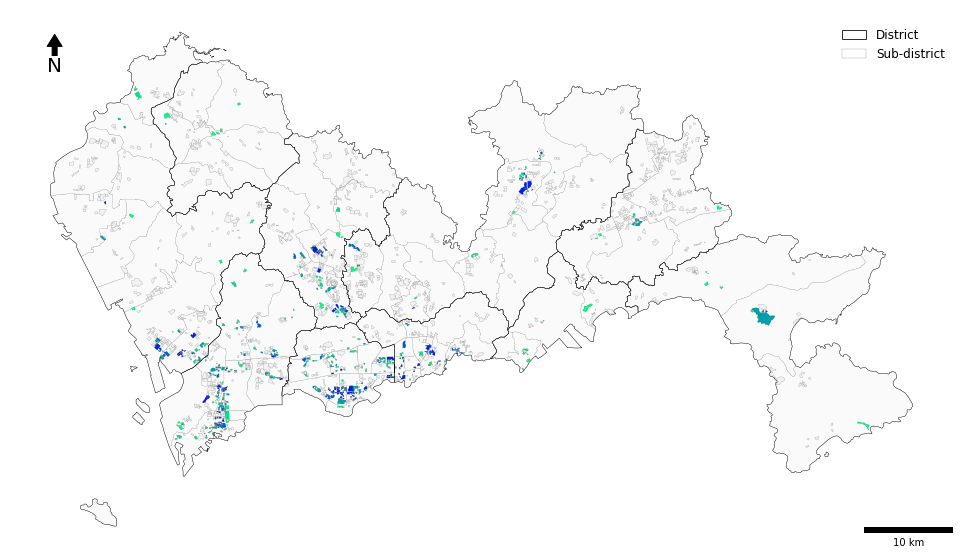

In [2055]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap, to_rgba
# from matplotlib_scalebar.scalebar import ScaleBar
# import mapclassify

# fig, ax = plt.subplots(figsize=(20, 10))

# # 确保两个 GeoDataFrame 使用相同的坐标系统
# assert subdistrict.crs == result_a.crs, "Coordinate Reference Systems (CRS) do not match!"

# # 绘制 subdistrict 作为底图，只绘制边界
# subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
# district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# # 使用mapclassify来获取分段
# classifier = mapclassify.Quantiles(result_a['Ai'], k=9)
# colors = plt.cm.winter(np.linspace(0, 1, 9))

# # 如果0-0分段存在，则将其颜色设置为浅灰色
# if 0 in classifier.bins:
#     colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

# cmap = ListedColormap(colors)

# # 绘制 result_a 在 subdistrict 之上
# result_a.plot(column='Ai', scheme='quantiles', k=15, legend=True, 
#               legend_kwds={'title': '2SFCA score (Walking to Community park)'}, 
#               ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# # 关闭坐标轴
# ax.axis('off')

# # 添加指北针
# x, y, arrow_length = 0.05, 0.95, 0.06
# ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# # 添加比例尺
# scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
# ax.add_artist(scalebar)

# # 调整图例位置、大小和文字排列
# legend = ax.get_legend()
# legend.set_bbox_to_anchor((0.99, 0.98))
# legend.prop.set_size(15)
# legend._legend_box.align = "left"

# # 删除图例的边框
# frame = legend.get_frame()
# frame.set_visible(False)


# # 修改图例标签
# labels = ["No access", "0.00 - 0.46", "0.46 - 1.79", "1.79 - 4.56", "4.56 - 12.77", "> 12.77"]
# for label, text in zip(legend.get_texts(), labels):
#     label.set_text(text)
    
    
# # 自定义图例元素
# legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
#                    Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

# ax.legend(handles=legend_elements, 
#           loc='upper right', prop={'size': 12}, 
#           frameon=False, bbox_to_anchor=(1, 0.98))

# # plt.savefig("tmp/a (Walking to Community park).png", dpi=300, bbox_inches='tight')    

# plt.show()


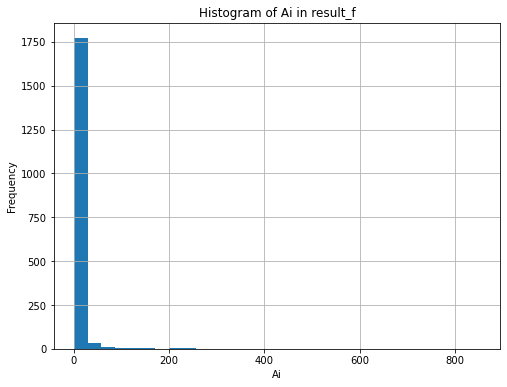

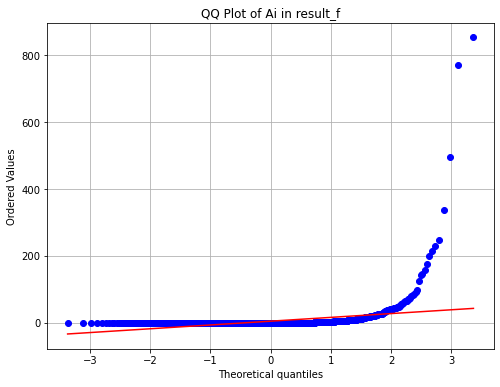

Skewness: 1.68901988152719
Kurtosis: 2.558025906759302
Shapiro-Wilk test statistic: 0.8148229122161865
Shapiro-Wilk p-value: 1.293678742264671e-41


In [2249]:
# 直方图
plt.figure(figsize=(8, 6))
result_a['Ai'].hist(bins=30)
plt.title('Histogram of Ai in result_f')
plt.xlabel('Ai')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# QQ图
plt.figure(figsize=(8, 6))
stats.probplot(result_a['Ai'], plot=plt)
plt.title('QQ Plot of Ai in result_f')
plt.grid(True)
plt.show()

# 计算偏度和峰度
print('Skewness:', result_f['Ai'].skew())
print('Kurtosis:', result_f['Ai'].kurt())

# Shapiro-Wilk测试 (仅适用于样本大小<5000，否则可能会因计算上的限制而不准确)
if len(result_a) < 5000:
    shapiro_test = stats.shapiro(result_f['Ai'])
    print('Shapiro-Wilk test statistic:', shapiro_test.statistic)
    print('Shapiro-Wilk p-value:', shapiro_test.pvalue)
else:
    print("Sample size too large for Shapiro-Wilk test.")


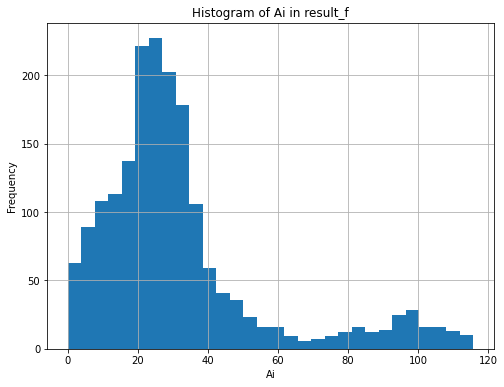

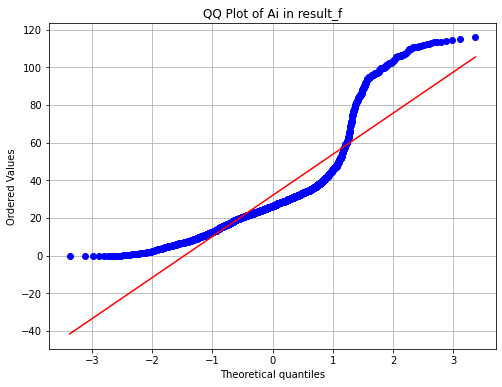

Skewness: 1.68901988152719
Kurtosis: 2.558025906759302
Shapiro-Wilk test statistic: 0.8148229122161865
Shapiro-Wilk p-value: 1.293678742264671e-41


In [2248]:
# 直方图
plt.figure(figsize=(8, 6))
result_f['Ai'].hist(bins=30)
plt.title('Histogram of Ai in result_f')
plt.xlabel('Ai')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# QQ图
plt.figure(figsize=(8, 6))
stats.probplot(result_f['Ai'], plot=plt)
plt.title('QQ Plot of Ai in result_f')
plt.grid(True)
plt.show()

# 计算偏度和峰度
print('Skewness:', result_f['Ai'].skew())
print('Kurtosis:', result_f['Ai'].kurt())

# Shapiro-Wilk测试 (仅适用于样本大小<5000，否则可能会因计算上的限制而不准确)
if len(result_f) < 5000:
    shapiro_test = stats.shapiro(result_f['Ai'])
    print('Shapiro-Wilk test statistic:', shapiro_test.statistic)
    print('Shapiro-Wilk p-value:', shapiro_test.pvalue)
else:
    print("Sample size too large for Shapiro-Wilk test.")


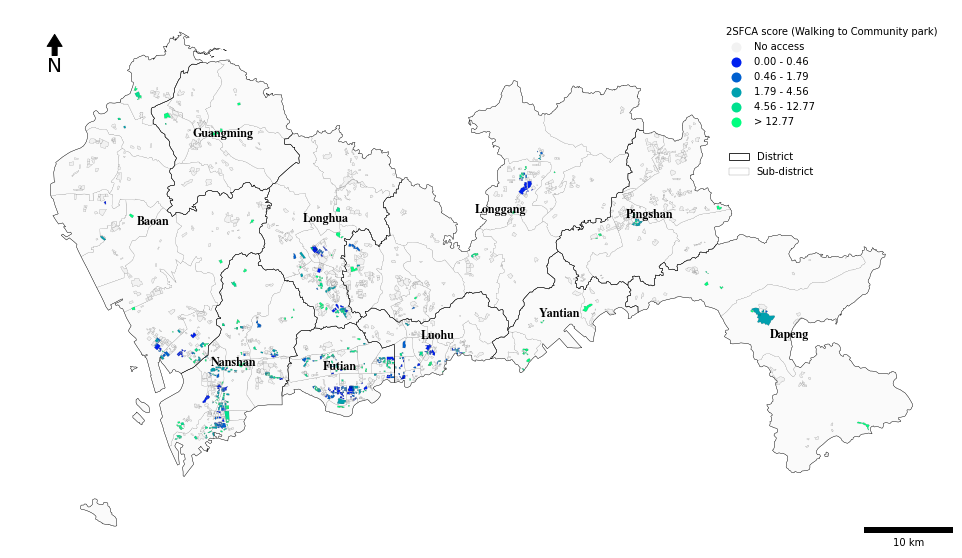

In [2275]:
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_a.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_a['Ai'], k=9)
colors = plt.cm.winter(np.linspace(0, 1, 9))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_a 在 subdistrict 之上，并生成主要的色块图例
result_a.plot(column='Ai', scheme='quantiles', k=15, legend=True, 
              legend_kwds={'title': '2SFCA score (Walking to Community park)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend._legend_box.align = "left"
# legend.prop.set_size(15)
# legend.get_title().set_fontsize(15)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["No access", "0.00 - 0.46", "0.46 - 1.79", "1.79 - 4.56", "4.56 - 12.77", "> 12.77"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)
        
# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.86, 0.75), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/a (Walking to Community park).png", dpi=300, bbox_inches='tight')  

plt.show()

#### b)

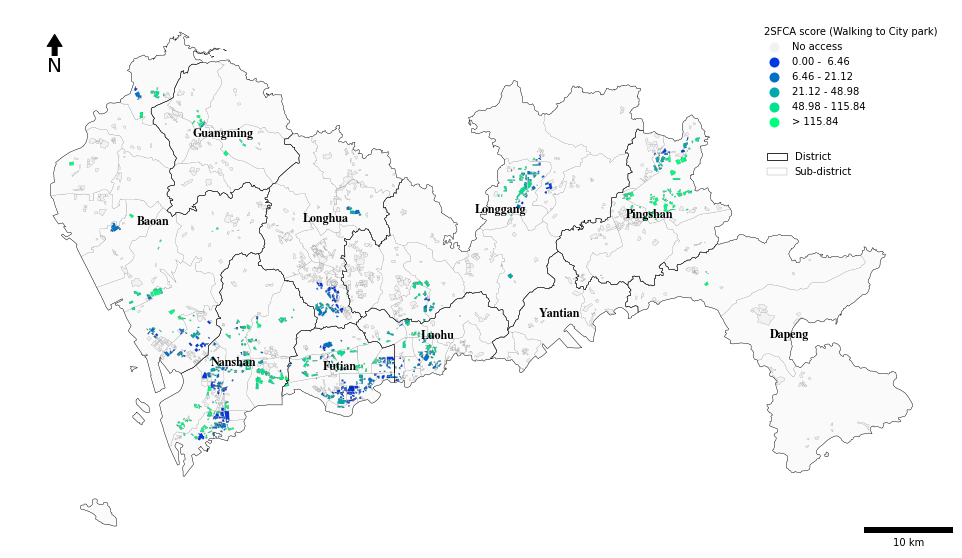

In [2258]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_b.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_b['Ai'], k=10)
colors = plt.cm.winter(np.linspace(0, 1, 10))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_a 在 subdistrict 之上
result_b.plot(column='Ai', scheme='quantiles', k=10, legend=True, 
              legend_kwds={'title': '2SFCA score (Walking to City park)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["No access", "0.00 -  6.46", "6.46 - 21.12", "21.12 - 48.98", "48.98 - 115.84", "> 115.84"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)
    
    
# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.90, 0.75), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/b (Walking to City park).png", dpi=300, bbox_inches='tight')    

plt.show()


#### c)

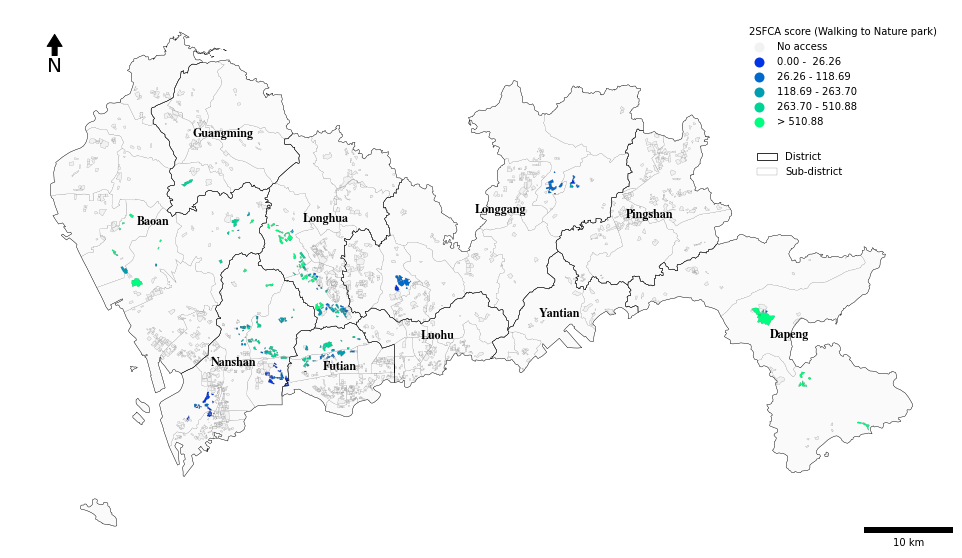

In [2075]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_c.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_c['Ai'], k=30)
colors = plt.cm.winter(np.linspace(0, 1, 30))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_c 在 subdistrict 之上
result_c.plot(column='Ai', scheme='quantiles', k=30, legend=True, 
              legend_kwds={'title': '2SFCA score (Walking to Nature park)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["No access", "0.00 -  26.26", "26.26 - 118.69", "118.69 - 263.70", "263.70 - 510.88", "> 510.88"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)
    
# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.89, 0.75), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/c (Walking to Nature park).png", dpi=300, bbox_inches='tight')    

plt.show()


#### d)

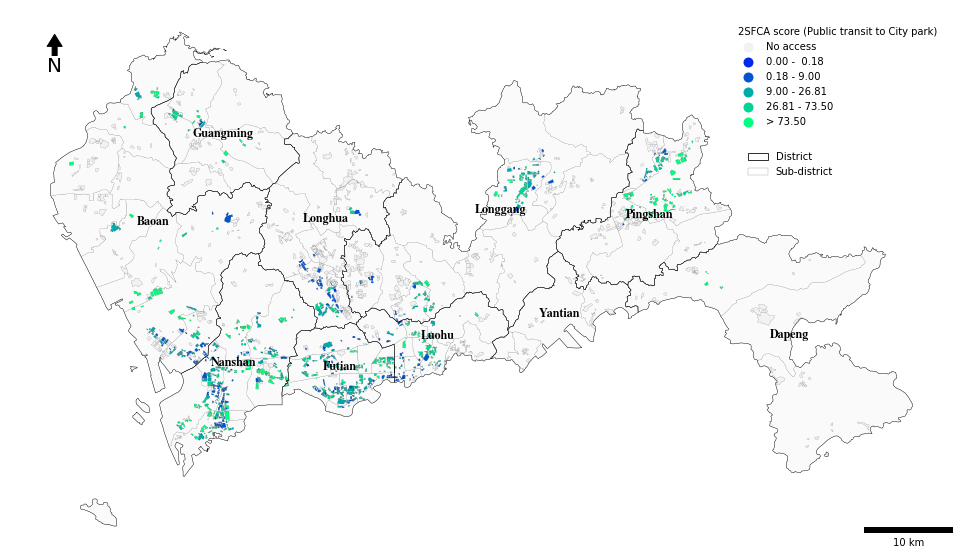

In [2079]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_d.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_d['Ai'], k=7)
colors = plt.cm.winter(np.linspace(0, 1, 7))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_d 在 subdistrict 之上
result_d.plot(column='Ai', scheme='quantiles', k=7, legend=True, 
              legend_kwds={'title': '2SFCA score (Public transit to City park)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["No access", "0.00 -  0.18", "0.18 - 9.00", "9.00 - 26.81", "26.81 - 73.50", "> 73.50"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

    
# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.88, 0.75), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/d (Public transit to City park).png", dpi=300, bbox_inches='tight')    

plt.show()


#### e)

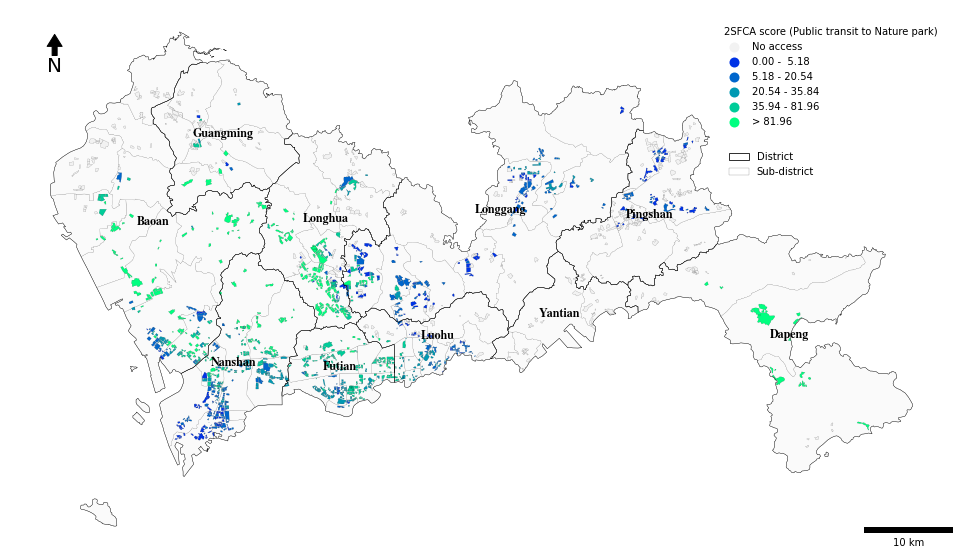

In [2083]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_e.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_e['Ai'], k=6)
colors = plt.cm.winter(np.linspace(0, 1, 6))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_e 在 subdistrict 之上
result_e.plot(column='Ai', scheme='quantiles', k=6, legend=True, 
              legend_kwds={'title': '2SFCA score (Public transit to Nature park)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')


# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["No access", "0.00 -  5.18", "5.18 - 20.54", "20.54 - 35.84", "35.94 - 81.96", "> 81.96"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.86, 0.75), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/e (Public transit to Nature park).png", dpi=300, bbox_inches='tight')    

plt.show()


#### f)

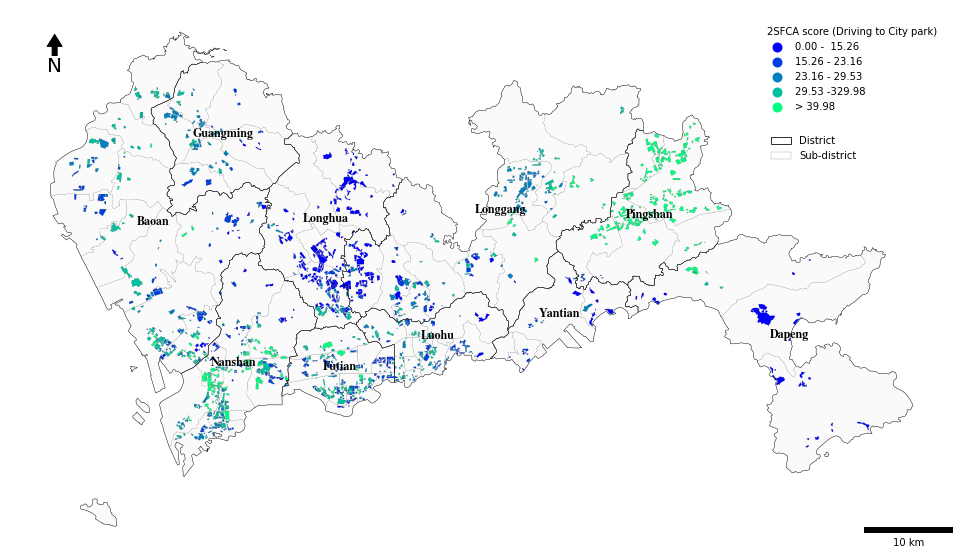

In [2090]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_f.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_f['Ai'], k=5)
colors = plt.cm.winter(np.linspace(0, 1, 5))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_f 在 subdistrict 之上
result_f.plot(column='Ai', scheme='quantiles', k=5, legend=True, 
              legend_kwds={'title': '2SFCA score (Driving to City park)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)


# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["0.00 -  15.26", "15.26 - 23.16", "23.16 - 29.53", "29.53 -329.98", "> 39.98"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

    
# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.905, 0.78), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)
    
plt.savefig("tmp/f (Driving to City park).png", dpi=300, bbox_inches='tight')    

plt.show()


#### g)

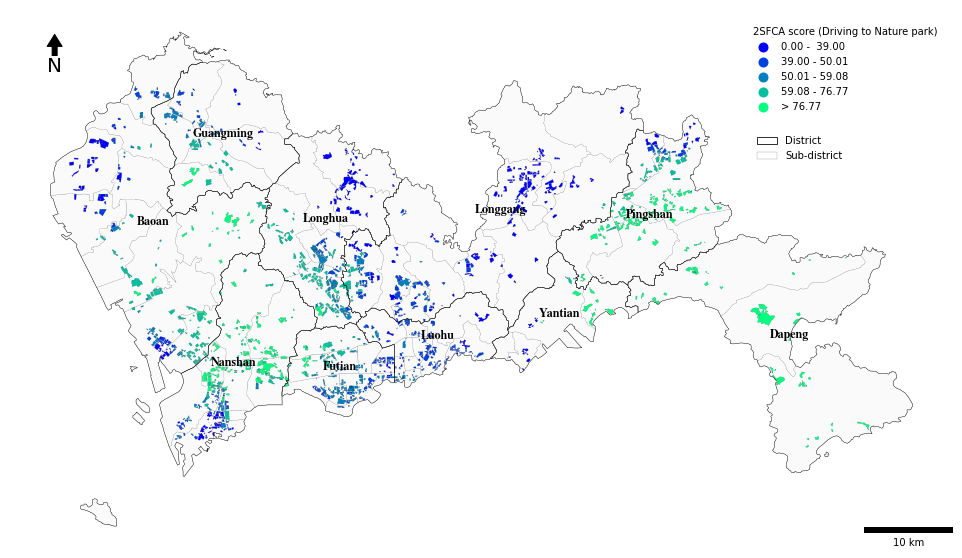

In [2093]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_g.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_g['Ai'], k=5)
colors = plt.cm.winter(np.linspace(0, 1, 5))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_g 在 subdistrict 之上
result_g.plot(column='Ai', scheme='quantiles', k=5, legend=True, 
              legend_kwds={'title': '2SFCA score (Driving to Nature park)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)


# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["0.00 -  39.00", "39.00 - 50.01", "50.01 - 59.08", "59.08 - 76.77", "> 76.77"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.89, 0.78), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/g (Driving to Nature park).png", dpi=300, bbox_inches='tight')    

plt.show()


#### d+f)

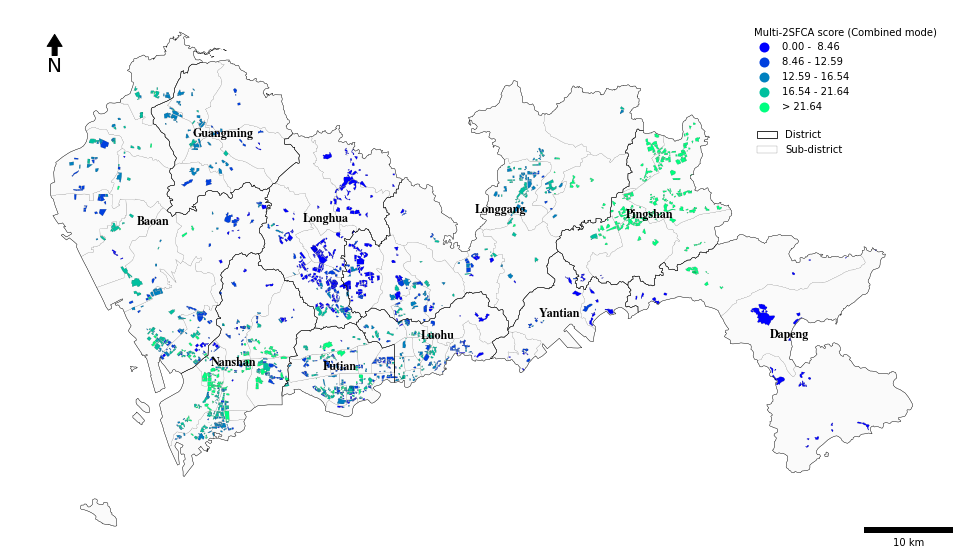

In [2095]:
import geopandas as gpd
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

# 确保两个 GeoDataFrame 使用相同的坐标系统
assert subdistrict.crs == result_d_f.crs, "Coordinate Reference Systems (CRS) do not match!"

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(result_d_f['Ai'], k=5)
colors = plt.cm.winter(np.linspace(0, 1, 5))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f2f2f2')

cmap = ListedColormap(colors)

# 绘制 result_d_f 在 subdistrict 之上
result_d_f.plot(column='Ai', scheme='quantiles', k=5, legend=True, 
              legend_kwds={'title': 'Multi-2SFCA score (Combined mode)'}, 
              ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)


# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 修改图例标签
labels = ["0.00 -  8.46", "8.46 - 12.59", "12.59 - 16.54", "16.54 - 21.64", "> 21.64"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.89, 0.79), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/d_f (Combined driving & public transit).png", dpi=300, bbox_inches='tight')    

plt.show()


### 3.2 Sub-district plot

In [1206]:
subdistrict.columns

Index(['OBJECTID', 'Name', 'Shape_Area', 'geometry'], dtype='object')

In [1232]:
datasets = {
    "a": result_a,
    "b": result_b,
    "c": result_c,
    "d": result_d,
    "e": result_e,
    "f": result_f,
    "g": result_g,
    "d_f": result_d_f
}

all_results = []

for key, dataset in datasets.items():
    # 空间连接以确定每个neighbourhood属于哪个subdistrict
    joined = gpd.sjoin(dataset, subdistrict[['Name','geometry']], op='within')
    
    # 计算人口加权的平均Ai
    joined['weighted_Ai'] = joined['Ai'] * joined['sum_pop']

    # 对Name进行分组并聚合以计算人口加权平均值
    agg_data = joined.groupby('Name').agg({'sum_pop':'sum', 'weighted_Ai':'sum'}).reset_index()
    agg_data[f'Ai_{key}'] = agg_data['weighted_Ai'] / agg_data['sum_pop']

    # 将每次循环的结果加入到列表all_results中
    all_results.append(agg_data)

# 将所有的结果合并到一个数据框中
from functools import reduce
subdistrict_Ai = reduce(lambda x, y: pd.merge(x, y, on='Name', how='outer'), all_results)

subdistrict_Ai = pd.merge(subdistrict_Ai, subdistrict[['Name','geometry']], on='Name', how='left')

In [1225]:
len(subdistrict_Ai)

73

In [1233]:
subdistrict_Ai.columns

Index(['Name', 'sum_pop_x', 'weighted_Ai_x', 'Ai_a', 'sum_pop_y',
       'weighted_Ai_y', 'Ai_b', 'sum_pop_x', 'weighted_Ai_x', 'Ai_c',
       'sum_pop_y', 'weighted_Ai_y', 'Ai_d', 'sum_pop_x', 'weighted_Ai_x',
       'Ai_e', 'sum_pop_y', 'weighted_Ai_y', 'Ai_f', 'sum_pop_x',
       'weighted_Ai_x', 'Ai_g', 'sum_pop_y', 'weighted_Ai_y', 'Ai_d_f',
       'geometry'],
      dtype='object')

In [1234]:
subdistrict_Ai = subdistrict_Ai[['Name','Ai_a','Ai_b','Ai_c','Ai_d','Ai_e','Ai_f','Ai_g','Ai_d_f','geometry']]

In [1235]:
subdistrict_Ai

Name       Ai_a        Ai_b       Ai_c        Ai_d       Ai_e       Ai_f  \
0   东晓街道   0.301975   79.936069   0.000000   47.219193   0.669883  28.398331   
1   东湖街道   0.000000   64.835247   0.000000   68.527456   0.041302  27.222727   
2   东门街道   0.754442   34.213138   0.000000    7.725285  24.599140  24.684480   
3   光明街道  30.642358  148.863520   0.000000  152.214674   0.194836  20.172572   
4   公明街道   0.000000   76.247085   0.000000   36.398761   3.276283  29.253782   
..   ...        ...         ...        ...         ...        ...        ...   
68  黄贝街道   2.582113   27.137673   0.000000   23.533207  21.542621  27.447229   
69  龙华街道   3.544416    0.000000   0.000000    0.025309  98.143738   7.032899   
70  龙城街道   0.605877   49.866620   0.000000   50.014588   8.709986  27.005099   
71  龙岗街道   2.036275    4.188653  32.487047    1.138079  18.326773  35.939162   
72  龙田街道   0.000000    2.573686   0.000000    8.461018   1.532295  91.623261   

         Ai_g     Ai_d_f                                           geometry  
0   46.645765  15.811256  MULTIPOLYGON (((12705141.504 2580973.607, 1270...  
1   42.289713  14.885788  MULTIPOLYGON (((12712543.471 2580440.746, 1271...  
2   46.261450  13.222310  MULTIPOLYGON (((12704445.869 2577438.837, 1270...  
3   47.043930  11.222033  MULTIPOLYGON (((12689126.525 2603202.310, 1268...  
4   46.407457  16.128133  MULTIPOLYGON (((12680271.617 2604782.863, 1268...  
..        ...        ...                                                ...  
68  43.515807  15.023486  MULTIPOLYGON (((12707332.049 2578229.313, 1270...  
69  54.130914   3.715585  MULTIPOLYGON (((12697210.213 2592807.537, 1269...  
70   8.569927  15.717983  MULTIPOLYGON (((12719127.240 2600300.920, 1271...  
71   8.748067  18.063011  MULTIPOLYGON (((12718454.536 2605983.108, 1271...  
72  43.663356  48.053417  MULTIPOLYGON (((12731278.430 2599420.681, 1273...  

[73 rows x 10 columns]

In [1237]:
subdistrict_Ai = subdistrict.merge(subdistrict_Ai, on='Name', how='left')

In [1239]:
subdistrict_Ai.head()

OBJECTID  Name    Shape_Area  \
0         1  沙河街道  2.179247e+07   
1         2  粤海街道  1.807562e+07   
2        13  凤凰街道  2.598523e+07   
3        14  玉塘街道  2.532503e+07   
4        15  光明街道  3.424578e+07   

                                          geometry_x       Ai_a        Ai_b  \
0  MULTIPOLYGON (((12689522.017 2576929.913, 1268...   0.561225   70.457945   
1  MULTIPOLYGON (((12681992.942 2575205.739, 1268...   4.197026   36.458905   
2  MULTIPOLYGON (((12687831.657 2598168.054, 1268...   0.000000    0.000000   
3  MULTIPOLYGON (((12678475.143 2600485.832, 1267...   0.000000    0.000000   
4  MULTIPOLYGON (((12689126.525 2603202.310, 1268...  30.642358  148.863520   

         Ai_c        Ai_d       Ai_e       Ai_f       Ai_g     Ai_d_f  \
0   19.365509   57.949446  26.839698  34.105319  78.994502  18.917178   
1    0.000000   32.257481  20.606623  38.933081  65.269501  20.984285   
2    0.000000    3.831414  22.881319  27.940043  67.918174  15.043822   
3  108.794420    0.000000  80.157991  24.716456  76.248107  13.327810   
4    0.000000  152.214674   0.194836  20.172572  47.043930  11.222033   

                                          geometry_y  
0  MULTIPOLYGON (((12689522.017 2576929.913, 1268...  
1  MULTIPOLYGON (((12681992.942 2575205.739, 1268...  
2  MULTIPOLYGON (((12687831.657 2598168.054, 1268...  
3  MULTIPOLYGON (((12678475.143 2600485.832, 1267...  
4  MULTIPOLYGON (((12689126.525 2603202.310, 1268...

In [1242]:
# 删除 geometry_y 列
subdistrict_Ai = subdistrict_Ai.drop(columns=['geometry_y'])

# 将 geometry_x 列名重命名为 geometry
subdistrict_Ai = subdistrict_Ai.rename(columns={'geometry_x': 'geometry'})


In [1243]:
subdistrict_Ai.fillna(0, inplace=True)

In [1247]:
subdistrict_Ai= gpd.GeoDataFrame(subdistrict_Ai, geometry='geometry')
subdistrict_Ai = subdistrict_Ai.to_crs(epsg=3857)

In [1249]:
subdistrict_Ai.describe()

OBJECTID    Shape_Area        Ai_a        Ai_b          Ai_c  \
count  74.000000  7.400000e+01   74.000000   74.000000     74.000000   
mean   50.000000  3.099464e+07    5.409950   28.398066    954.939831   
std    23.376021  2.535248e+07   14.617389   40.415306   7818.838659   
min     1.000000  2.434607e+06    0.000000    0.000000      0.000000   
25%    31.250000  1.129123e+07    0.001126    0.000000      0.000000   
50%    51.500000  2.724936e+07    1.431887    9.198211      0.000000   
75%    69.750000  4.142398e+07    3.577032   43.930791      0.679132   
max    88.000000  1.352320e+08  111.097364  244.452068  67298.081494   

             Ai_d          Ai_e       Ai_f         Ai_g     Ai_d_f  
count   74.000000     74.000000  74.000000    74.000000  74.000000  
mean    26.786493    393.409335  29.728749   247.634162  16.096980  
std     37.873704   3040.314480  19.204224   839.258942  10.374174  
min      0.000000      0.000000   0.000000     0.000000   0.000000  
25%      0.000000      2.103464  20.530954    40.391897  10.886143  
50%     12.100625     22.131128  27.661389    50.009924  15.009840  
75%     47.003978     41.766239  32.112351    66.977211  17.734233  
max    227.534700  26186.738619  98.976109  4339.753312  56.968227

In [1250]:
print((subdistrict_Ai == 0).sum())

OBJECTID       0
Name           0
Shape_Area     0
geometry       0
Ai_a          19
Ai_b          26
Ai_c          55
Ai_d          20
Ai_e          10
Ai_f           1
Ai_g           1
Ai_d_f         1
dtype: int64


In [1251]:
len(subdistrict_Ai)

74

#### a) walking to community

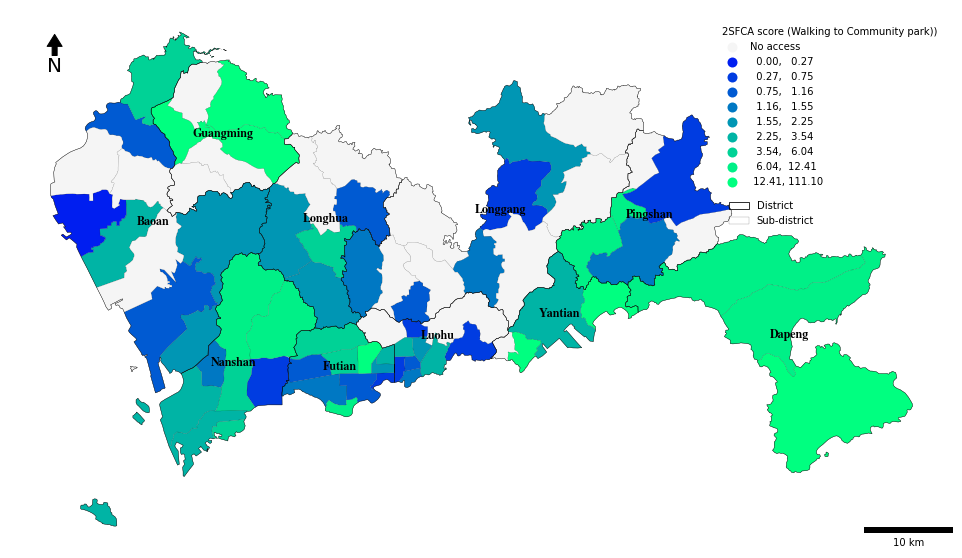

In [2103]:
# a

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(subdistrict_Ai['Ai_a'], k=18)
colors = plt.cm.winter(np.linspace(0, 1, 18))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f5f5f5')

cmap = ListedColormap(colors)

subdistrict_Ai.plot(column='Ai_a', scheme='quantiles', k=11, legend=True, legend_kwds={'title': '2SFCA score (Walking to Community park))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"


# 修改图例标签
labels = ["No access"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

    
# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.86, 0.66), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)
    

plt.savefig("tmp/subdistric-a (waling to community).png", dpi=300, bbox_inches='tight')

plt.show()


#### b) walking to city park

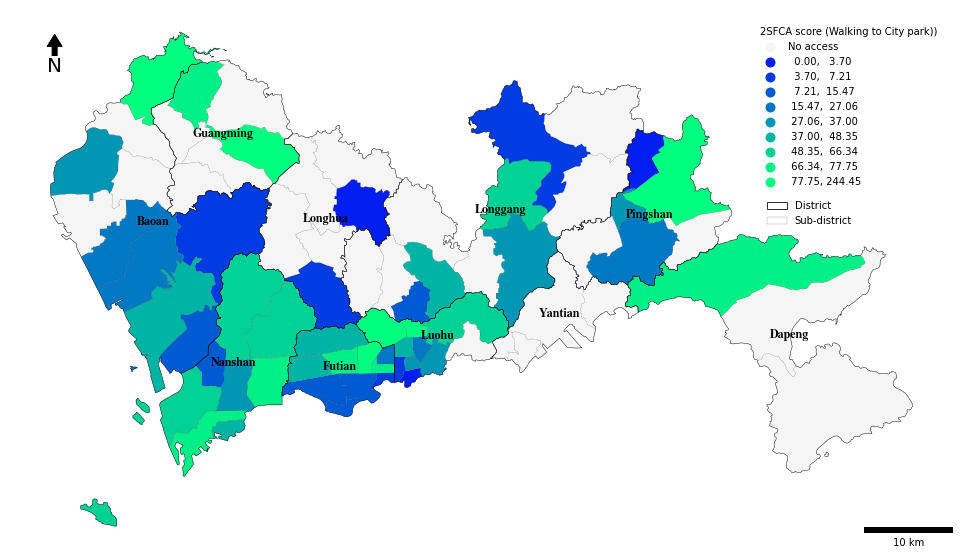

In [2106]:
#b

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(subdistrict_Ai['Ai_b'], k=18)
colors = plt.cm.winter(np.linspace(0, 1, 18))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f5f5f5')

cmap = ListedColormap(colors)

subdistrict_Ai.plot(column='Ai_b', scheme='quantiles', k=13, legend=True, legend_kwds={'title': '2SFCA score (Walking to City park))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"


# 修改图例标签
labels = ["No access"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)  

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.90, 0.66), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)
    
plt.savefig("tmp/subdistric-b (waling to city park).png", dpi=300, bbox_inches='tight')

plt.show()


#### c) Walking to Nature park

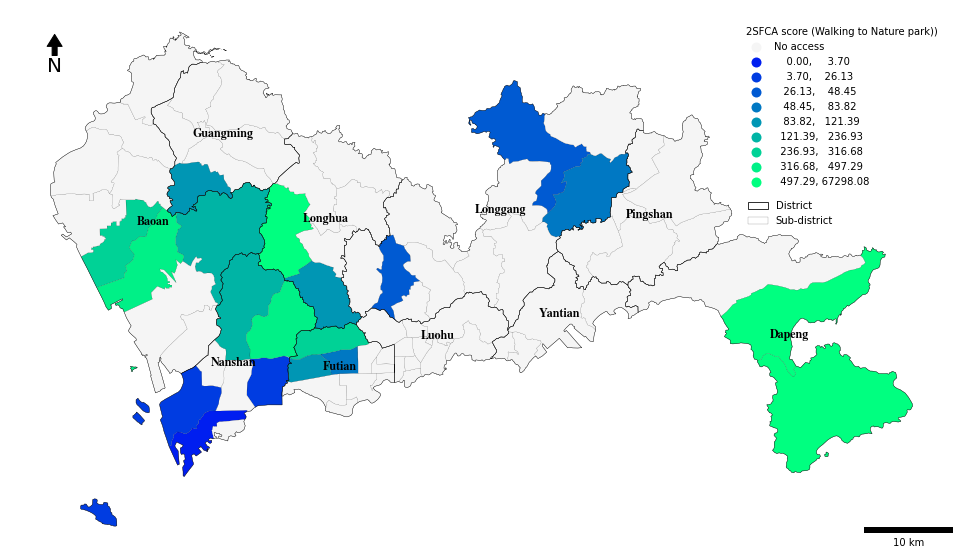

In [2111]:
# c

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')                      
                       
                       
# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(subdistrict_Ai['Ai_c'], k=18)
colors = plt.cm.winter(np.linspace(0, 1, 18))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f5f5f5')

cmap = ListedColormap(colors)

subdistrict_Ai.plot(column='Ai_c', scheme='quantiles', k=33, legend=True, legend_kwds={'title': '2SFCA score (Walking to Nature park))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 修改图例标签
labels = ["No access"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.88, 0.66), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/subdistric-c (waling to Nature park).png", dpi=300, bbox_inches='tight')

plt.show()

#### d) Public transit to City park

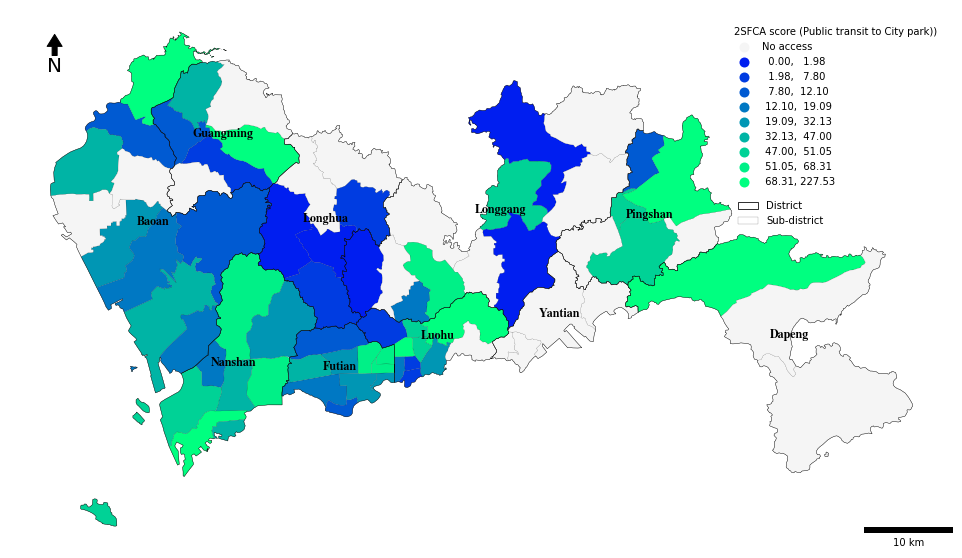

In [2114]:
# d

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(subdistrict_Ai['Ai_d'], k=18)
colors = plt.cm.winter(np.linspace(0, 1, 18))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f5f5f5')

cmap = ListedColormap(colors)

subdistrict_Ai.plot(column='Ai_d', scheme='quantiles', k=12, legend=True, legend_kwds={'title': '2SFCA score (Public transit to City park))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"


# 修改图例标签
labels = ["No access"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)
    

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.87, 0.66), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/subdistric-d (Public transit to City park).png", dpi=300, bbox_inches='tight')

plt.show()


#### e) Public transit to Nature park

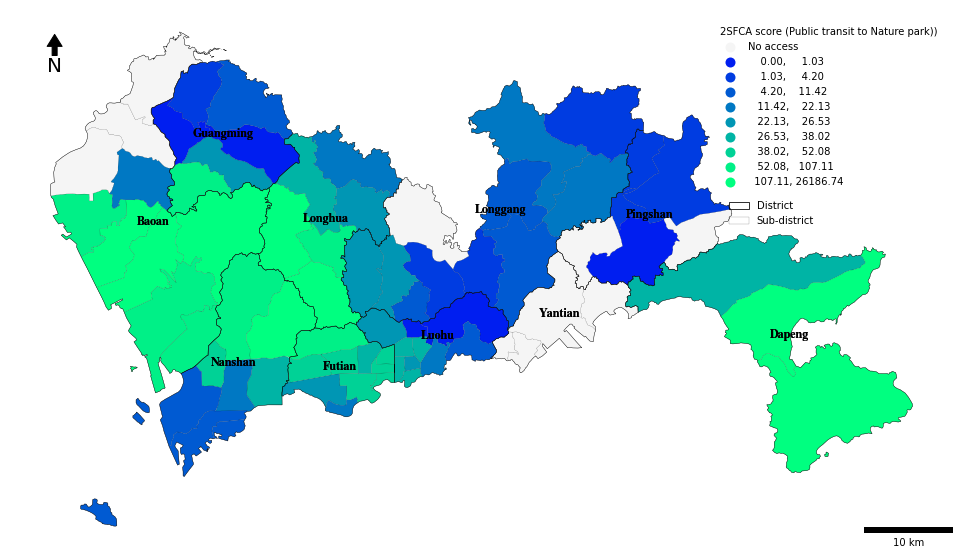

In [2117]:
# e


import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用mapclassify来获取分段
classifier = mapclassify.Quantiles(subdistrict_Ai['Ai_e'], k=18)
colors = plt.cm.winter(np.linspace(0, 1, 18))

# 如果0-0分段存在，则将其颜色设置为浅灰色
if 0 in classifier.bins:
    colors[list(classifier.bins).index(0)] = to_rgba('#f5f5f5')

cmap = ListedColormap(colors)

subdistrict_Ai.plot(column='Ai_e', scheme='quantiles', k=10, legend=True, legend_kwds={'title': '2SFCA score (Public transit to Nature park))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap=cmap)

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"


# 修改图例标签
labels = ["No access"]
for label, text in zip(legend.get_texts(), labels):
    label.set_text(text)
    

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.86, 0.66), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)


plt.savefig("tmp/subdistric-e (Public transit to Nature park).png", dpi=300, bbox_inches='tight')

plt.show()


#### f) Driving to City park

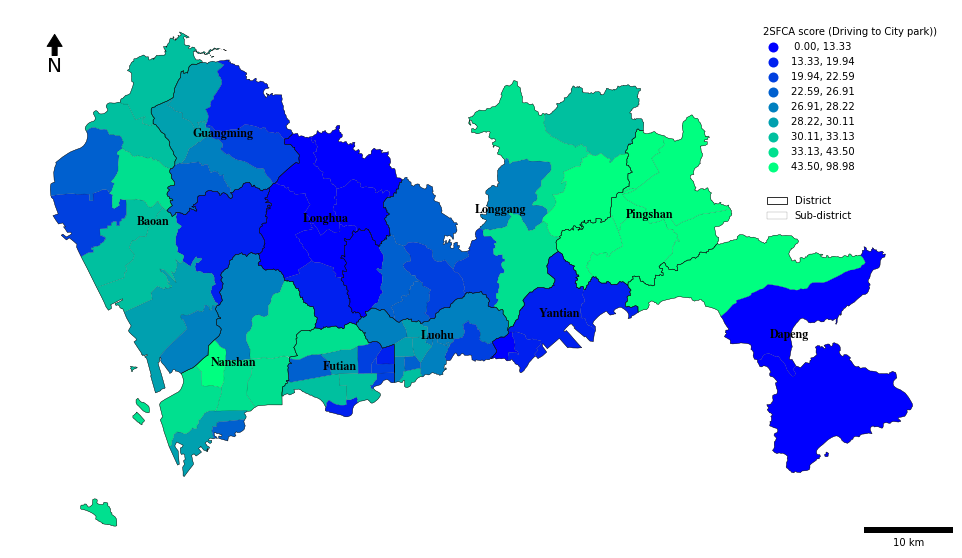

In [2119]:
# f Driving to City park

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
subdistrict_Ai.plot(column='Ai_f', scheme='quantiles', k=9, 
                 legend=True, legend_kwds={'title': '2SFCA score (Driving to City park))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap='winter')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"


# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.90, 0.67), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/subdistric-f (Driving to City park).png", dpi=300, bbox_inches='tight')

plt.show()


#### g) Driving to Nature park  

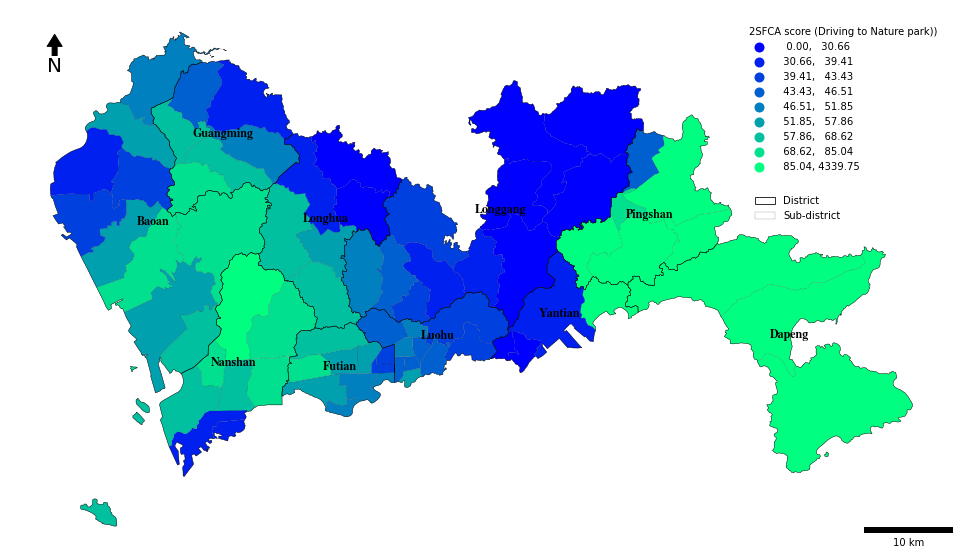

In [2125]:
# g

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
subdistrict_Ai.plot(column='Ai_g', scheme='quantiles', k=9, 
                 legend=True, legend_kwds={'title': '2SFCA score (Driving to Nature park))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap='winter')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# # 修改图例标签
# labels = ["0.00 - 20.74", "20.74 - 27.69", "27.69 - 32.13", "> 32.13"]  # 这是一个例子，请按照你的数据和需要修改
# for label, text in zip(legend.get_texts(), labels):
#     label.set_text(text)
    

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.888, 0.67), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/subdistric-g (Driving to Nature park).png", dpi=300, bbox_inches='tight')

plt.show()


#### d+f) Combined mode (Combined driving & public transit)

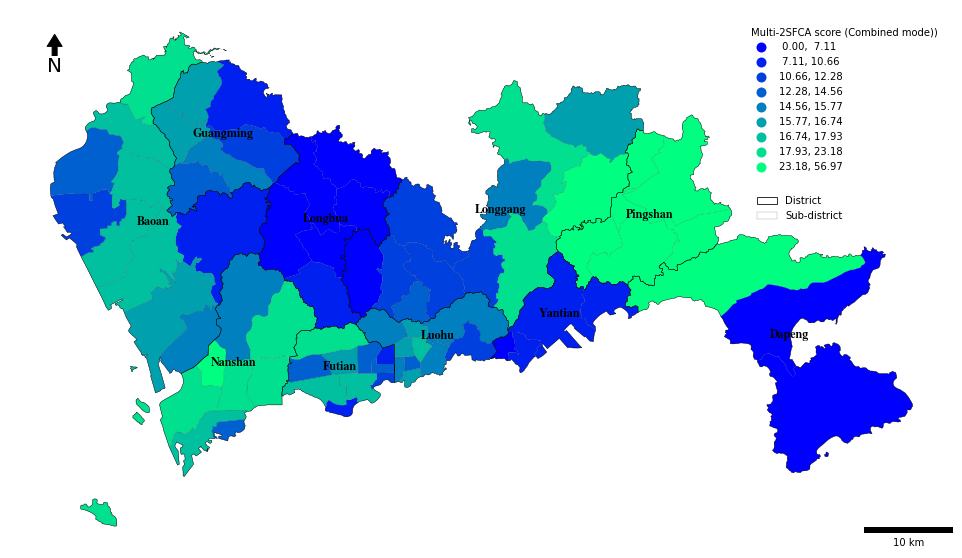

In [2130]:
# d+f

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.4)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
subdistrict_Ai.plot(column='Ai_d_f', scheme='quantiles', k=9, 
                 legend=True, legend_kwds={'title': 'Multi-2SFCA score (Combined mode))'}, 
                 ax=ax, edgecolor='black', linewidth=0.1, cmap='winter')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

   

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)


# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.89, 0.67), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/subdistric-d_f (Combined driving & public transit).png", dpi=300, bbox_inches='tight')

plt.show()


## 4.GINI

In [1466]:
# 使用空间连接将每个pop_resid点分配给一个subdistrict
pop = pop.to_crs(epsg=3857)
joined_pop = gpd.sjoin(subdistrict_Ai, pop, how="inner", op="contains")

# 根据subdistrict的ID进行分组，并对每组中的sum_pop求和
pop_per_subdistrict = joined_pop.groupby('Name')['popsum'].sum()

# 将聚合后的结果合并回subdistrict GeoDataFrame，并确保所有的subdistrict都被包括
subdistrict_merge = subdistrict_Ai.merge(pop_per_subdistrict, on='Name', how='left')

# 用0替换NaN值
subdistrict_merge['popsum'] = subdistrict_merge['popsum'].fillna(0)


In [1459]:
# # 使用空间连接将每个pop_resid点分配给一个subdistrict
# pop_resid = pop_resid.to_crs(epsg=3857)
# joined_pop = gpd.sjoin(subdistrict_Ai, pop_resid, how="inner", op="contains")

# # 根据subdistrict的ID进行分组，并对每组中的sum_pop求和
# pop_per_subdistrict = joined_pop.groupby('Name')['sum_pop'].sum()

# # 将聚合后的结果合并回subdistrict GeoDataFrame，并确保所有的subdistrict都被包括
# subdistrict_merge = subdistrict_Ai.merge(pop_per_subdistrict, on='Name', how='left')

# # 用0替换NaN值
# subdistrict_merge['sum_pop'] = subdistrict_merge['sum_pop'].fillna(0)


In [1467]:
# 确保所有GeoDataFrames都在相同的坐标系统中
community_park = community_park.to_crs(epsg=3857)
city_park = city_park.to_crs(epsg=3857)
nature_park = nature_park.to_crs(epsg=3857)

# 使用空间叠加计算每个subdistrict中的公园面积
def calculate_park_area_in_subdistrict(subdistrict_gdf, park_gdf):
    # 使用空间叠加来获得交集
    intersection = gpd.overlay(subdistrict_gdf, park_gdf, how="intersection")
    # 计算交集的面积
    intersection['area'] = intersection.geometry.area
    # 按subdistrict名称分组并求和面积
    area_per_subdistrict = intersection.groupby('Name')['area'].sum()
    return area_per_subdistrict

# 计算每个subdistrict中的每种公园类型的面积
community_park_area = calculate_park_area_in_subdistrict(subdistrict_Ai, community_park)
city_park_area = calculate_park_area_in_subdistrict(subdistrict_Ai, city_park)
nature_park_area = calculate_park_area_in_subdistrict(subdistrict_Ai, nature_park)

# 将计算得到的面积汇总到subdistrict_merge
subdistrict_merge = subdistrict_merge.merge(community_park_area.rename('community_park_area'), left_on='Name', right_index=True, how="left")
subdistrict_merge = subdistrict_merge.merge(city_park_area.rename('city_park_area'), left_on='Name', right_index=True, how="left")
subdistrict_merge = subdistrict_merge.merge(nature_park_area.rename('nature_park_area'), left_on='Name', right_index=True, how="left")

# 将NaN值（未与任何公园相交的区域）替换为0
subdistrict_merge[['community_park_area', 'city_park_area', 'nature_park_area']] = subdistrict_merge[['community_park_area', 'city_park_area', 'nature_park_area']].fillna(0)


In [1468]:
subdistrict_merge['compark_per_pop'] = subdistrict_merge['community_park_area']/subdistrict_merge['popsum']
subdistrict_merge['citypark_per_pop'] = subdistrict_merge['city_park_area']/subdistrict_merge['popsum']
subdistrict_merge['napark_per_pop'] = subdistrict_merge['nature_park_area']/subdistrict_merge['popsum']

In [1469]:
subdistrict_merge

OBJECTID  Name    Shape_Area  \
0          1  沙河街道  2.179247e+07   
1          2  粤海街道  1.807562e+07   
2         13  凤凰街道  2.598523e+07   
3         14  玉塘街道  2.532503e+07   
4         15  光明街道  3.424578e+07   
..       ...   ...           ...   
69        88  大鹏街道  8.879811e+07   
70        19  南山街道  3.875446e+07   
71        48  海山街道  8.851195e+06   
72        43  盐田街道  5.358986e+07   
73        30  坑梓街道  6.264222e+07   

                                             geometry       Ai_a        Ai_b  \
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...   0.561225   70.457945   
1   MULTIPOLYGON (((12681992.942 2575205.739, 1268...   4.197026   36.458905   
2   MULTIPOLYGON (((12687831.657 2598168.054, 1268...   0.000000    0.000000   
3   MULTIPOLYGON (((12678475.143 2600485.832, 1267...   0.000000    0.000000   
4   MULTIPOLYGON (((12689126.525 2603202.310, 1268...  30.642358  148.863520   
..                                                ...        ...         ...   
69  MULTIPOLYGON (((12738210.629 2583233.756, 1273...   6.059076    0.000000   
70  MULTIPOLYGON (((12677486.804 2576818.864, 1267...   2.658651   54.573755   
71  MULTIPOLYGON (((12717202.971 2578665.307, 1271...  47.291453    0.000000   
72  MULTIPOLYGON (((12717171.245 2586205.839, 1271...   3.539867    0.000000   
73  MULTIPOLYGON (((12738814.537 2595221.214, 1273...   0.457705  244.452068   

          Ai_c        Ai_d        Ai_e       Ai_f         Ai_g     Ai_d_f  \
0    19.365509   57.949446   26.839698  34.105319    78.994502  18.917178   
1     0.000000   32.257481   20.606623  38.933081    65.269501  20.984285   
2     0.000000    3.831414   22.881319  27.940043    67.918174  15.043822   
3   108.794420    0.000000   80.157991  24.716456    76.248107  13.327810   
4     0.000000  152.214674    0.194836  20.172572    47.043930  11.222033   
..         ...         ...         ...        ...          ...        ...   
69  523.967017    0.000000  508.350363   2.740849  4009.607997   1.478829   
70   10.127627   47.710130   11.189016  38.060544    58.143016  21.545728   
71    0.000000    0.000000    0.000000  15.003114    15.628892   7.824389   
72    0.000000    0.000000    0.000000  17.597140    38.945108   9.148234   
73    0.000000  227.534700    3.009139  98.976109   107.981597  56.968227   

           popsum  community_park_area  city_park_area  nature_park_area  \
0   176252.760885         25681.190520    2.551154e+06      3.116790e+05   
1   199270.150711        446374.870920    1.689998e+06      0.000000e+00   
2    68123.141570             0.000000    0.000000e+00      0.000000e+00   
3    85067.725235             0.000000    0.000000e+00      4.009310e+06   
4    52511.775509        132624.557026    5.784473e+05      0.000000e+00   
..            ...                  ...             ...               ...   
69   88645.993524         58124.341638    0.000000e+00      5.026383e+06   
70  213143.510262        321509.476659    3.635832e+06      4.675047e+05   
71   61638.445075        158958.243518    0.000000e+00      0.000000e+00   
72  122409.833718         48137.718881    0.000000e+00      0.000000e+00   
73  139078.004916         68559.787878    4.826771e+06      0.000000e+00   

    compark_per_pop  citypark_per_pop  napark_per_pop  
0          0.145707         14.474407        1.768364  
1          2.240049          8.480939        0.000000  
2          0.000000          0.000000        0.000000  
3          0.000000          0.000000       47.130796  
4          2.525616         11.015573        0.000000  
..              ...               ...             ...  
69         0.655691          0.000000       56.701754  
70         1.508418         17.058143        2.193380  
71         2.578881          0.000000        0.000000  
72         0.393250          0.000000        0.000000  
73         0.492959         34.705496        0.000000  

[74 rows x 19 columns]

In [1470]:
subdistrict_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   OBJECTID             74 non-null     int64   
 1   Name                 74 non-null     object  
 2   Shape_Area           74 non-null     float64 
 3   geometry             74 non-null     geometry
 4   Ai_a                 74 non-null     float64 
 5   Ai_b                 74 non-null     float64 
 6   Ai_c                 74 non-null     float64 
 7   Ai_d                 74 non-null     float64 
 8   Ai_e                 74 non-null     float64 
 9   Ai_f                 74 non-null     float64 
 10  Ai_g                 74 non-null     float64 
 11  Ai_d_f               74 non-null     float64 
 12  popsum               74 non-null     float64 
 13  community_park_area  74 non-null     float64 
 14  city_park_area       74 non-null     float64 
 15  nature_park_area 

In [1472]:
print(subdistrict_merge['popsum'].sum())

print(subdistrict_merge['community_park_area'].sum())
print(subdistrict_merge['city_park_area'].sum())
print(subdistrict_merge['nature_park_area'].sum())

print(subdistrict_merge[['community_park_area', 'city_park_area', 'nature_park_area']].sum().sum())

17426855.578642465
6502515.151116904
50583335.20196689
155527457.1491898
212613307.5022736


### fig.Community park area-to-popoulation ratio 

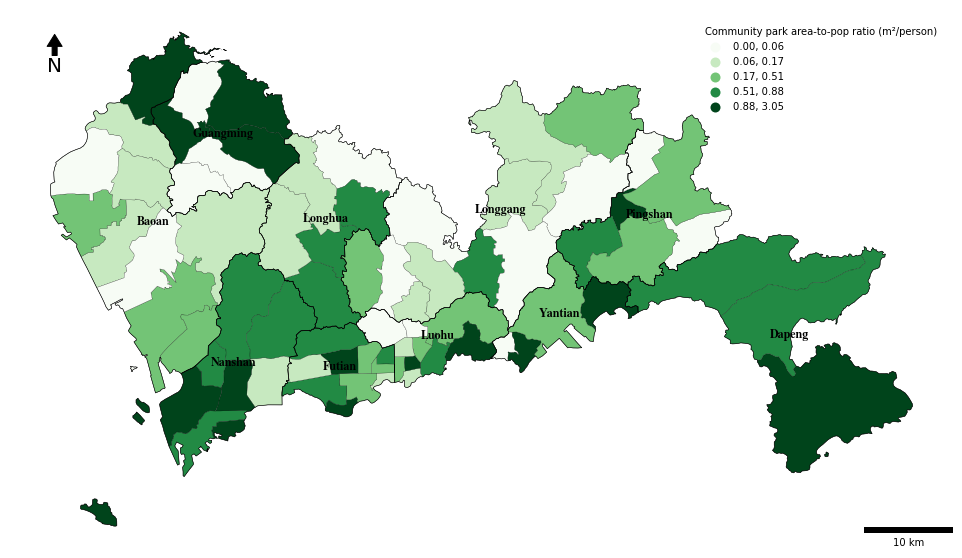

In [1475]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.6)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
subdistrict_merge.plot(column='compark_per_pop', scheme='quantiles', k=5, 
                 legend=True, legend_kwds={'title': 'Community park area-to-pop ratio (m²/person)'}, 
                 ax=ax, edgecolor='black', linewidth=0.2, cmap='Greens')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

plt.savefig("tmp/Community park area-to-popoulation ratio.png", dpi=300, bbox_inches='tight')

plt.show()


### fig.City park area-to-popoulation ratio

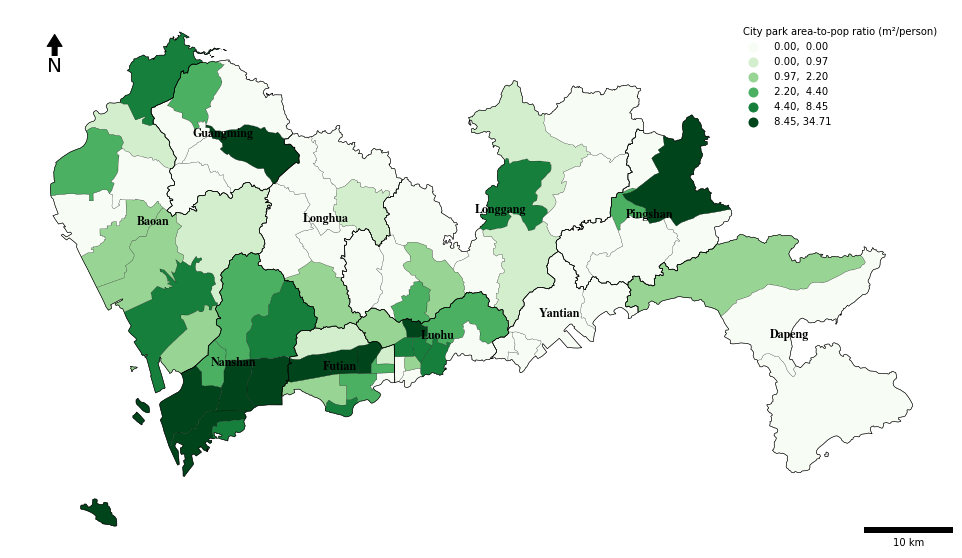

In [1474]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.6)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
subdistrict_merge.plot(column='citypark_per_pop', scheme='quantiles', k=8, 
                 legend=True, legend_kwds={'title': 'City park area-to-pop ratio (m²/person)'}, 
                 ax=ax, edgecolor='black', linewidth=0.2, cmap='Greens')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

plt.savefig("tmp/City park area-to-popoulation ratio.png", dpi=300, bbox_inches='tight')

plt.show()


### fig.Nature park area-to-pop ratio

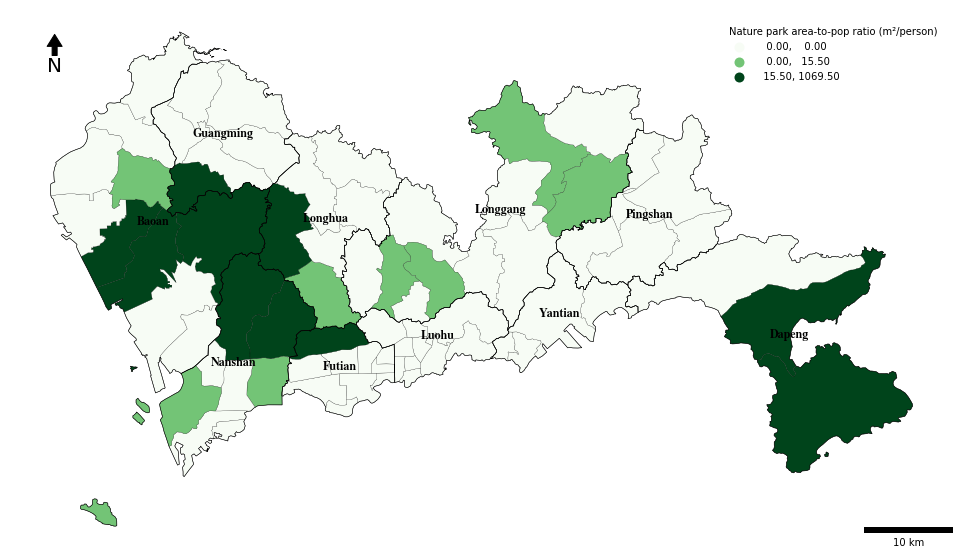

In [1473]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.6)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
subdistrict_merge.plot(column='napark_per_pop', scheme='quantiles', k=8, 
                 legend=True, legend_kwds={'title': 'Nature park area-to-pop ratio (m²/person)'}, 
                 ax=ax, edgecolor='black', linewidth=0.2, cmap='Greens')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

plt.savefig("tmp/Nature park area-to-popoulation ratio.png", dpi=300, bbox_inches='tight')

plt.show()


In [1476]:
subdistrict_merge

OBJECTID  Name    Shape_Area  \
0          1  沙河街道  2.179247e+07   
1          2  粤海街道  1.807562e+07   
2         13  凤凰街道  2.598523e+07   
3         14  玉塘街道  2.532503e+07   
4         15  光明街道  3.424578e+07   
..       ...   ...           ...   
69        88  大鹏街道  8.879811e+07   
70        19  南山街道  3.875446e+07   
71        48  海山街道  8.851195e+06   
72        43  盐田街道  5.358986e+07   
73        30  坑梓街道  6.264222e+07   

                                             geometry       Ai_a        Ai_b  \
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...   0.561225   70.457945   
1   MULTIPOLYGON (((12681992.942 2575205.739, 1268...   4.197026   36.458905   
2   MULTIPOLYGON (((12687831.657 2598168.054, 1268...   0.000000    0.000000   
3   MULTIPOLYGON (((12678475.143 2600485.832, 1267...   0.000000    0.000000   
4   MULTIPOLYGON (((12689126.525 2603202.310, 1268...  30.642358  148.863520   
..                                                ...        ...         ...   
69  MULTIPOLYGON (((12738210.629 2583233.756, 1273...   6.059076    0.000000   
70  MULTIPOLYGON (((12677486.804 2576818.864, 1267...   2.658651   54.573755   
71  MULTIPOLYGON (((12717202.971 2578665.307, 1271...  47.291453    0.000000   
72  MULTIPOLYGON (((12717171.245 2586205.839, 1271...   3.539867    0.000000   
73  MULTIPOLYGON (((12738814.537 2595221.214, 1273...   0.457705  244.452068   

          Ai_c        Ai_d        Ai_e       Ai_f         Ai_g     Ai_d_f  \
0    19.365509   57.949446   26.839698  34.105319    78.994502  18.917178   
1     0.000000   32.257481   20.606623  38.933081    65.269501  20.984285   
2     0.000000    3.831414   22.881319  27.940043    67.918174  15.043822   
3   108.794420    0.000000   80.157991  24.716456    76.248107  13.327810   
4     0.000000  152.214674    0.194836  20.172572    47.043930  11.222033   
..         ...         ...         ...        ...          ...        ...   
69  523.967017    0.000000  508.350363   2.740849  4009.607997   1.478829   
70   10.127627   47.710130   11.189016  38.060544    58.143016  21.545728   
71    0.000000    0.000000    0.000000  15.003114    15.628892   7.824389   
72    0.000000    0.000000    0.000000  17.597140    38.945108   9.148234   
73    0.000000  227.534700    3.009139  98.976109   107.981597  56.968227   

           popsum  community_park_area  city_park_area  nature_park_area  \
0   176252.760885         25681.190520    2.551154e+06      3.116790e+05   
1   199270.150711        446374.870920    1.689998e+06      0.000000e+00   
2    68123.141570             0.000000    0.000000e+00      0.000000e+00   
3    85067.725235             0.000000    0.000000e+00      4.009310e+06   
4    52511.775509        132624.557026    5.784473e+05      0.000000e+00   
..            ...                  ...             ...               ...   
69   88645.993524         58124.341638    0.000000e+00      5.026383e+06   
70  213143.510262        321509.476659    3.635832e+06      4.675047e+05   
71   61638.445075        158958.243518    0.000000e+00      0.000000e+00   
72  122409.833718         48137.718881    0.000000e+00      0.000000e+00   
73  139078.004916         68559.787878    4.826771e+06      0.000000e+00   

    compark_per_pop  citypark_per_pop  napark_per_pop  
0          0.145707         14.474407        1.768364  
1          2.240049          8.480939        0.000000  
2          0.000000          0.000000        0.000000  
3          0.000000          0.000000       47.130796  
4          2.525616         11.015573        0.000000  
..              ...               ...             ...  
69         0.655691          0.000000       56.701754  
70         1.508418         17.058143        2.193380  
71         2.578881          0.000000        0.000000  
72         0.393250          0.000000        0.000000  
73         0.492959         34.705496        0.000000  

[74 rows x 19 columns]

### fig.GINI: 7 modes

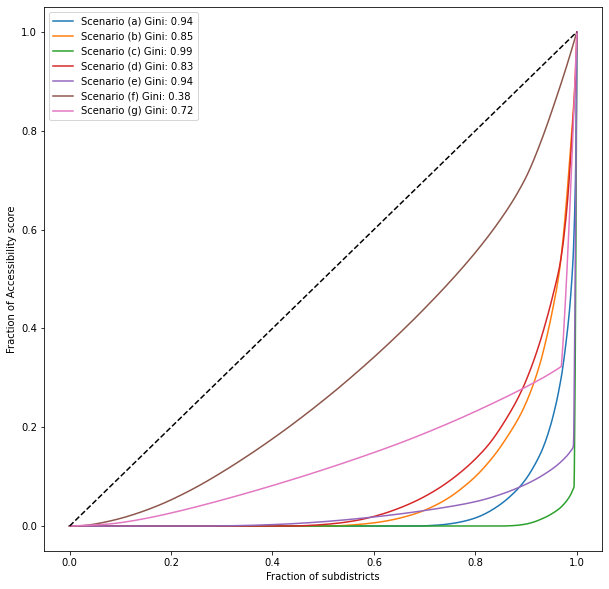

Gini coefficients: {'a': 0.9362533882852082, 'b': 0.8545048350892674, 'c': 0.989695021883373, 'd': 0.8306616347708277, 'e': 0.9415719713876405, 'f': 0.37542729539900116, 'g': 0.7224096778987908}


In [1965]:
import numpy as np
import matplotlib.pyplot as plt

def gini(x):
    # 计算基尼指数
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = np.mean(x)
    g = 0.5 * mad / rmad
    return g

def lorenz_curve(X):
    # 计算洛伦茨曲线
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    return X_lorenz

def plot_on_ax(df, scenario_name, ax):
    ai_df_values = df['Ai'].values
    ai_df_values_sorted = np.sort(ai_df_values)
    lorenz = lorenz_curve(ai_df_values_sorted)
    gini_coefficient = gini(ai_df_values)
    
    ax.plot(np.linspace(0.0, 1.0, lorenz.size), lorenz,
            label=f'Scenario ({scenario_name}) Gini: {gini_coefficient:.2f}')
    
    return gini_coefficient

# Plotting all curves on one figure
fig, ax = plt.subplots(figsize=(10, 10))
gini_values = {}
dataframes = [result_a, result_b, result_c, result_d, result_e, result_f, result_g]
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

for df, label in zip(dataframes, labels):
    gini_values[label] = plot_on_ax(df, label, ax)

# Common attributes for the plot
ax.plot([0, 1], [0, 1], color='k', linestyle='--')
ax.set_xlabel("Fraction of subdistricts")
ax.set_ylabel("Fraction of Accessibility score")
ax.legend(loc='upper left')

plt.savefig("tmp/GINI_7_scenarios.png", dpi=300, bbox_inches='tight')

plt.show()

print("Gini coefficients:", gini_values)


choose combine d+f to calcaulate Ai again, cause d,f GINI indes is the lowest above all.

### fig.GINI : Subdistrict

In [1851]:
result_d_f.head(2)

sum_pop  Popid   Ai                                           geometry
0  7276.136558      1  0.0  POLYGON ((12742557.833 2583965.856, 12742480.9...
1  1217.979429      2  0.0  POLYGON ((12745413.133 2576195.874, 12745295.9...

In [1852]:
subdistrict.head(2)

OBJECTID  Name    Shape_Area  \
0         1  沙河街道  2.179247e+07   
1         2  粤海街道  1.807562e+07   

                                            geometry  
0  MULTIPOLYGON (((12689522.017 2576929.913, 1268...  
1  MULTIPOLYGON (((12681992.942 2575205.739, 1268...

<AxesSubplot:>

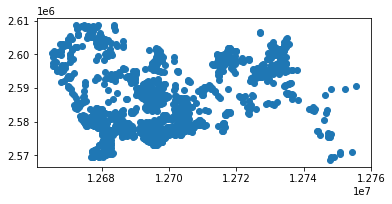

In [1996]:
popresid_gini = result_d_f.copy()
popresid_gini['geometry'] = popresid_gini['geometry'].centroid
popresid_gini.plot()

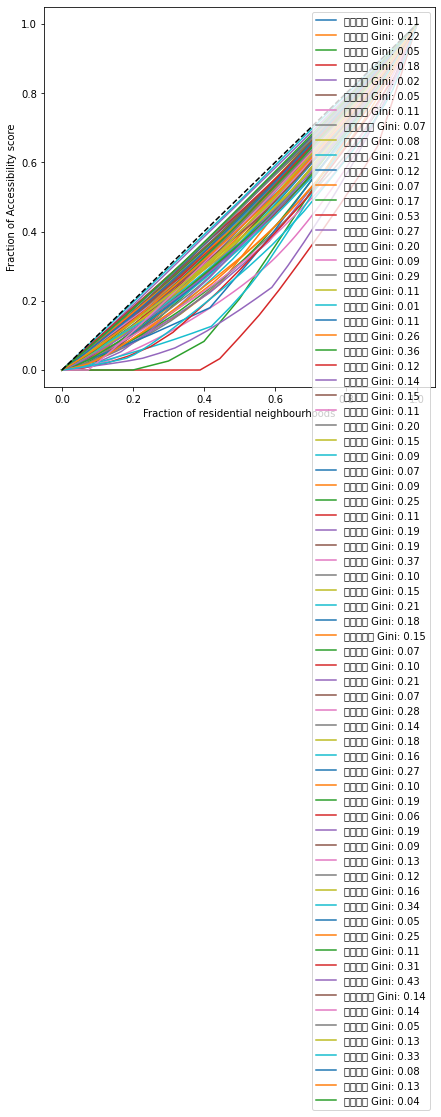

In [1997]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

def gini(x):
    # 计算基尼指数
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = np.mean(x)
    g = 0.5 * mad / rmad
    return g

def lorenz_curve(X):
    # 计算洛伦茨曲线
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    return X_lorenz

# Check and drop 'index_left' and 'index_right' columns if they exist in the dataframes
for df in [popresid_gini, subdistrict]:
    if 'index_left' in df.columns:
        df.drop(columns='index_left', inplace=True)
    if 'index_right' in df.columns:
        df.drop(columns='index_right', inplace=True)

# Use spatial join to connect the name of the district to subdistrict_merge
popresid_gini = gpd.sjoin(popresid_gini, subdistrict[['geometry', 'Name']], op='intersects')

# Group by district's Name
grouped = popresid_gini.groupby('Name')

# Create an empty Gini coefficient dictionary
gini_values = {}

fig, ax = plt.subplots(figsize=(7, 7))

for name, group in grouped:
    # Calculate the Gini coefficient within each district
    ai_df_values = group['Ai'].values
    ai_df_values_sorted = np.sort(ai_df_values)
    lorenz = lorenz_curve(ai_df_values_sorted)
    
    gini_value = gini(ai_df_values)
    gini_values[name] = gini_value
    
    ax.plot(np.linspace(0.0, 1.0, lorenz.size), lorenz, label=f'{name} Gini: {gini_value:.2f}')

# Add the Gini coefficient to the district's GeoDataFrame
popresid_gini['Gini'] = popresid_gini['Name'].map(gini_values)

ax.plot([0,1], [0,1], color='k', linestyle='--')
ax.set_xlabel("Fraction of residential neighbourhoods")
ax.set_ylabel("Fraction of Accessibility score")
ax.legend()

# plt.savefig("tmp/lorenz_subdistrict.png", dpi=300, bbox_inches='tight')

plt.show()


In [1999]:
popresid_gini = popresid_gini[['index_right', 'Name', 'Gini']]

In [2000]:
popresid_gini = popresid_gini.drop_duplicates(subset='Name', keep='first')

In [2001]:
popresid_gini = popresid_gini.rename(columns={'index_right': 'OBJECTID'})

In [2002]:
# 使用merge函数合并两个DataFrames
popresid_gini = popresid_gini.merge(subdistrict[['Name', 'geometry']], on='Name', how='left')

In [2003]:
popresid_gini = gpd.GeoDataFrame(popresid_gini, geometry='geometry', crs="EPSG:3587")

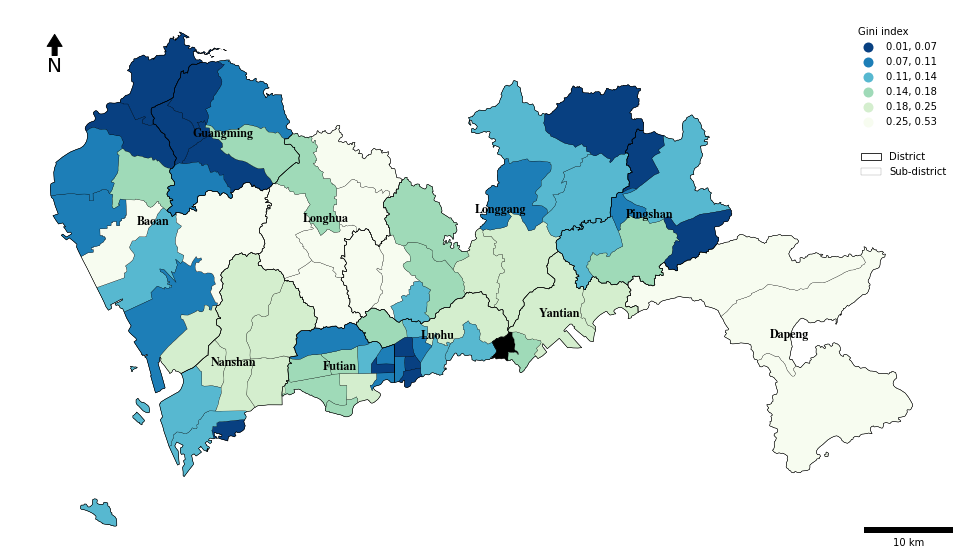

In [2136]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.5)
subdistrict.plot(ax=ax, color='black', linewidth=0.15)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
popresid_gini.plot(column='Gini', scheme='quantiles', k=6, 
                 legend=True, legend_kwds={'title': 'Gini index'}, 
                 ax=ax, edgecolor='black', linewidth=0.2, cmap='GnBu_r')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 0.75), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/GINI_subdistrict.png", dpi=300, bbox_inches='tight')

plt.show()


In [2005]:
popresid_gini.to_csv('tmp/popresid_gini.csv',index=False,encoding='utf-8')
popresid_gini.to_file('tmp/popresid_gini.geojson')

### fig.GINI : district

In [1983]:
district_gini = result_d_f.copy()
district_gini['geometry'] = district_gini['geometry'].centroid

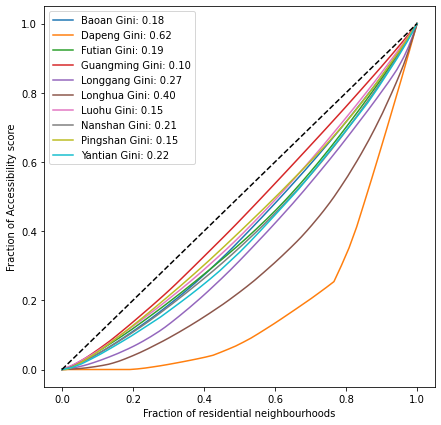

In [1984]:
def gini(x):
    # 计算基尼指数
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = np.mean(x)
    g = 0.5 * mad / rmad
    return g

def lorenz_curve(X):
    # 计算洛伦茨曲线
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    return X_lorenz

# Check and drop 'index_left' and 'index_right' columns if they exist in the dataframes
for df in [district_gini, district]:
    if 'index_left' in df.columns:
        df.drop(columns='index_left', inplace=True)
    if 'index_right' in df.columns:
        df.drop(columns='index_right', inplace=True)

# Use spatial join to connect the name of the district to district_merge
district_gini = gpd.sjoin(district_gini, district[['geometry', 'Name']], op='intersects')

# Group by district's Name
grouped = district_gini.groupby('Name')

# Create an empty Gini coefficient dictionary
gini_values = {}

fig, ax = plt.subplots(figsize=(7, 7))

for name, group in grouped:
    # Calculate the Gini coefficient within each district
    ai_df_values = group['Ai'].values
    ai_df_values_sorted = np.sort(ai_df_values)
    lorenz = lorenz_curve(ai_df_values_sorted)
    
    gini_value = gini(ai_df_values)
    gini_values[name] = gini_value
    
    ax.plot(np.linspace(0.0, 1.0, lorenz.size), lorenz, label=f'{name} Gini: {gini_value:.2f}')

# Add the Gini coefficient to the district's GeoDataFrame
district_gini['Gini'] = district_gini['Name'].map(gini_values)

ax.plot([0,1], [0,1], color='k', linestyle='--')
ax.set_xlabel("Fraction of residential neighbourhoods")
ax.set_ylabel("Fraction of Accessibility score")
ax.legend()

plt.savefig("tmp/lorenz_district.png", dpi=300, bbox_inches='tight')

plt.show()


In [2303]:
print(district_gini.sort_values(by='Gini'))

        Name      Gini                                           geometry
9  Guangming  0.101909  MULTIPOLYGON (((12683239.951 2596946.898, 1268...
4   Pingshan  0.152037  MULTIPOLYGON (((12723684.103 2587421.740, 1272...
2      Luohu  0.154806  MULTIPOLYGON (((12703456.016 2575791.592, 1270...
8      Baoan  0.177370  MULTIPOLYGON (((12672480.032 2577440.163, 1267...
5     Futian  0.188232  MULTIPOLYGON (((12693589.435 2573337.118, 1269...
6    Nanshan  0.205301  MULTIPOLYGON (((12669632.479 2559715.306, 1266...
3    Yantian  0.218154  MULTIPOLYGON (((12716826.377 2578251.612, 1271...
1   Longgang  0.268737  MULTIPOLYGON (((12709988.132 2590719.668, 1270...
7    Longhua  0.401021  MULTIPOLYGON (((12695744.692 2587077.656, 1269...
0     Dapeng  0.618800  MULTIPOLYGON (((12750337.217 2567762.837, 1275...


In [1985]:
district_gini = district_gini[[ 'Name', 'Gini']]

In [1986]:
district_gini = district_gini.drop_duplicates(subset='Name', keep='first')

In [1987]:
# 使用merge函数合并两个DataFrames
district_gini = district_gini.merge(district[['Name', 'geometry']], on='Name', how='left')

In [1989]:
district_gini = gpd.GeoDataFrame(district_gini, geometry='geometry', crs="EPSG:3587")

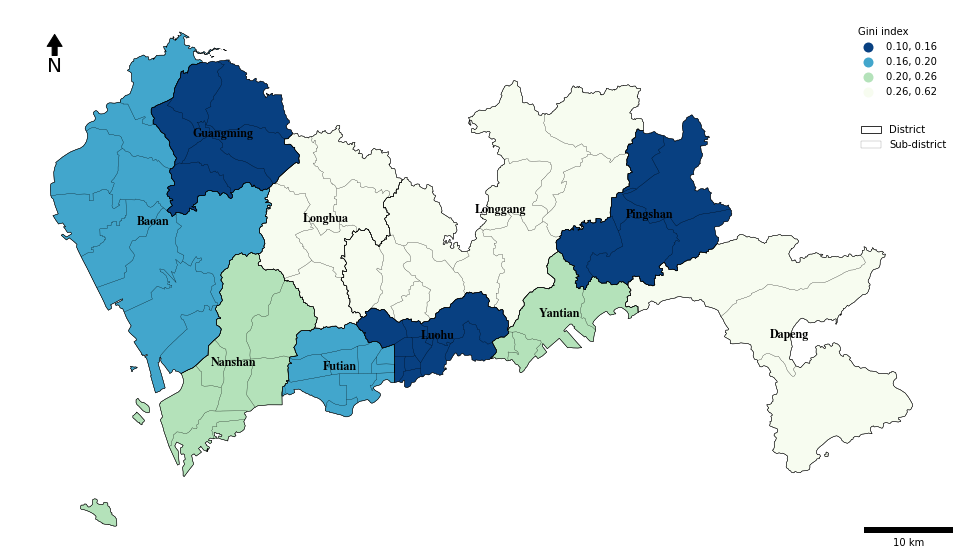

In [2139]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.5)
subdistrict.boundary.plot(ax=ax, color='black', linewidth=0.15)

# 绘制区的名字
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# 使用cmap参数更改配色
district_gini.plot(column='Gini', scheme='quantiles', k=4, 
                 legend=True, legend_kwds={'title': 'Gini index'}, 
                 ax=ax, edgecolor='black', linewidth=0.2, cmap='GnBu_r')

# 关闭坐标轴
ax.axis('off')

# 添加指北针
x, y, arrow_length = 0.05, 0.95, 0.06  # 设置箭头位置和长度
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# 添加比例尺
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # 设置单位和比例尺长度
ax.add_artist(scalebar)

# 调整图例位置和大小
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 0.8), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/GINI_district.png", dpi=300, bbox_inches='tight')

plt.show()


### fig.GINI : city

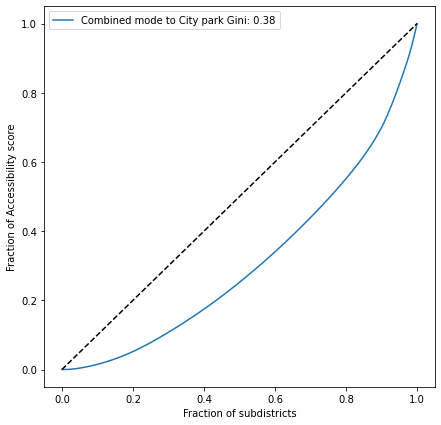

In [1976]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def gini(x):
    # 计算基尼指数
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = np.mean(x)
    g = 0.5 * mad / rmad
    return g

def lorenz_curve(X):
    # 计算洛伦茨曲线
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    X_lorenz[0], X_lorenz[-1]
    return X_lorenz

# 获取整个城市的 Ai 值并排序
ai_df_values = result_d_f['Ai'].values
ai_df_values_sorted = np.sort(ai_df_values)

# 计算洛伦茨曲线
lorenz = lorenz_curve(ai_df_values_sorted)

# 绘制
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(np.linspace(0.0, 1.0, lorenz.size), lorenz,
        label=f'Combined mode to City park Gini: {gini(ai_df_values):.2f}')
ax.plot([0,1], [0,1], color='k', linestyle='--')
ax.set_xlabel("Fraction of subdistricts")
ax.set_ylabel("Fraction of Accessibility score")
ax.legend()

plt.savefig("tmp/lorenz_city.png", dpi=300, bbox_inches='tight')

plt.show()


## 5.K-means

In [1596]:
district_merge

OBJECTID Name_left    Shape_Area  \
0          1      沙河街道  2.179247e+07   
1          2      粤海街道  1.807562e+07   
8         21      南头街道  1.159893e+07   
9         22      招商街道  1.979902e+07   
10        23      蛇口街道  5.614567e+06   
..       ...       ...           ...   
45        64      黄贝街道  8.786313e+06   
46        65      东门街道  2.434607e+06   
47        66      翠竹街道  3.957815e+06   
48        67      笋岗街道  4.075540e+06   
49        68      东晓街道  4.200428e+06   

                                             geometry      Ai_a       Ai_b  \
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...  0.561225  70.457945   
1   MULTIPOLYGON (((12681992.942 2575205.739, 1268...  4.197026  36.458905   
8   MULTIPOLYGON (((12681978.812 2575223.465, 1268...  1.423022  13.113421   
9   MULTIPOLYGON (((12676127.303 2568622.002, 1267...  2.325570  75.082435   
10  MULTIPOLYGON (((12684644.024 2571628.707, 1268...  3.587904  41.084037   
..                                                ...       ...        ...   
45  MULTIPOLYGON (((12707332.049 2578229.313, 1270...  2.582113  27.137673   
46  MULTIPOLYGON (((12704445.869 2577438.837, 1270...  0.754442  34.213138   
47  MULTIPOLYGON (((12704417.816 2578046.095, 1270...  2.183230  26.084387   
48  MULTIPOLYGON (((12703815.578 2578835.152, 1270...  2.451674  44.865057   
49  MULTIPOLYGON (((12705141.504 2580973.607, 1270...  0.301975  79.936069   

         Ai_c       Ai_d       Ai_e       Ai_f  ...         popsum  \
0   19.365509  57.949446  26.839698  34.105319  ...  176252.760885   
1    0.000000  32.257481  20.606623  38.933081  ...  199270.150711   
8    0.000000  16.891612  41.186993  44.068357  ...  292999.025503   
9    0.905510  80.218062   7.016061  29.489522  ...  174071.044744   
10   0.000000  33.609490   7.990132  26.839261  ...   56896.324958   
..        ...        ...        ...        ...  ...            ...   
45   0.000000  23.533207  21.542621  27.447229  ...  170884.601515   
46   0.000000   7.725285  24.599140  24.684480  ...   78126.310413   
47   0.000000  47.192864  28.052768  29.500394  ...  113717.464394   
48   0.000000  99.957249  37.980436  29.302435  ...  133317.559802   
49   0.000000  47.219193   0.669883  28.398331  ...   84783.438097   

    community_park_area  city_park_area  nature_park_area  compark_per_pop  \
0          25681.190520    2.551154e+06     311679.022157         0.145707   
1         446374.870920    1.689998e+06          0.000000         2.240049   
8         187046.408334    8.988408e+05          0.000000         0.638386   
9         147970.519210    2.540647e+06          0.000000         0.850058   
10         68611.250999    4.609467e+05          0.000000         1.205900   
..                  ...             ...               ...              ...   
45        116532.628043    9.297943e+05          0.000000         0.681938   
46        165623.321845    1.354938e+05          0.000000         2.119943   
47         33282.754566    5.118802e+05          0.000000         0.292679   
48         11839.957037    6.911269e+05          0.000000         0.088810   
49          4723.474796    1.115519e+06          0.000000         0.055712   

    citypark_per_pop  napark_per_pop  index_right  Name_right      Gini  
0          14.474407        1.768364            6     Nanshan  0.086452  
1           8.480939        0.000000            6     Nanshan  0.086452  
8           3.067726        0.000000            6     Nanshan  0.086452  
9          14.595462        0.000000            6     Nanshan  0.086452  
10          8.101521        0.000000            6     Nanshan  0.086452  
..               ...             ...          ...         ...       ...  
45          5.441066        0.000000            9       Luohu  0.057998  
46          1.734292        0.000000            9       Luohu  0.057998  
47          4.501333        0.000000            9       Luohu  0.057998  
48          5.184065        0.000000            9       Luohu  0.057

In [1597]:
district_merge['pop_densy'] = district_merge['popsum']/district_merge['Shape_Area']

In [1513]:
# ODd_Gaode = pd.read_csv('tmp/ODd_Gaode.csv')
# ODf_Gaode = pd.read_csv('tmp/ODf_Gaode.csv')

In [1781]:
# calculate pop weighted cost time

In [1522]:
# 使用groupby计算平均值和sum_pop
grouped_f = ODf_Gaode.groupby('Popid').agg({'cost': 'mean', 'sum_pop': 'first'}).reset_index()
grouped_f = grouped_f.rename(columns={'cost': 'avg_cost_f'})

grouped_d = ODd_Gaode.groupby('Popid').agg({'cost': 'mean', 'sum_pop': 'first'}).reset_index()
grouped_d = grouped_d.rename(columns={'cost': 'avg_cost_d'})

In [1525]:
grouped_d

Popid   avg_cost_d       sum_pop  weighted_avg_cost
0         5  2178.000000  11243.644833       1.101990e+07
1         6  1927.000000    875.631427       7.593038e+05
2         7  1682.000000    244.115629       1.847711e+05
3         8  1541.000000   1987.896567       1.378507e+06
4         9  1803.500000    480.767980       3.901793e+05
...     ...          ...           ...                ...
1309   2055  2025.666667    391.746097       3.570962e+05
1310   2057  1758.000000    176.790457       1.398589e+05
1311   2062  1769.000000    330.748679       2.632925e+05
1312   2070  1730.000000    504.475622       3.927343e+05
1313   2079  2542.000000   1589.763618       1.818531e+06

[1314 rows x 4 columns]

In [1526]:
grouped_f

Popid   avg_cost_f       sum_pop  weighted_avg_cost
0         1  4592.500000   7276.136558       1.837861e+07
1         2  2744.000000   1217.979429       1.838175e+06
2         4  1716.200000   2048.236732       1.933351e+06
3         5  1851.260000  11243.644833       1.144820e+07
4         6  1918.578947    875.631427       9.239824e+05
...     ...          ...           ...                ...
1822   2077  1889.933333    325.056286       3.378841e+05
1823   2078  1823.178571   6592.324279       6.610441e+06
1824   2079  1630.983051   1589.763618       1.426083e+06
1825   2080  1781.328358    149.804736       1.467683e+05
1826   2081  1773.037037    305.918748       2.983229e+05

[1827 rows x 4 columns]

In [1530]:
# 计算人口加权的avg_cost
grouped_d['weighted_avg_cost'] = grouped_d['avg_cost_d'] * grouped_d['sum_pop'] * 0.45
grouped_f['weighted_avg_cost'] = grouped_f['avg_cost_f'] * grouped_f['sum_pop'] * 0.55

# 合并两个数据框
merged = pd.merge(grouped_d[['Popid', 'weighted_avg_cost','sum_pop']], grouped_f[['Popid', 'weighted_avg_cost']], on='Popid', how='outer', suffixes=('_d', '_f'))

# 计算总人口加权的avg_cost
merged['avg_cost'] = (merged['weighted_avg_cost_d'] + merged['weighted_avg_cost_f']) / (merged['sum_pop'])

merged.fillna(0, inplace=True)

merged

Popid  weighted_avg_cost_d       sum_pop  weighted_avg_cost_f  \
0         5         1.101990e+07  11243.644833         1.144820e+07   
1         6         7.593038e+05    875.631427         9.239824e+05   
2         7         1.847711e+05    244.115629         2.462995e+05   
3         8         1.378507e+06   1987.896567         1.646727e+06   
4         9         3.901793e+05    480.767980         4.186421e+05   
...     ...                  ...           ...                  ...   
1822   2076         0.000000e+00      0.000000         9.342479e+04   
1823   2077         0.000000e+00      0.000000         3.378841e+05   
1824   2078         0.000000e+00      0.000000         6.610441e+06   
1825   2080         0.000000e+00      0.000000         1.467683e+05   
1826   2081         0.000000e+00      0.000000         2.983229e+05   

         avg_cost  
0     1998.293000  
1     1922.368421  
2     1765.846053  
3     1521.826744  
4     1682.352907  
...           ...  
1822     0.000000  
1823     0.000000  
1824     0.000000  
1825     0.000000  
1826     0.000000  

[1827 rows x 5 columns]

In [1531]:
merged.describe()

Popid  weighted_avg_cost_d       sum_pop  weighted_avg_cost_f  \
count  1827.000000         1.827000e+03   1827.000000         1.827000e+03   
mean   1038.648604         5.907411e+05    746.048065         9.197808e+05   
std     611.489416         1.193271e+06   1399.841900         1.623211e+06   
min       1.000000         0.000000e+00      0.000000         4.443269e+03   
25%     505.500000         0.000000e+00      0.000000         2.143503e+05   
50%    1021.000000         2.304283e+05    316.092220         4.679758e+05   
75%    1587.500000         6.551574e+05    870.079392         1.002249e+06   
max    2081.000000         2.600864e+07  26058.146784         2.805740e+07   

          avg_cost  
count  1827.000000  
mean   1172.517336  
std     765.634736  
min       0.000000  
25%       0.000000  
50%    1498.621774  
75%    1712.038333  
max    2715.290769

In [1532]:
# 使用merge将avg_cost列连接到pop_resid
pop_resid = pop_resid.merge(merged[['Popid', 'avg_cost']], on='Popid', how='left')

# 如果有些pop_resid中的Popid在merged中没有，avg_cost的值将会是NaN。用0替换NaN
pop_resid['avg_cost'].fillna(0, inplace=True)


In [1780]:
# calculate pop weighted park area

In [1776]:
# 使用groupby计算area
grouped_f_area = ODf_Gaode.groupby('Popid').agg({'area': 'mean', 'sum_pop': 'first'}).reset_index()
grouped_f_area = grouped_f_area.rename(columns={'area': 'avg_area_f'})

grouped_d_area = ODd_Gaode.groupby('Popid').agg({'area': 'mean', 'sum_pop': 'first'}).reset_index()
grouped_d_area = grouped_d_area.rename(columns={'area': 'avg_area_d'})

In [1777]:
# 计算人口加权的avg_cost
grouped_d_area['weighted_avg_area'] = grouped_d_area['avg_area_d'] * grouped_d_area['sum_pop'] * 0.45
grouped_f_area['weighted_avg_area'] = grouped_f_area['avg_area_f'] * grouped_f_area['sum_pop'] * 0.55

# 合并两个数据框
merged_area = pd.merge(grouped_d_area[['Popid', 'weighted_avg_area','sum_pop']], grouped_f_area[['Popid', 'weighted_avg_area']], on='Popid', how='outer', suffixes=('_d', '_f'))

# 计算总人口加权的avg_cost
merged_area['avg_area'] = (merged_area['weighted_avg_area_d'] + merged_area['weighted_avg_area_f']) / (merged_area['sum_pop'])

merged_area.fillna(0, inplace=True)


Popid  weighted_avg_cost_d       sum_pop  weighted_avg_cost_f  \
0         5         1.101990e+07  11243.644833         1.144820e+07   
1         6         7.593038e+05    875.631427         9.239824e+05   
2         7         1.847711e+05    244.115629         2.462995e+05   
3         8         1.378507e+06   1987.896567         1.646727e+06   
4         9         3.901793e+05    480.767980         4.186421e+05   
...     ...                  ...           ...                  ...   
1822   2076         0.000000e+00      0.000000         9.342479e+04   
1823   2077         0.000000e+00      0.000000         3.378841e+05   
1824   2078         0.000000e+00      0.000000         6.610441e+06   
1825   2080         0.000000e+00      0.000000         1.467683e+05   
1826   2081         0.000000e+00      0.000000         2.983229e+05   

         avg_cost  
0     1998.293000  
1     1922.368421  
2     1765.846053  
3     1521.826744  
4     1682.352907  
...           ...  
1822     0.000000  
1823     0.000000  
1824     0.000000  
1825     0.000000  
1826     0.000000  

[1827 rows x 5 columns]

In [1778]:
merged_area

Popid  weighted_avg_area_d       sum_pop  weighted_avg_area_f  \
0         5         5.644313e+09  11243.644833         3.239825e+09   
1         6         1.109022e+08    875.631427         2.586805e+08   
2         7         3.091822e+07    244.115629         6.511473e+07   
3         8         5.336655e+08   1987.896567         6.022469e+08   
4         9         1.417335e+08    480.767980         1.456519e+08   
...     ...                  ...           ...                  ...   
1822   2076         0.000000e+00      0.000000         3.239584e+07   
1823   2077         0.000000e+00      0.000000         9.726525e+07   
1824   2078         0.000000e+00      0.000000         2.169647e+09   
1825   2080         0.000000e+00      0.000000         4.865257e+07   
1826   2081         0.000000e+00      0.000000         1.007427e+08   

           avg_area  
0     790147.494771  
1     422075.688496  
2     393391.256217  
3     571414.197301  
4     597763.361139  
...             ...  
1822       0.000000  
1823       0.000000  
1824       0.000000  
1825       0.000000  
1826       0.000000  

[1827 rows x 5 columns]

In [1779]:
# 使用merge将avg_cost列连接到pop_resid
pop_resid = pop_resid.merge(merged_area[['Popid', 'avg_area']], on='Popid', how='left')

# 如果有些pop_resid中的Popid在merged中没有，avg_cost的值将会是NaN。用0替换NaN
pop_resid['avg_area'].fillna(0, inplace=True)


In [1782]:
pop_resid.head(3)

name      sum_pop                                           geometry  \
0   None  7276.136558  POLYGON ((12742557.833 2583965.856, 12742480.9...   
1   None  1217.979429  POLYGON ((12745413.133 2576195.874, 12745295.9...   
2  ?????  2048.236732  POLYGON ((12709691.109 2588710.751, 12709781.1...   

                          cen  Popid   longitude   latitude          area  \
0  POINT (114.47232 22.59552)      1  114.472319  22.595523  2.228591e+06   
1  POINT (114.48832 22.53681)      2  114.488317  22.536814  6.199168e+05   
2  POINT (114.17423 22.63940)      4  114.174231  22.639398  2.236799e+05   

   avg_cost  avg_area  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0

In [1598]:
# 使用空间连接将每个pop_resid点与其对应的subdistrict连接
joined = gpd.sjoin(pop_resid, district_merge[['OBJECTID', 'geometry']], how="inner", op="intersects")

# 计算每个district的人口加权avg_cost
joined['weighted_avg_cost'] = joined['avg_cost'] * joined['sum_pop']
grouped = joined.groupby('OBJECTID').apply(lambda g: g['weighted_avg_cost'].sum() / g['sum_pop'].sum()).reset_index()
grouped.columns = ['OBJECTID', 'wted_avg_cost']

# 将结果合并到district_merge中
district_merge = district_merge.merge(grouped, on='OBJECTID', how='left')


### K-means by subdistricts

In [1794]:
district_merge.head(2)

OBJECTID Name_left    Shape_Area  \
0         1      沙河街道  2.179247e+07   
1         2      粤海街道  1.807562e+07   

                                            geometry      Ai_a       Ai_b  \
0  MULTIPOLYGON (((12689522.017 2576929.913, 1268...  0.561225  70.457945   
1  MULTIPOLYGON (((12681992.942 2575205.739, 1268...  4.197026  36.458905   

        Ai_c       Ai_d       Ai_e       Ai_f  ...  city_park_area  \
0  19.365509  57.949446  26.839698  34.105319  ...    2.551154e+06   
1   0.000000  32.257481  20.606623  38.933081  ...    1.689998e+06   

   nature_park_area  compark_per_pop  citypark_per_pop  napark_per_pop  \
0     311679.022157         0.145707         14.474407        1.768364   
1          0.000000         2.240049          8.480939        0.000000   

   index_right  Name_right      Gini  pop_densy  wted_avg_cost  
0            6     Nanshan  0.086452   0.008088    1353.249720  
1            6     Nanshan  0.086452   0.011024    1559.752487  

[2 rows x 24 columns]

In [1600]:
district_merge.describe()

OBJECTID    Shape_Area        Ai_a        Ai_b          Ai_c  \
count  74.000000  7.400000e+01   74.000000   74.000000     74.000000   
mean   50.000000  3.099464e+07    5.409950   28.398066    954.939831   
std    23.376021  2.535248e+07   14.617389   40.415306   7818.838659   
min     1.000000  2.434607e+06    0.000000    0.000000      0.000000   
25%    31.250000  1.129123e+07    0.001126    0.000000      0.000000   
50%    51.500000  2.724936e+07    1.431887    9.198211      0.000000   
75%    69.750000  4.142398e+07    3.577032   43.930791      0.679132   
max    88.000000  1.352320e+08  111.097364  244.452068  67298.081494   

             Ai_d          Ai_e       Ai_f         Ai_g     Ai_d_f  ...  \
count   74.000000     74.000000  74.000000    74.000000  74.000000  ...   
mean    26.786493    393.409335  29.728749   247.634162  16.096980  ...   
std     37.873704   3040.314480  19.204224   839.258942  10.374174  ...   
min      0.000000      0.000000   0.000000     0.000000   0.000000  ...   
25%      0.000000      2.103464  20.530954    40.391897  10.886143  ...   
50%     12.100625     22.131128  27.661389    50.009924  15.009840  ...   
75%     47.003978     41.766239  32.112351    66.977211  17.734233  ...   
max    227.534700  26186.738619  98.976109  4339.753312  56.968227  ...   

       community_park_area  city_park_area  nature_park_area  compark_per_pop  \
count            74.000000    7.400000e+01      7.400000e+01        74.000000   
mean          87871.826366    6.835586e+05      2.101722e+06         0.556473   
std           95692.611888    1.146390e+06      7.128088e+06         0.686599   
min               0.000000    0.000000e+00      0.000000e+00         0.000000   
25%           16718.181472    0.000000e+00      0.000000e+00         0.082663   
50%           58271.988180    1.389942e+05      0.000000e+00         0.287673   
75%          133789.509790    7.988815e+05      0.000000e+00         0.675376   
max          446374.870920    5.456005e+06      5.492925e+07         3.046905   

       citypark_per_pop  napark_per_pop  index_right       Gini  pop_densy  \
count         74.000000       74.000000    74.000000  74.000000  74.000000   
mean           3.375881       19.350017     4.418919   0.157276   0.011874   
std            5.715051      124.452908     2.928400   0.114097   0.009575   
min            0.000000        0.000000     0.000000   0.057998   0.000380   
25%            0.000000        0.000000     2.000000   0.087299   0.004265   
50%            0.973331        0.000000     4.000000   0.108130   0.009800   
75%            4.402760        0.000000     7.000000   0.201796   0.015851   
max           34.705496     1069.497055     9.000000   0.556051   0.033973   

       wted_avg_cost  
count      73.000000  
mean      978.130364  
std       638.342402  
min         0.000000  
25%       372.902638  
50%      1292.574312  
75%      1520.043265  
max      1704.344433  

[8 rows x 21 columns]

In [1601]:
district_merge.columns

Index(['OBJECTID', 'Name_left', 'Shape_Area', 'geometry', 'Ai_a', 'Ai_b',
       'Ai_c', 'Ai_d', 'Ai_e', 'Ai_f', 'Ai_g', 'Ai_d_f', 'popsum',
       'community_park_area', 'city_park_area', 'nature_park_area',
       'compark_per_pop', 'citypark_per_pop', 'napark_per_pop', 'index_right',
       'Name_right', 'Gini', 'pop_densy', 'wted_avg_cost'],
      dtype='object')

In [1612]:
k_merged = district_merge[['OBJECTID', 'Name_left','Shape_Area', 'geometry','Ai_d_f','popsum','city_park_area','citypark_per_pop','Name_right','pop_densy', 'wted_avg_cost']]

In [1608]:
k_merged = k_merged.fillna(0)

In [1606]:
k_merged

OBJECTID Name_left    Shape_Area  \
0          1      沙河街道  2.179247e+07   
1          2      粤海街道  1.807562e+07   
2         21      南头街道  1.159893e+07   
3         22      招商街道  1.979902e+07   
4         23      蛇口街道  5.614567e+06   
..       ...       ...           ...   
69        64      黄贝街道  8.786313e+06   
70        65      东门街道  2.434607e+06   
71        66      翠竹街道  3.957815e+06   
72        67      笋岗街道  4.075540e+06   
73        68      东晓街道  4.200428e+06   

                                             geometry     Ai_d_f  \
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...  18.917178   
1   MULTIPOLYGON (((12681992.942 2575205.739, 1268...  20.984285   
2   MULTIPOLYGON (((12681978.812 2575223.465, 1268...  23.380095   
3   MULTIPOLYGON (((12676127.303 2568622.002, 1267...  17.793652   
4   MULTIPOLYGON (((12684644.024 2571628.707, 1268...  14.402038   
..                                                ...        ...   
69  MULTIPOLYGON (((12707332.049 2578229.313, 1270...  15.023486   
70  MULTIPOLYGON (((12704445.869 2577438.837, 1270...  13.222310   
71  MULTIPOLYGON (((12704417.816 2578046.095, 1270...  16.851001   
72  MULTIPOLYGON (((12703815.578 2578835.152, 1270...  16.267956   
73  MULTIPOLYGON (((12705141.504 2580973.607, 1270...  15.811256   

           popsum  city_park_area  citypark_per_pop Name_right  pop_densy  \
0   176252.760885    2.551154e+06         14.474407    Nanshan   0.008088   
1   199270.150711    1.689998e+06          8.480939    Nanshan   0.011024   
2   292999.025503    8.988408e+05          3.067726    Nanshan   0.025261   
3   174071.044744    2.540647e+06         14.595462    Nanshan   0.008792   
4    56896.324958    4.609467e+05          8.101521    Nanshan   0.010134   
..            ...             ...               ...        ...        ...   
69  170884.601515    9.297943e+05          5.441066      Luohu   0.019449   
70   78126.310413    1.354938e+05          1.734292      Luohu   0.032090   
71  113717.464394    5.118802e+05          4.501333      Luohu   0.028732   
72  133317.559802    6.911269e+05          5.184065      Luohu   0.032712   
73   84783.438097    1.115519e+06         13.157278      Luohu   0.020184   

    wted_avg_cost  
0     1353.249720  
1     1559.752487  
2     1465.834825  
3     1669.356751  
4     1700.404718  
..            ...  
69    1541.280618  
70    1631.463106  
71    1501.206908  
72    1402.718674  
73    1570.977727  

[74 rows x 11 columns]

In [1609]:
print(k_merged.isnull().sum())

OBJECTID            0
Name_left           0
Shape_Area          0
geometry            0
Ai_d_f              0
popsum              0
city_park_area      0
citypark_per_pop    0
Name_right          0
pop_densy           0
wted_avg_cost       0
dtype: int64


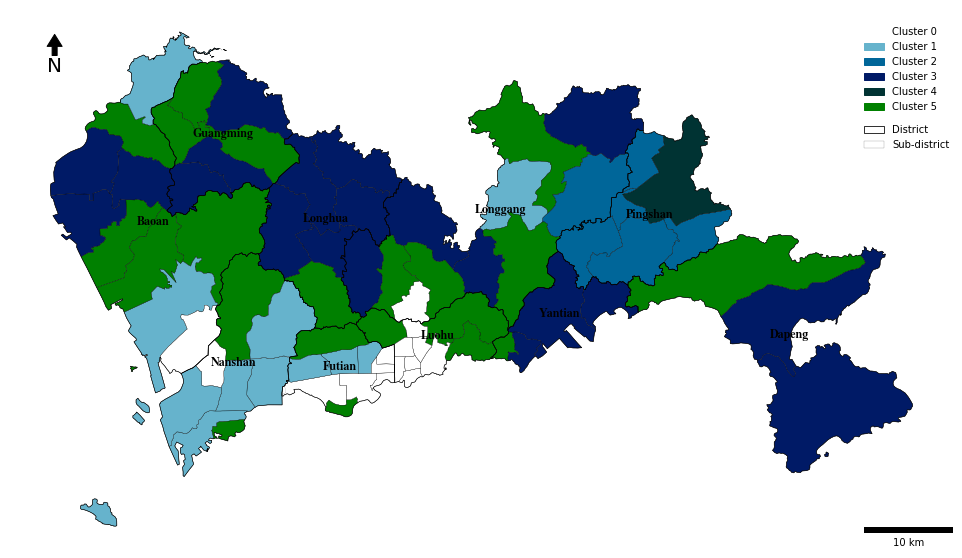

In [2322]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Choose features
features = ['Ai_d_f', 'city_park_area', 'pop_densy', 'wted_avg_cost']
X = k_merged[features]
# Fill NaN
X = X.fillna(X.median())

# K-means
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=6, random_state=5)
k_merged['cluster'] = kmeans.fit_predict(X_scaled)

# Set up the figure
fig, ax = plt.subplots(figsize=(20, 10))

district.boundary.plot(ax=ax, color='black', linewidth=0.6)
subdistrict.boundary.plot(ax=ax, color='black', linewidth=0.1)


# Plot district names
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# Use cmap parameter to change colors
k_merged.plot(column='cluster', legend=False, ax=ax, edgecolor='black', linewidth=0.2, cmap='ocean_r')

# Create custom legend
colors = plt.cm.ocean_r([0, 0.20, 0.40, 0.60, 0.80, 1])  # or adjust accordingly
labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(6)]
ax.legend(handles=patches, loc='upper right')

# Turn off coordinate axis
ax.axis('off')

# Add a north arrow
x, y, arrow_length = 0.05, 0.95, 0.06  # set arrow position and length
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# Add a scale bar (Assuming you've already imported the necessary library/module for the scale bar)
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # set unit and scale length
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.003, 0.8), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

# plt.savefig("tmp/K-means.png", dpi=300, bbox_inches='tight')

plt.show()


In [1766]:
pd.set_option('display.max_rows', 10)
k_merged

OBJECTID Name_left    Shape_Area  \
0          1      沙河街道  2.179247e+07   
1          2      粤海街道  1.807562e+07   
2         21      南头街道  1.159893e+07   
3         22      招商街道  1.979902e+07   
4         23      蛇口街道  5.614567e+06   
..       ...       ...           ...   
69        64      黄贝街道  8.786313e+06   
70        65      东门街道  2.434607e+06   
71        66      翠竹街道  3.957815e+06   
72        67      笋岗街道  4.075540e+06   
73        68      东晓街道  4.200428e+06   

                                             geometry     Ai_d_f  \
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...  18.917178   
1   MULTIPOLYGON (((12681992.942 2575205.739, 1268...  20.984285   
2   MULTIPOLYGON (((12681978.812 2575223.465, 1268...  23.380095   
3   MULTIPOLYGON (((12676127.303 2568622.002, 1267...  17.793652   
4   MULTIPOLYGON (((12684644.024 2571628.707, 1268...  14.402038   
..                                                ...        ...   
69  MULTIPOLYGON (((12707332.049 2578229.313, 1270...  15.023486   
70  MULTIPOLYGON (((12704445.869 2577438.837, 1270...  13.222310   
71  MULTIPOLYGON (((12704417.816 2578046.095, 1270...  16.851001   
72  MULTIPOLYGON (((12703815.578 2578835.152, 1270...  16.267956   
73  MULTIPOLYGON (((12705141.504 2580973.607, 1270...  15.811256   

           popsum  city_park_area  citypark_per_pop Name_right  pop_densy  \
0   176252.760885    2.551154e+06         14.474407    Nanshan   0.008088   
1   199270.150711    1.689998e+06          8.480939    Nanshan   0.011024   
2   292999.025503    8.988408e+05          3.067726    Nanshan   0.025261   
3   174071.044744    2.540647e+06         14.595462    Nanshan   0.008792   
4    56896.324958    4.609467e+05          8.101521    Nanshan   0.010134   
..            ...             ...               ...        ...        ...   
69  170884.601515    9.297943e+05          5.441066      Luohu   0.019449   
70   78126.310413    1.354938e+05          1.734292      Luohu   0.032090   
71  113717.464394    5.118802e+05          4.501333      Luohu   0.028732   
72  133317.559802    6.911269e+05          5.184065      Luohu   0.032712   
73   84783.438097    1.115519e+06         13.157278      Luohu   0.020184   

    wted_avg_cost  cluster  
0     1353.249720        1  
1     1559.752487        1  
2     1465.834825        0  
3     1669.356751        1  
4     1700.404718        5  
..            ...      ...  
69    1541.280618        0  
70    1631.463106        0  
71    1501.206908        0  
72    1402.718674        0  
73    1570.977727        0  

[74 rows x 12 columns]

In [2310]:
k_merged

OBJECTID Name_left    Shape_Area  \
0          1      沙河街道  2.179247e+07   
1          2      粤海街道  1.807562e+07   
2         21      南头街道  1.159893e+07   
3         22      招商街道  1.979902e+07   
4         23      蛇口街道  5.614567e+06   
..       ...       ...           ...   
69        64      黄贝街道  8.786313e+06   
70        65      东门街道  2.434607e+06   
71        66      翠竹街道  3.957815e+06   
72        67      笋岗街道  4.075540e+06   
73        68      东晓街道  4.200428e+06   

                                             geometry     Ai_d_f  \
0   MULTIPOLYGON (((12689522.017 2576929.913, 1268...  18.917178   
1   MULTIPOLYGON (((12681992.942 2575205.739, 1268...  20.984285   
2   MULTIPOLYGON (((12681978.812 2575223.465, 1268...  23.380095   
3   MULTIPOLYGON (((12676127.303 2568622.002, 1267...  17.793652   
4   MULTIPOLYGON (((12684644.024 2571628.707, 1268...  14.402038   
..                                                ...        ...   
69  MULTIPOLYGON (((12707332.049 2578229.313, 1270...  15.023486   
70  MULTIPOLYGON (((12704445.869 2577438.837, 1270...  13.222310   
71  MULTIPOLYGON (((12704417.816 2578046.095, 1270...  16.851001   
72  MULTIPOLYGON (((12703815.578 2578835.152, 1270...  16.267956   
73  MULTIPOLYGON (((12705141.504 2580973.607, 1270...  15.811256   

           popsum  city_park_area  citypark_per_pop Name_right  pop_densy  \
0   176252.760885    2.551154e+06         14.474407    Nanshan   0.008088   
1   199270.150711    1.689998e+06          8.480939    Nanshan   0.011024   
2   292999.025503    8.988408e+05          3.067726    Nanshan   0.025261   
3   174071.044744    2.540647e+06         14.595462    Nanshan   0.008792   
4    56896.324958    4.609467e+05          8.101521    Nanshan   0.010134   
..            ...             ...               ...        ...        ...   
69  170884.601515    9.297943e+05          5.441066      Luohu   0.019449   
70   78126.310413    1.354938e+05          1.734292      Luohu   0.032090   
71  113717.464394    5.118802e+05          4.501333      Luohu   0.028732   
72  133317.559802    6.911269e+05          5.184065      Luohu   0.032712   
73   84783.438097    1.115519e+06         13.157278      Luohu   0.020184   

    wted_avg_cost  cluster  scaled_Ai_d_f  scaled_city_park_area  \
0     1353.249720        1       0.273704               1.640230   
1     1559.752487        1       0.474319               0.883913   
2     1465.834825        0       0.706835               0.189073   
3     1669.356751        1       0.164664               1.631002   
4     1700.404718        5      -0.164496              -0.195511   
..            ...      ...            ...                    ...   
69    1541.280618        0      -0.104184               0.216258   
70    1631.463106        0      -0.278990              -0.481342   
71    1501.206908        0       0.073179              -0.150778   
72    1402.718674        0       0.016593               0.006647   
73    1570.977727        0      -0.027730               0.379373   

    scaled_pop_densy  scaled_wted_avg_cost  
0          -0.398117              0.588027  
1          -0.089354              0.915444  
2           1.407595              0.766534  
3          -0.324080              1.089225  
4          -0.182993              1.138452  
..               ...                   ...  
69          0.796485              0.886156  
70          2.125652              1.029143  
71          1.772616              0.822618  
72          2.191025              0.666461  
73          0.873823              0.933242  

[74 rows x 16 columns]

In [1763]:
k_merged.to_csv('tmp/k_merged.csv',index=False,encoding='utf-8')

k_merged.to_file('tmp/k_merged.geojson')

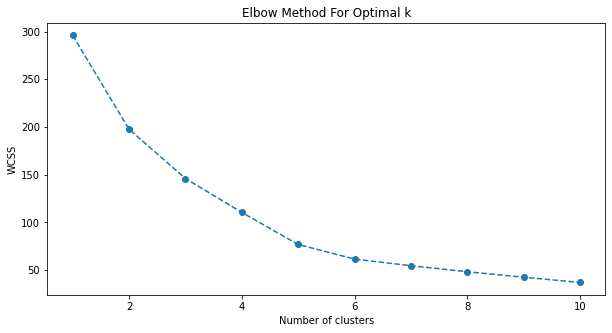

In [1628]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# assuming 'features' is the list of features you want to use for clustering from k_merged
X = k_merged[features]

# fill NaN
X = X.fillna(X.median())

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the number of clusters using the elbow method
wcss = []

# Let's check for up to 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the results on a graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [1656]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# assuming 'features' is the list of features you want to use for clustering from k_merged
X = k_merged[features]

# fill NaN
X = X.fillna(X.median())

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the number of clusters
wcss = []

# Let's check for up to 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Calculate the second order differences (difference of differences) in WCSS between each number of clusters
differences = np.diff(wcss, n=2)

# Get the top 3 optimal clusters based on the maximum second order differences
top_3_clusters = differences.argsort()[-3:][::-1] + 3  # Adding 3 to adjust for the second order difference indexing

print(f"The top three suggested numbers of clusters based on the second order difference in WCSS are: {top_3_clusters[0]}, {top_3_clusters[1]}, and {top_3_clusters[2]}.")


The top three suggested numbers of clusters based on the second order difference in WCSS are: 3, 6, and 4.


In [2318]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 选择特征
features = ['Ai_d_f', 'city_park_area', 'pop_densy', 'wted_avg_cost']
X = k_merged[features]
# 填充NaN值
X = X.fillna(X.median())

# Z-score标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用KMeans聚成6个cluster，并设置random_state
kmeans = KMeans(n_clusters=6, random_state=5)
k_merged['cluster'] = kmeans.fit_predict(X_scaled)

# 将标准化后的数据添加回k_merged
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=k_merged.index)
for feature in features:
    k_merged[f'scaled_{feature}'] = X_scaled_df[feature]

# 只对标准化后的特征计算均值和标准差
scaled_features = [f'scaled_{feature}' for feature in features]
cluster_summary = k_merged.groupby('cluster')[scaled_features].agg(['mean', 'std'])

cluster_summary


scaled_Ai_d_f           scaled_city_park_area            \
                 mean       std                  mean       std   
cluster                                                           
0           -0.086517  0.299396             -0.119591  0.428387   
1            0.144735  0.280525              1.777641  1.042315   
2            2.297363  0.845412             -0.581935  0.045085   
3           -0.712380  0.507927             -0.545597  0.219254   
4            3.966603       NaN              3.638808       NaN   
5           -0.180834  0.495094             -0.333117  0.235776   

        scaled_pop_densy           scaled_wted_avg_cost            
                    mean       std                 mean       std  
cluster                                                            
0               1.631635  0.567136             0.851075  0.168593  
1               0.055401  0.665684             0.896733  0.132594  
2              -0.923634  0.269879            -0.681278  0.901128  
3              -0.455767  0.566932            -1.357798  0.302748  
4              -1.015080       NaN             0.388935       NaN  
5              -0.448177  0.453089             0.391644  0.494206

In [1821]:
# # 使用KMeans聚成6个cluster，并设置random_state
# kmeans = KMeans(n_clusters=6, random_state=5)
# k_merged['cluster'] = kmeans.fit_predict(X_scaled)

# # 只对features中的特征计算均值和标准差
# cluster_summary = k_merged.groupby('cluster')[features].agg(['mean', 'std'])

# cluster_summary

Ai_d_f           city_park_area               pop_densy            \
              mean       std           mean           std      mean       std   
cluster                                                                         
0        15.205522  3.084929   5.473903e+05  4.877690e+05  0.027392  0.005394   
1        17.588308  2.890482   2.707613e+06  1.186798e+06  0.012401  0.006331   
2        39.768644  8.710987   2.095713e+04  5.133428e+04  0.003090  0.002567   
3         8.756729  5.233604   6.233246e+04  2.496465e+05  0.007540  0.005392   
4        56.968227       NaN   4.826771e+06           NaN  0.002220       NaN   
5        14.233696  5.101368   3.042654e+05  2.684590e+05  0.007612  0.004309   

        wted_avg_cost              
                 mean         std  
cluster                            
0         1519.154895  106.331935  
1         1547.951389   83.627253  
2          552.695555  568.343782  
3          126.012403  190.943892  
4         1227.682073         NaN  
5         1226.231218  319.449172

In [2312]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 选择特征
features = ['Ai_d_f', 'city_park_area', 'pop_densy', 'wted_avg_cost']
X = k_merged[features]
# 填充NaN值
X = X.fillna(X.median())

# Z-score标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用KMeans聚成6个cluster，并设置random_state
kmeans = KMeans(n_clusters=6, random_state=5)
k_merged['cluster'] = kmeans.fit_predict(X_scaled)

# 将标准化后的数据添加回k_merged
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=k_merged.index)
for feature in features:
    k_merged[f'scaled_{feature}'] = X_scaled_df[feature]

# 计算每个cluster的人口占比
total_population = k_merged['popsum'].sum()
cluster_pop_percentage = k_merged.groupby('cluster')['popsum'].sum() / total_population

# 只对标准化后的特征计算均值和标准差，并增加每个cluster的数量
scaled_features = [f'scaled_{feature}' for feature in features]
agg_functions = {f: ['mean', 'std'] for f in scaled_features}
agg_functions['popsum'] = 'count'  # 添加每个cluster的数量

cluster_summary = k_merged.groupby('cluster').agg(agg_functions)
cluster_summary[('popsum', 'percentage')] = cluster_pop_percentage

cluster_summary


scaled_Ai_d_f           scaled_city_park_area            \
                 mean       std                  mean       std   
cluster                                                           
0           -0.086517  0.299396             -0.119591  0.428387   
1            0.144735  0.280525              1.777641  1.042315   
2            2.297363  0.845412             -0.581935  0.045085   
3           -0.712380  0.507927             -0.545597  0.219254   
4            3.966603       NaN              3.638808       NaN   
5           -0.180834  0.495094             -0.333117  0.235776   

        scaled_pop_densy           scaled_wted_avg_cost           popsum  \
                    mean       std                 mean       std  count   
cluster                                                                    
0               1.631635  0.567136             0.851075  0.168593     15   
1               0.055401  0.665684             0.896733  0.132594     11   
2              -0.923634  0.269879            -0.681278  0.901128      6   
3              -0.455767  0.566932            -1.357798  0.302748     20   
4              -1.015080       NaN             0.388935       NaN      1   
5              -0.448177  0.453089             0.391644  0.494206     21   

                    
        percentage  
cluster             
0         0.170096  
1         0.186224  
2         0.033992  
3         0.298139  
4         0.007981  
5         0.303569

In [2309]:
cluster_summary.to_csv('tmp/subdistrict_cluster_summary.csv',index=True,encoding='utf-8')

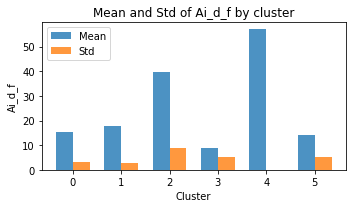

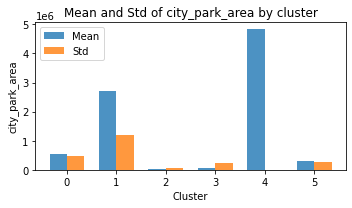

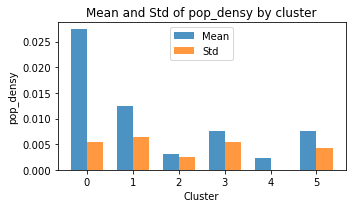

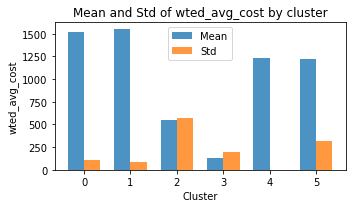

In [1822]:
# 提取均值和标准差
means = cluster_summary.xs('mean', axis=1, level=1)
stds = cluster_summary.xs('std', axis=1, level=1)

# 定义柱状图的位置和宽度
bar_width = 0.35
index = np.arange(len(means))

# 绘制每个特征的均值和标准差
for feature in means.columns:
    plt.figure(figsize=(5, 3))
    
    # 绘制均值
    plt.bar(index, means[feature], bar_width, label='Mean', alpha=0.8)
    
    # 绘制标准差
    plt.bar(index + bar_width, stds[feature], bar_width, label='Std', alpha=0.8)
    
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.title(f'Mean and Std of {feature} by cluster')
    plt.xticks(index + bar_width / 2, means.index)  # Positioning on the x axis
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [1751]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_scaled, k_merged['cluster'])

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances

Feature  Importance
3   wted_avg_cost    0.321743
2       pop_densy    0.283707
1  city_park_area    0.242329
0          Ai_d_f    0.152220

In [1824]:
# 获取标准化后的数据均值
cluster_scaled_means = pd.DataFrame(X_scaled, columns=features).groupby(k_merged['cluster']).mean().reset_index()

# 假设您希望为每个聚类定义以下标题：
cluster_titles = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    2: 'Cluster 2',
    3: 'Cluster 3',
    4: 'Cluster 4',
    5: 'Cluster 5',
    }

# 假设您希望为特征定义以下标签：
feature_labels = {
    'Ai_d_f': 'Accessiblity Score',
    'city_park_area': 'City park Area (m²)',
    'pop_densy': 'Pop Density (person/m²)',
    'wted_avg_cost': 'Average travel timie (s)'
}

# 绘制雷达图
def plot_radar_chart(cluster_num, data, features, titles, labels):
    labels_array = np.array([labels[feature] for feature in features])
    angles = np.linspace(0, 2 * np.pi, len(labels_array), endpoint=False)
    angles_grid = angles * 180 / np.pi  # This is for the grid
    
    data = np.concatenate((data, [data[0]]))  # closed
    angles = np.concatenate((angles, [angles[0]]))  # closed

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.plot(angles, data, 'o-', linewidth=2)
    ax.fill(angles, data, alpha=0.25)
    ax.set_thetagrids(angles_grid, labels_array)  # Use the modified labels here
    ax.set_title(titles[cluster_num])
    ax.grid(True)

    # Save the figure to a file
    filename = f"tmp/subdistrict_cluster_{cluster_num}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close(fig)  # Close the plot to free up memory

for i, row in cluster_scaled_means.iterrows():
    plot_radar_chart(row['cluster'], row[features].values, features, cluster_titles, feature_labels)


In [1835]:
cluster_scaled_means

cluster    Ai_d_f  city_park_area  pop_densy  wted_avg_cost
0        0 -0.086517       -0.119591   1.631635       0.851075
1        1  0.144735        1.777641   0.055401       0.896733
2        2  2.297363       -0.581935  -0.923634      -0.681278
3        3 -0.712380       -0.545597  -0.455767      -1.357798
4        4  3.966603        3.638808  -1.015080       0.388935
5        5 -0.180834       -0.333117  -0.448177       0.391644

### K-means by pop resid units

In [1784]:
result_d_f.head()

sum_pop  Popid         Ai  \
0   7276.136558      1   0.000000   
1   1217.979429      2   0.000000   
2   2048.236732      4  11.231002   
3  11243.644833      5   5.178889   
4    875.631427      6   5.778365   

                                            geometry  
0  POLYGON ((12742557.833 2583965.856, 12742480.9...  
1  POLYGON ((12745413.133 2576195.874, 12745295.9...  
2  POLYGON ((12709691.109 2588710.751, 12709781.1...  
3  POLYGON ((12702176.654 2585733.443, 12702091.5...  
4  POLYGON ((12711043.062 2583066.362, 12711070.5...

In [1786]:
pop_resid.head(2)

name      sum_pop                                           geometry  \
0  None  7276.136558  POLYGON ((12742557.833 2583965.856, 12742480.9...   
1  None  1217.979429  POLYGON ((12745413.133 2576195.874, 12745295.9...   

                          cen  Popid   longitude   latitude          area  \
0  POINT (114.47232 22.59552)      1  114.472319  22.595523  2.228591e+06   
1  POINT (114.48832 22.53681)      2  114.488317  22.536814  6.199168e+05   

   avg_cost  avg_area  
0       0.0       0.0  
1       0.0       0.0

In [1787]:
k_merged_resid = result_d_f.merge(pop_resid[['Popid', 'avg_cost', 'avg_area']], on='Popid', how='left')

# 用0替换NaN值
k_merged_resid.fillna(0, inplace=True)


In [1791]:
k_merged_resid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1828 entries, 0 to 1827
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sum_pop   1828 non-null   float64 
 1   Popid     1828 non-null   int64   
 2   Ai        1828 non-null   float64 
 3   geometry  1828 non-null   geometry
 4   avg_cost  1828 non-null   float64 
 5   avg_area  1828 non-null   float64 
dtypes: float64(4), geometry(1), int64(1)
memory usage: 100.0 KB


In [2205]:
k_merged_resid

sum_pop  Popid         Ai  \
0      7276.136558      1   0.000000   
1      1217.979429      2   0.000000   
2      2048.236732      4  11.231002   
3     11243.644833      5   5.178889   
4       875.631427      6   5.778365   
...            ...    ...        ...   
1823    325.056286   2077   5.779856   
1824   6592.324279   2078  10.619882   
1825   1589.763618   2079  12.529096   
1826    149.804736   2080   9.263823   
1827    305.918748   2081   6.999088   

                                               geometry     avg_cost  \
0     POLYGON ((12742557.833 2583965.856, 12742480.9...     0.000000   
1     POLYGON ((12745413.133 2576195.874, 12745295.9...     0.000000   
2     POLYGON ((12709691.109 2588710.751, 12709781.1...     0.000000   
3     POLYGON ((12702176.654 2585733.443, 12702091.5...  1998.293000   
4     POLYGON ((12711043.062 2583066.362, 12711070.5...  1922.368421   
...                                                 ...          ...   
1823  POLYGON ((12690104.222 2594879.791, 12690110.1...     0.000000   
1824  POLYGON ((12668653.302 2594538.785, 12668256.1...     0.000000   
1825  POLYGON ((12685408.176 2594097.317, 12685432.6...  2040.940678   
1826  POLYGON ((12688879.018 2592578.554, 12688876.6...     0.000000   
1827  POLYGON ((12692823.479 2595708.323, 12692891.1...     0.000000   

           avg_area  cluster  
0          0.000000        3  
1          0.000000        1  
2          0.000000        1  
3     790147.494771        3  
4     422075.688496        2  
...             ...      ...  
1823       0.000000        1  
1824       0.000000        3  
1825  412160.665607        2  
1826       0.000000        1  
1827       0.000000        1  

[1828 rows x 7 columns]

In [1792]:
k_merged_resid.to_csv('tmp/k_merged_resid.csv',index=False,encoding='utf-8')

k_merged_resid.to_file('tmp/k_merged_resid.geojson')

In [1793]:
print(k_merged_resid.isnull().sum())

sum_pop     0
Popid       0
Ai          0
geometry    0
avg_cost    0
avg_area    0
dtype: int64


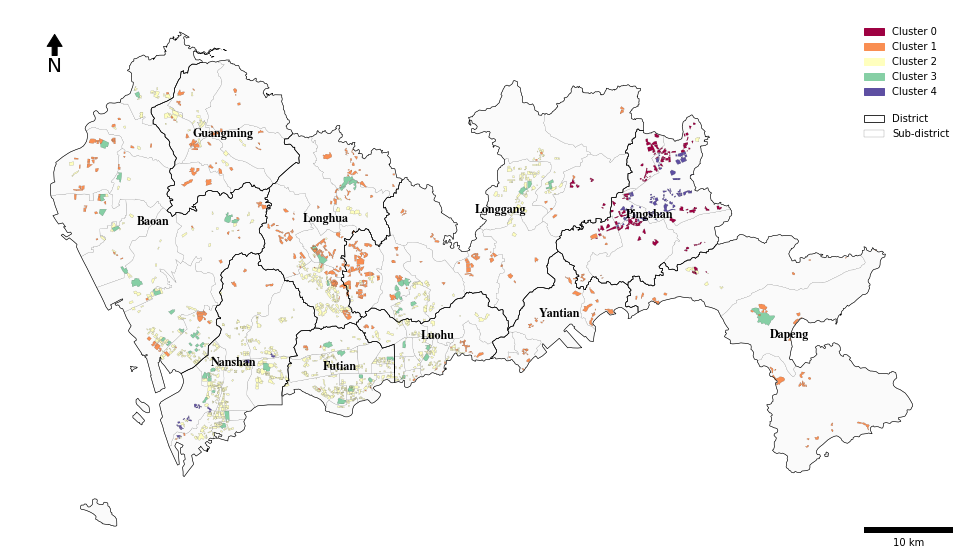

In [2152]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Choose features
features = ['Ai', 'avg_area', 'sum_pop', 'avg_cost']
X = k_merged_resid[features]
# Fill NaN
X = X.fillna(X.median())

###################### K-means ######################
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=5)
k_merged_resid['cluster'] = kmeans.fit_predict(X_scaled)

# Set up the figure
fig, ax = plt.subplots(figsize=(20, 10))

# 绘制 subdistrict 作为底图，只绘制边界
subdistrict.plot(ax=ax, facecolor='#fafafa', edgecolor='black', linewidth=0.1)
district.boundary.plot(ax=ax, color='black', linewidth=0.6)

# Plot district names
for x, y, label in zip(district.geometry.centroid.x, district.geometry.centroid.y, district['Name']):
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', va='center', fontname="Nimbus Roman", fontweight='bold')

# Use cmap parameter to change colors
k_merged_resid.plot(column='cluster', legend=False, ax=ax, edgecolor='black', linewidth=0.1, cmap='Spectral')

# Create custom legend
colors = plt.cm.Spectral([0, 0.25, 0.5, 0.75, 1])  # or adjust accordingly
labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(5)]
ax.legend(handles=patches, loc='upper right')

# Turn off coordinate axis
ax.axis('off')

# Add a north arrow
x, y, arrow_length = 0.05, 0.95, 0.06  # set arrow position and length
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

# Add a scale bar (Assuming you've already imported the necessary library/module for the scale bar)
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)  # set unit and scale length
ax.add_artist(scalebar)

# 调整图例位置、大小和文字排列
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.99, 0.98))
legend.prop.set_size(15)
legend._legend_box.align = "left"

# 删除图例的边框
frame = legend.get_frame()
frame.set_visible(False)

# 创建一个自定义的方框图例
legend_elements = [Patch(facecolor='none', edgecolor='black', linewidth=0.8, label='District'),
                   Patch(facecolor='none', edgecolor='black', linewidth=0.15, label='Sub-district')]

legend2 = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.003, 0.82), frameon=False)

# 将主要的色块图例添加回来
ax.add_artist(legend)

plt.savefig("tmp/K-means_resid.png", dpi=300, bbox_inches='tight')

plt.show()


In [1829]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# assuming 'features' is the list of features you want to use for clustering from k_merged_resid
X = k_merged_resid[features]

# fill NaN
X = X.fillna(X.median())

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the number of clusters
wcss = []

# Let's check for up to 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Calculate the second order differences (difference of differences) in WCSS between each number of clusters
differences = np.diff(wcss, n=2)

# Get the top 3 optimal clusters based on the maximum second order differences
top_3_clusters = differences.argsort()[-3:][::-1] + 3  # Adding 3 to adjust for the second order difference indexing

print(f"The top three suggested numbers of clusters based on the second order difference in WCSS are: {top_3_clusters[0]}, {top_3_clusters[1]}, and {top_3_clusters[2]}.")


The top three suggested numbers of clusters based on the second order difference in WCSS are: 3, 5, and 4.


In [1830]:
k_merged_resid

sum_pop  Popid         Ai  \
0      7276.136558      1   0.000000   
1      1217.979429      2   0.000000   
2      2048.236732      4  11.231002   
3     11243.644833      5   5.178889   
4       875.631427      6   5.778365   
...            ...    ...        ...   
1823    325.056286   2077   5.779856   
1824   6592.324279   2078  10.619882   
1825   1589.763618   2079  12.529096   
1826    149.804736   2080   9.263823   
1827    305.918748   2081   6.999088   

                                               geometry     avg_cost  \
0     POLYGON ((12742557.833 2583965.856, 12742480.9...     0.000000   
1     POLYGON ((12745413.133 2576195.874, 12745295.9...     0.000000   
2     POLYGON ((12709691.109 2588710.751, 12709781.1...     0.000000   
3     POLYGON ((12702176.654 2585733.443, 12702091.5...  1998.293000   
4     POLYGON ((12711043.062 2583066.362, 12711070.5...  1922.368421   
...                                                 ...          ...   
1823  POLYGON ((12690104.222 2594879.791, 12690110.1...     0.000000   
1824  POLYGON ((12668653.302 2594538.785, 12668256.1...     0.000000   
1825  POLYGON ((12685408.176 2594097.317, 12685432.6...  2040.940678   
1826  POLYGON ((12688879.018 2592578.554, 12688876.6...     0.000000   
1827  POLYGON ((12692823.479 2595708.323, 12692891.1...     0.000000   

           avg_area  cluster  
0          0.000000        3  
1          0.000000        1  
2          0.000000        1  
3     790147.494771        3  
4     422075.688496        2  
...             ...      ...  
1823       0.000000        1  
1824       0.000000        3  
1825  412160.665607        2  
1826       0.000000        1  
1827       0.000000        1  

[1828 rows x 7 columns]

In [2314]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 选择特征
features = ['Ai', 'avg_area', 'sum_pop', 'avg_cost']
X = k_merged_resid[features]
# Fill NaN
X = X.fillna(X.median())

# Z-score标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用KMeans聚成6个cluster，并设置random_state
kmeans = KMeans(n_clusters=5, random_state=5)
k_merged_resid['cluster'] = kmeans.fit_predict(X_scaled)


# 将标准化后的数据添加回k_merged
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=k_merged_resid.index)
for feature in features:
    k_merged_resid[f'scaled_{feature}'] = X_scaled_df[feature]

# 计算每个cluster的人口占比
total_population = k_merged_resid['sum_pop'].sum()
cluster_pop_percentage = k_merged_resid.groupby('cluster')['sum_pop'].sum() / total_population

# 只对标准化后的特征计算均值和标准差，并增加每个cluster的数量
scaled_features = [f'scaled_{feature}' for feature in features]
agg_functions = {f: ['mean', 'std'] for f in scaled_features}
agg_functions['sum_pop'] = 'count'  # 添加每个cluster的数量

cluster_summary_resid = k_merged_resid.groupby('cluster').agg(agg_functions)
cluster_summary_resid[('sum_pop', 'percentage')] = cluster_pop_percentage

cluster_summary_resid


scaled_Ai           scaled_avg_area           scaled_sum_pop  \
             mean       std            mean       std           mean   
cluster                                                                
0        1.917122  0.528427       -0.799210  0.475405      -0.433467   
1       -0.624188  0.401122       -1.168313  0.000000      -0.127465   
2       -0.180608  0.433408        0.317386  0.579559      -0.084822   
3       -0.196869  0.513465       -0.019356  0.815399       4.098479   
4        2.571945  1.362781        2.248962  0.906337      -0.455367   

                  scaled_avg_cost           sum_pop             
              std            mean       std   count percentage  
cluster                                                         
0        0.182952       -0.776033  0.993841     111   0.017653  
1        0.568923       -1.530450  0.000000     430   0.186167  
2        0.476251        0.626815  0.326793    1122   0.528595  
3        2.471220        0.052399  0.958984      60   0.252946  
4        0.226889        0.360028  0.401249     105   0.014640

In [2324]:
cluster_summary_resid.to_csv('tmp/cluster_summary_resid.csv',index=True,encoding='utf-8')

In [1831]:
# 使用KMeans聚成5个cluster，并设置random_state
kmeans = KMeans(n_clusters=5, random_state=5)
k_merged_resid['cluster'] = kmeans.fit_predict(X_scaled)

# 只对features中的特征计算均值和标准差
cluster_summary_resid = k_merged_resid.groupby('cluster')[features].agg(['mean', 'std'])

cluster_summary_resid

Ai                 avg_area                     sum_pop  \
              mean        std          mean            std         mean   
cluster                                                                   
0        44.477644   7.393139  1.780102e+05  229277.101678   299.155824   
1         8.922588   5.612038  0.000000e+00       0.000000   814.419530   
2        15.128642   6.063746  7.165199e+05  279508.477556   886.224539   
3        14.901127   7.183803  5.541166e+05  393248.569843  7930.314372   
4        53.639163  19.066446  1.648076e+06  437106.249184   262.278404   

                         avg_cost              
                 std         mean         std  
cluster                                        
0         308.065719   577.661990  760.990709  
1         957.986889     0.000000    0.000000  
2         801.940519  1651.832352  250.227598  
3        4161.187207  1211.998169  734.300849  
4         382.048511  1447.551469  307.239164

In [1832]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_scaled, k_merged_resid['cluster'])

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances

Feature  Importance
1  avg_area    0.382493
3  avg_cost    0.257447
0        Ai    0.245417
2   sum_pop    0.114643

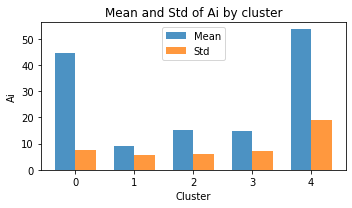

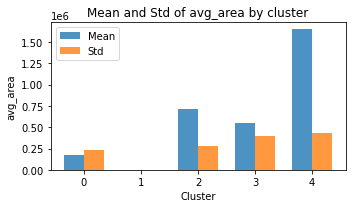

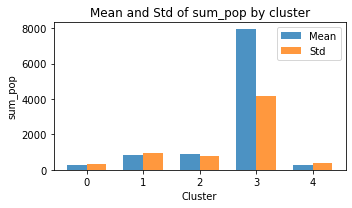

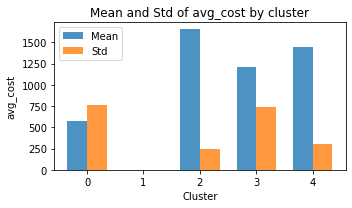

In [1839]:
# 提取均值和标准差
means = cluster_summary_resid.xs('mean', axis=1, level=1)
stds = cluster_summary_resid.xs('std', axis=1, level=1)

# 定义柱状图的位置和宽度
bar_width = 0.35
index = np.arange(len(means))

# 绘制每个特征的均值和标准差
for feature in means.columns:
    plt.figure(figsize=(5, 3))
    
    # 绘制均值
    plt.bar(index, means[feature], bar_width, label='Mean', alpha=0.8)
    
    # 绘制标准差
    plt.bar(index + bar_width, stds[feature], bar_width, label='Std', alpha=0.8)
    
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.title(f'Mean and Std of {feature} by cluster')
    plt.xticks(index + bar_width / 2, means.index)  # Positioning on the x axis
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [1837]:
cluster_scaled_means

cluster        Ai  avg_area   sum_pop  avg_cost
0        0  1.917122 -0.799210 -0.433467 -0.776033
1        1 -0.624188 -1.168313 -0.127465 -1.530450
2        2 -0.180608  0.317386 -0.084822  0.626815
3        3 -0.196869 -0.019356  4.098479  0.052399
4        4  2.571945  2.248962 -0.455367  0.360028

In [1838]:
# 获取标准化后的数据均值
cluster_scaled_means = pd.DataFrame(X_scaled, columns=features).groupby(k_merged_resid['cluster']).mean().reset_index()

# 假设您希望为每个聚类定义以下标题：
cluster_titles = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    2: 'Cluster 2',
    3: 'Cluster 3',
    4: 'Cluster 4',
    }

# 假设您希望为特征定义以下标签：
feature_labels = {
    'Ai': 'Accessiblity Score',
    'avg_area': 'City park Area (m²)',
    'sum_pop': 'Population (person)',
    'avg_cost': 'Average travel timie (s)'
}

# 绘制雷达图
def plot_radar_chart(cluster_num, data, features, titles, labels):
    labels_array = np.array([labels[feature] for feature in features])
    angles = np.linspace(0, 2 * np.pi, len(labels_array), endpoint=False)
    angles_grid = angles * 180 / np.pi  # This is for the grid
    
    data = np.concatenate((data, [data[0]]))  # closed
    angles = np.concatenate((angles, [angles[0]]))  # closed

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.plot(angles, data, 'o-', linewidth=2)
    ax.fill(angles, data, alpha=0.25)
    ax.set_thetagrids(angles_grid, labels_array)  # Use the modified labels here
    ax.set_title(titles[cluster_num])
    ax.grid(True)

    # Save the figure to a file
    filename = f"tmp/popresid_cluster_{cluster_num}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close(fig)  # Close the plot to free up memory

for i, row in cluster_scaled_means.iterrows():
    plot_radar_chart(row['cluster'], row[features].values, features, cluster_titles, feature_labels)
